In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

# Sales Analysis and Forecasting for Istanbul 

In this notebook, we will analyze the quarterly and monthly sales data of the choosen SKU's for Istanbul. We will use the Exponential Smoothing, Moving Average, Naive, Triple Exponential Smoothing, ARIMA, and SARIMA forecasting methods to forecast the sales of the choosen SKU's for the next 4 quarters and 4 months.

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

In [2]:
data = pd.read_csv('data/istanbul_data_preprocessed.csv')

name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID']
categorical_cols = ['SalesRegionID_x','SalesRegionID_y', 'HcoType' ]
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity', 'Week', 'Quarter', 'Month', 'Year']
boolean_cols = ['IsReturn', 'IsMrsOrder', 'Status']

data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Year'] = data['Date'].dt.year

data['Status'] = data['Status'].apply(lambda x: True if x == 'Active' else False)

In [3]:
# convert categorical columns to 'category' data type
for col in categorical_cols:
    data[col] = data[col].astype('category')

# convert numerical columns to 'int' data type
for col in numerical_cols:
    data[col] = data[col].astype('int')

# convert name columns to str data type
for col in name_cols:
    data[col] = data[col].astype(str)

# convert boolean columns to 'bool' data type
for col in boolean_cols:
    data[col] = data[col].astype(bool)

data.info()
raw_data = data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4201059 entries, 0 to 4201058
Data columns (total 20 columns):
 #   Column           Dtype         
---  ------           -----         
 0   MainDistID       object        
 1   DistID           object        
 2   Date             datetime64[ns]
 3   HcoID            object        
 4   SalesRegionID_x  category      
 5   BrandID          int64         
 6   SkuID            object        
 7   IsReturn         bool          
 8   PaidQty          int64         
 9   FGQty            int64         
 10  IsMrsOrder       bool          
 11  HcoType          category      
 12  District         object        
 13  SalesRegionID_y  category      
 14  Status           bool          
 15  TotalQuantity    int64         
 16  Week             int64         
 17  Month            int64         
 18  Quarter          int64         
 19  Year             int64         
dtypes: bool(3), category(3), datetime64[ns](1), int64(8), object(5)
memo

In [4]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = segment_1_sku_ids + segment_2_sku_ids

data = data[data['SkuID'].isin(all_sku_ids)]

# Quarterly Sales Analysis

Calculate the total sales of the choosen SKU's for quarterly. It should be 12 rows in total for every SKU.

In [5]:
quarterly_data = data.copy()

quarterly_data = quarterly_data.groupby(['Year', 'Quarter', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
quarterly_data

Year  Quarter SkuID  TotalQuantity
0   2019        1  1018          13937
1   2019        1  1050          52981
2   2019        1   319          46823
3   2019        1   509          43084
4   2019        1   568         145879
..   ...      ...   ...            ...
79  2021        4   319          76375
80  2021        4   509          36852
81  2021        4   568         225966
82  2021        4   578         109939
83  2021        4   615          36842

[84 rows x 4 columns]

In [6]:
quarterly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           84 non-null     int64 
 1   Quarter        84 non-null     int64 
 2   SkuID          84 non-null     object
 3   TotalQuantity  84 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.8+ KB


In [7]:
sku_319 = quarterly_data[quarterly_data['SkuID'] == "319"]
sku_319

Year  Quarter SkuID  TotalQuantity
2   2019        1   319          46823
9   2019        2   319          42588
16  2019        3   319          42818
23  2019        4   319          49943
30  2020        1   319          56466
37  2020        2   319          49173
44  2020        3   319          50841
51  2020        4   319          59334
58  2021        1   319          62174
65  2021        2   319          53335
72  2021        3   319          52102
79  2021        4   319          76375

In [8]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Parametre kombinasyonlarını oluştur
p_values = range(0, 3) # Örnek olarak 0'dan 3'e kadar p değerleri
d_values = range(0, 2) # Örnek olarak 0'dan 2'ye kadar d değerleri
q_values = range(0, 3) # Örnek olarak 0'dan 3'e kadar q değerleri
param_combinations = list(itertools.product(p_values, d_values, q_values))

best_score, best_params, best_model, mape = float("inf"), None, None, None

df = sku_319.copy()
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Quarter'].astype(str))
df.set_index('Date', inplace=True)
df.index = df.index.to_period('Q').to_timestamp('S')

# Grid search
for param in param_combinations:
    try:
        model = ARIMA(df['TotalQuantity'], order=param)
        model_fit = model.fit()
        y_pred = model_fit.forecast(steps=2)  
        mse = mean_squared_error(df['TotalQuantity'].iloc[-2:], y_pred)
        mape = mse / df['TotalQuantity'].iloc[-2:].mean()
        if mse < best_score:
            best_score, best_params, best_model, mape = mse, param, model_fit, mape
    except:
        continue

print('Best ARIMA Model:', best_params)
print('MSE:', best_score)
print('MAPE:', mape)
print(best_model.summary())

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

Best ARIMA Model: (0, 1, 1)
MSE: 232777372.57275793
MAPE: 4176.388632966623
                               SARIMAX Results                                
Dep. Variable:          TotalQuantity   No. Observations:                   12
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -116.039
Date:                Mon, 03 Jun 2024   AIC                            236.078
Time:                        01:00:24   BIC                            236.874
Sample:                             0   HQIC                           235.576
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1204      0.845     -0.142      0.887      -1.777       1.536
sigma2      1.135e+08   9.25e-09   1.23e+16      0.000 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

In [9]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

dfSarimax = sku_319.copy()
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Quarter'].astype(str))
df.set_index('Date', inplace=True)

# Parametre kombinasyonlarını oluştur
p_values = range(0, 3) # Örnek olarak 0'dan 3'e kadar p değerleri
d_values = range(0, 2) # Örnek olarak 0'dan 2'ye kadar d değerleri
q_values = range(0, 3) # Örnek olarak 0'dan 3'e kadar q değerleri
P_values = range(0, 3) # Örnek olarak 0'dan 3'e kadar P değerleri
D_values = range(0, 2) # Örnek olarak 0'dan 2'ye kadar D değerleri
Q_values = range(0, 3) # Örnek olarak 0'dan 3'e kadar Q değerleri
s_values = range(4, 5) # Örnek olarak 4'den 5'e kadar s değerleri
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

best_score, best_params, best_model, mape = float("inf"), None, None, None

# Grid search

for param in param_combinations:
    try:
        model = SARIMAX(dfSarimax['TotalQuantity'], order=param[:3], seasonal_order=param[3:])
        model_fit = model.fit()
        y_pred = model_fit.forecast(steps=2)
        mse = mean_squared_error(dfSarimax['TotalQuantity'].iloc[-2:], y_pred)
        mape = mse / dfSarimax['TotalQuantity'].iloc[-2:].mean()
        if mse < best_score:
            best_score, best_params, best_model, mape = mse, param, model_fit, mape
    except:
        continue
        
print('Best SARIMA Model:', best_params)
print('MSE:', best_score)
print('MAPE:', mape)
print(best_model.summary())

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/ts

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23201D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   1.232D+01
  F =   12.320109562320384     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.9

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.46381D+01    |proj g|=  2.28981D+00

At iterate   10    f=  1.19758D+01    |proj g|=  1.00155D-01

At iterate   15    f=  1.18038D+01    |proj g|=  1.10670D-03

At iterate   20    f=  1.17997D+01    |proj g|=  4.06427D-03

At iterate   25    f=  1.16353D+01    |proj g|=  1.04331D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginn


At iterate   30    f=  1.11182D+01    |proj g|=  2.63260D-03

At iterate   35    f=  1.11118D+01    |proj g|=  8.89848D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     35     70      2     0     0   8.898D-06   1.111D+01
  F =   11.111833927673041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99069D+01    |proj g|=  2.61849D+01

At iterate    5    f=  1.12502D+01    |proj g|=  4.07882D-01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   15    f=  6.47312D+00    |proj g|=  5.32903D-02

At iterate   20    f=  6.47299D+00    |proj g|=  7.44497D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     31      1     0     0   7.445D-05   6.473D+00
  F =   6.4729865261356707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84334D+00    |proj g|=  9.26207D+00

At iterate    5    f=  6.47134D+00    |proj g|=  7.51039D-04


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     21      1     0     0   2.669D-04   6.471D+00
  F =   6.4713433702771299     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12348D+01    |proj g|=  1.73485D-01

At iterate    5    f=  1.09710D+01    |proj g|=  1.64718D-02

At iterate   10    f=  1.09376D+01    |proj g|=  6.23887D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14028D+01    |proj g|=  2.81991D+01

At iterate    5    f=  1.10858D+01    |proj g|=  2.12047D-01

At iterate   10    f=  1.10191D+01    |proj g|=  8.22152D-03

At iterate   15    f=  1.10082D+01    |proj g|=  1.78462D-02

At iterate   20    f=  1.10060D+01    |proj g|=  1.20190D-02

At iterate   25    f=  1.10056D+01    |proj g|=  3.29869D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     34      1     0     0   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     25      1     0     0   2.090D-04   6.471D+00
  F =   6.4713527077360711     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23211D+01    |proj g|=  8.19501D-01

At iterate    5    f=  1.20612D+01    |proj g|=  1.94997D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   20    f=  7.36600D+00    |proj g|=  1.62840D-03

At iterate   25    f=  7.36554D+00    |proj g|=  2.65177D-04

At iterate   30    f=  7.34469D+00    |proj g|=  7.50617D-02

At iterate   35    f=  7.30345D+00    |proj g|=  1.04299D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     41      1     0     0   6.336D-07   7.303D+00
  F =   7.3034478385486734     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-

ate   10    f=  6.80421D+00    |proj g|=  1.49137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   4.460D-05   6.804D+00
  F =   6.8041559712172131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82514D+01    |proj g|=  1.49112D+01

At iterate    5    f=  7.25653D+00    |proj g|=  5.57884D-01

At iterate   10    f=  6.90757D+00    |proj g|=  2.59499D-01

At iterate   15

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   10    f=  7.37824D+00    |proj g|=  5.15385D-02

At iterate   15    f=  7.35497D+00    |proj g|=  3.81885D-02

At iterate   20    f=  7.34584D+00    |proj g|=  7.86550D-03

At iterate   25    f=  7.34133D+00    |proj g|=  1.62936D-03

At iterate   30    f=  7.33959D+00    |proj g|=  2.89540D-03

At iterate   35    f=  7.33886D+00    |proj g|=  1.94646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     52      1     0     0   1.865D-03   7.339D+00
  F =   7.3388609599999128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/ts

ate    0    f=  1.23211D+01    |proj g|=  8.19501D-01

At iterate    5    f=  1.19987D+01    |proj g|=  2.69858D-02

At iterate   10    f=  1.19933D+01    |proj g|=  4.62754D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     15      1     0     0   1.513D-05   1.199D+01
  F =   11.993309569885858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82514D+01    |proj g|=  1.49112D+01

At iterate    5

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  6.77909D+00    |proj g|=  2.61489D-02

At iterate   15    f=  6.77175D+00    |proj g|=  7.65397D-03

At iterate   20    f=  6.76953D+00    |proj g|=  3.85427D-03

At iterate   25    f=  6.76927D+00    |proj g|=  6.14405D-04

At iterate   30    f=  6.76899D+00    |proj g|=  3.58766D-03

At iterate   35    f=  6.76706D+00    |proj g|=  3.12394D-02

At iterate   40    f=  6.76123D+00    |proj g|=  5.48927D-02

At iterate   45    f=  6.74708D+00    |proj g|=  1.35521D-01

At iterate   50    f=  6.73758D+00    |proj g|=  2.05090D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     98   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57455D+00    |proj g|=  4.38326D+00

At iterate    5    f=  7.11527D+00    |proj g|=  2.45911D-02

At iterate   10    f=  7.11516D+00    |proj g|=  5.71005D-04

At iterate   15    f=  7.11515D+00    |proj g|=  1.01164D-02

At iterate   20    f=  7.11393D+00    |proj g|=  1.11443D-01

At iterate   25    f=  7.02678D+00    |proj g|=  5.47223D-01

At iterate   30    f=  6.87492D+00    |proj g|=  8.42524D-02

At iterate   35    f=  6.87252D+00    |proj g|=  3.60063D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senao


At iterate    5    f=  1.18392D+01    |proj g|=  2.08146D-02

At iterate   10    f=  1.18292D+01    |proj g|=  7.32268D-03

At iterate   15    f=  1.18287D+01    |proj g|=  3.74897D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     18      1     0     0   1.766D-05   1.183D+01
  F =   11.828733981191684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23448D+01    |proj g|=  1.17705D+00

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   15    f=  1.18287D+01    |proj g|=  1.15719D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     20      1     0     0   1.766D-05   1.183D+01
  F =   11.828715793089366     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45061D+01    |proj g|=  9.50292D+00

At iterate    5    f=  7.51435D+00    |proj g|=  6.31568D-01
  ys=-3.506E-02  -gs= 4.219E-02 BFGS update SKIPPED

At iterate   10  

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte

At iterate   10    f=  6.49007D+00    |proj g|=  1.81532D-01

At iterate   15    f=  6.47762D+00    |proj g|=  4.90352D-02

At iterate   20    f=  6.47276D+00    |proj g|=  1.46769D-02

At iterate   25    f=  6.47264D+00    |proj g|=  2.62489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     41      1     0     0   2.625D-04   6.473D+00
  F =   6.4726432520246258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At itera

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate    5    f=  1.18326D+01    |proj g|=  1.51624D-02

At iterate   10    f=  1.18292D+01    |proj g|=  2.85640D-03

At iterate   15    f=  1.18289D+01    |proj g|=  7.08127D-03

At iterate   20    f=  1.18287D+01    |proj g|=  5.93491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   1.766D-05   1.183D+01
  F =   11.828716545390970     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   40    f=  6.47273D+00    |proj g|=  1.40768D-02

At iterate   45    f=  6.47265D+00    |proj g|=  4.41417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     73      1     0     0   5.848D-04   6.473D+00
  F =   6.4726422227386786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57455D+00    |proj g|=  7.48796D+00

At iterate    5    f=  6.48099D+00    |proj g|=  2.87464D-01




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   10    f=  6.47566D+00    |proj g|=  1.60628D-02

At iterate   15    f=  6.47563D+00    |proj g|=  4.60093D-03

At iterate   20    f=  6.47537D+00    |proj g|=  8.69371D-02

At iterate   25    f=  6.47466D+00    |proj g|=  8.88730D-02

At iterate   30    f=  6.47305D+00    |proj g|=  3.13515D-02

At iterate   35    f=  6.47264D+00    |proj g|=  1.94799D-02

At iterate   40    f=  6.47250D+00    |proj g|=  1.27366D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     54      1     0     0   1.141D-03   6.472D+00
  F =   6.4724904949102084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/ts


At iterate    5    f=  9.54814D+00    |proj g|=  6.86502D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   5.342D-05   9.548D+00
  F =   9.5481383312054469     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98288D+00    |proj g|=  2.12095D-01

At iterate    5    f=  5.97047D+00    |proj g|=  1.76756D-03

At iterate   10    f=  5.97004D+00    |proj g|=  3.69964D-02

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-

At iterate   15    f=  5.84488D+00    |proj g|=  2.00143D-01

At iterate   20    f=  5.84215D+00    |proj g|=  2.67452D-02

At iterate   25    f=  5.84169D+00    |proj g|=  2.56408D-02

At iterate   30    f=  5.84140D+00    |proj g|=  7.79123D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     43      1     0     0   5.697D-05   5.841D+00
  F =   5.8413969509930723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At itera

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/ts


At iterate    5    f=  5.85221D+00    |proj g|=  1.08049D-01

At iterate   10    f=  5.84728D+00    |proj g|=  2.52935D-03

At iterate   15    f=  5.84703D+00    |proj g|=  2.09473D-02

At iterate   20    f=  5.84681D+00    |proj g|=  1.81718D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     28      1     0     0   4.145D-05   5.847D+00
  F =   5.8468055394296927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-

At iterate   15    f=  5.84137D+00    |proj g|=  9.65782D-03

At iterate   20    f=  5.84133D+00    |proj g|=  5.96268D-03

At iterate   25    f=  5.84129D+00    |proj g|=  2.66216D-04

At iterate   30    f=  5.84129D+00    |proj g|=  7.88128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     32      1     0     0   7.881D-05   5.841D+00
  F =   5.8412907783628105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At itera

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77029D+00    |proj g|=  5.54033D-01

At iterate    5    f=  9.60619D+00    |proj g|=  7.26210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   3.855D-05   9.606D+00
  F =   9.6061927738529231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate    5    f=  9.61203D+00    |proj g|=  3.71037D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   3.710D-05   9.612D+00
  F =   9.6120301914575919     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77029D+00    |proj g|=  5.54055D-01

At iterate    5    f=  9.61393D+00    |proj g|=  1.86788D-02

At iterate   10    f=  9.60903D+00    |proj g|=  9.78499D-04

       

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senao


At iterate    5    f=  5.91998D+00    |proj g|=  2.28401D-02

At iterate   10    f=  5.89906D+00    |proj g|=  1.08218D-01

At iterate   15    f=  5.87445D+00    |proj g|=  2.19053D-02

At iterate   20    f=  5.87334D+00    |proj g|=  3.40883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   3.409D-05   5.873D+00
  F =   5.8733428636399054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   10    f=  9.60536D+00    |proj g|=  4.33356D-02

At iterate   15    f=  9.60352D+00    |proj g|=  1.15400D-03

At iterate   20    f=  9.60349D+00    |proj g|=  5.11436D-03

At iterate   25    f=  9.60342D+00    |proj g|=  1.67185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   4.052D-05   9.603D+00
  F =   9.6034225887916023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   15    f=  5.85965D+00    |proj g|=  5.50480D-04

At iterate   20    f=  5.85963D+00    |proj g|=  7.54918D-03

At iterate   25    f=  5.85962D+00    |proj g|=  6.24872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   4.293D-05   5.860D+00
  F =   5.8596192815239183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94145D+00    |proj g|=  3.43072D-01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/ts


At iterate    5    f=  9.53168D+00    |proj g|=  2.75332D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   7.033D-05   9.532D+00
  F =   9.5316846705812850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94014D+00    |proj g|=  2.12465D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66378D+00    |proj g|=  7.74655D-01

At iterate    5    f=  9.53255D+00    |proj g|=  4.02692D-03

At iterate   10    f=  9.53112D+00    |proj g|=  8.02003D-02

At iterate   15    f=  9.52624D+00    |proj g|=  4.78419D-03

At iterate   20    f=  9.52614D+00    |proj g|=  2.46462D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     24      1     0     0   2.465D-05   9.526D+00
  F =   9.5261359717467986     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


mber of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      8      1     0     0   9.278D-06   5.910D+00
  F =   5.9097486033120399     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94014D+00    |proj g|=  3.87982D-01

At iterate    5    f=  5.91103D+00    |proj g|=  2.88051D-02

At iterate   10    f=  5.89600D+00    |proj g|=  2.39926D-01

At iterate   15    f=  5.85843D+00    |proj g|=  6.18413D-02

At iterate   20    f=  5.85633D+00    |proj g|=  2.24483D-03

           * * 

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senao

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66378D+00    |proj g|=  7.74655D-01

At iterate    5    f=  9.53406D+00    |proj g|=  1.00841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   2.359D-05   9.534D+00
  F =   9.5340598470012026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate    5    f=  5.87002D+00    |proj g|=  3.43081D-01

At iterate   10    f=  5.84295D+00    |proj g|=  4.42372D-02

At iterate   15    f=  5.84174D+00    |proj g|=  7.21511D-04

At iterate   20    f=  5.84172D+00    |proj g|=  1.02472D-02

At iterate   25    f=  5.84161D+00    |proj g|=  9.74413D-03

At iterate   30    f=  5.84155D+00    |proj g|=  3.86986D-03

At iterate   35    f=  5.84151D+00    |proj g|=  5.83364D-03

At iterate   40    f=  5.84150D+00    |proj g|=  2.41423D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     50      1     0     0   2.396D-03   5.841D+00
  F =   5.84149903244

 This problem is unconstrained.



At iterate   35    f=  5.83734D+00    |proj g|=  8.25720D-03

At iterate   40    f=  5.83728D+00    |proj g|=  7.40737D-03

At iterate   45    f=  5.83726D+00    |proj g|=  1.00790D-02

At iterate   50    f=  5.83725D+00    |proj g|=  3.15746D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   3.157D-03   5.837D+00
  F =   5.8372450649315795     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   25    f=  1.05671D+01    |proj g|=  1.80435D-02

At iterate   30    f=  1.05477D+01    |proj g|=  8.79338D-02

At iterate   35    f=  1.05189D+01    |proj g|=  3.59033D-02

At iterate   40    f=  1.05014D+01    |proj g|=  9.67384D-03

At iterate   45    f=  1.05002D+01    |proj g|=  5.06454D-04

At iterate   50    f=  1.05000D+01    |proj g|=  1.71845D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     57      1     0     0   1.718D-04   1.050D+01
  F =   10.500016039654385     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89643D+01    |proj g|=  3.31213D+01

At iterate    5    f=  1.06639D+01    |proj g|=  1.85014D-01

At iterate   10    f=  1.05475D+01    |proj g|=  1.06318D-02

At iterate   15    f=  1.05461D+01    |proj g|=  4.43924D-05

At iterate   20    f=  1.05461D+01    |proj g|=  9.44745D-04

At iterate   25    f=  1.05453D+01    |proj g|=  5.03323D-03

At iterate   30    f=  1.05130D+01    |proj g|=  4.12377D-02

At iterate   35    f=  1.04900D+01    |proj g|=  4.74597D-02

At iterate   40    f=  1.04640D+01    |proj g|=  3.64941D-03

At iterate   45    f=  1.04638D+01    |proj g|=  4.04690D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.05453D+01    |proj g|=  3.23751D-04

At iterate   20    f=  1.05453D+01    |proj g|=  4.44883D-05

At iterate   25    f=  1.05453D+01    |proj g|=  6.05889D-04

At iterate   30    f=  1.05451D+01    |proj g|=  1.00821D-02

At iterate   35    f=  1.05220D+01    |proj g|=  8.15972D-02

At iterate   40    f=  1.04636D+01    |proj g|=  1.81267D-02

At iterate   45    f=  1.04633D+01    |proj g|=  1.08856D-03

At iterate   50    f=  1.04633D+01    |proj g|=  5.16813D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     52      1     0     0   5.168D-06   1.046D+01
  F =   10.4633094641

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate    5    f=  7.37192D+00    |proj g|=  4.06463D-01

At iterate   10    f=  6.71278D+00    |proj g|=  3.48579D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     32      1     0     0   2.243D-05   6.713D+00
  F =   6.7127419922260723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88437D+00    |proj g|=  4.76270D-01

At iterate    5    f=  7.24278D+00    |proj g|=  2.17761D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte


At iterate   15    f=  1.05475D+01    |proj g|=  1.09489D-03

At iterate   20    f=  1.05465D+01    |proj g|=  1.97784D-02

At iterate   25    f=  1.05450D+01    |proj g|=  2.05993D-03

At iterate   30    f=  1.05449D+01    |proj g|=  1.14577D-04

At iterate   35    f=  1.05449D+01    |proj g|=  2.36295D-04

At iterate   40    f=  1.05446D+01    |proj g|=  3.76634D-03

At iterate   45    f=  1.05170D+01    |proj g|=  5.12522D-02

At iterate   50    f=  1.04670D+01    |proj g|=  6.89513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   6.895D-03   1.047D+01
  F =   10.4670488361

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88437D+00    |proj g|=  4.76270D-01

At iterate    5    f=  6.97315D+00    |proj g|=  5.41620D-01

At iterate   10    f=  6.58332D+00    |proj g|=  1.95913D-01

At iterate   15    f=  6.58153D+00    |proj g|=  6.41240D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     22      1     0     0   6.412D-05   6.582D+00
  F =   6.5815291617798373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  6.58451D+00    |proj g|=  1.43786D-01

At iterate   20    f=  6.58257D+00    |proj g|=  6.96490D-02

At iterate   25    f=  6.58160D+00    |proj g|=  3.43547D-02

At iterate   30    f=  6.58148D+00    |proj g|=  2.76642D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     60      1     0     0   2.766D-03   6.581D+00
  F =   6.5814799681499778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32097D+01    |proj g|=  7.06020D+01

At iterate    5    f=  1.09282D+01    |proj g|=  4.81410D-01

At iterate   10    f=  1.06648D+01    |proj g|=  1.61545D-02

At iterate   15    f=  1.06594D+01    |proj g|=  2.93950D-05

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82123D+00    |proj g|=  4.86519D-01

At iterate    5    f=  6.69744D+00    |proj g|=  2.21464D-01

At iterate   10    f=  6.62483D+00    |proj g|=  1.61707D-01

At iterate   15    f=  6.62384D+00    |proj g|=  1.85262D-03

At iterate   20    f=  6.62379D+00    |proj g|=  1.17416D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     34      1     0     0   6.979D-05   6.624D+00
  F =   6.6237739545546077     

CONVERG

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   20    f=  1.05842D+01    |proj g|=  3.61519D-02

At iterate   25    f=  1.05664D+01    |proj g|=  1.49552D-02

At iterate   30    f=  1.05661D+01    |proj g|=  5.12078D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     44      1     0     0   5.121D-05   1.057D+01
  F =   10.566116765722223     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32097D+01    |proj g|=  7.06020D+01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   35    f=  1.05661D+01    |proj g|=  5.65571D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     42      1     0     0   5.122D-05   1.057D+01
  F =   10.566092431311835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88764D+00    |proj g|=  1.47194D-01

At iterate    5    f=  7.87517D+00    |proj g|=  5.92062D-03

At iterate   10    f=  7.87409D+00    |proj g|=  2.05429D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte


At iterate   15    f=  6.62992D+00    |proj g|=  2.18365D-02

At iterate   20    f=  6.62723D+00    |proj g|=  5.89734D-03

At iterate   25    f=  6.62637D+00    |proj g|=  8.73790D-02

At iterate   30    f=  6.62256D+00    |proj g|=  6.03488D-02

At iterate   35    f=  6.62186D+00    |proj g|=  2.54098D-02

At iterate   40    f=  6.62166D+00    |proj g|=  8.59683D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     63      1     0     0   8.856D-05   6.622D+00
  F =   6.6216601511238791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate    5    f=  1.10510D+01    |proj g|=  1.03523D-01

At iterate   10    f=  1.08014D+01    |proj g|=  3.93070D-01

At iterate   15    f=  1.05927D+01    |proj g|=  1.97560D-02

At iterate   20    f=  1.05772D+01    |proj g|=  4.55729D-02

At iterate   25    f=  1.05665D+01    |proj g|=  1.14562D-02

At iterate   30    f=  1.05661D+01    |proj g|=  5.12044D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   5.120D-05   1.057D+01
  F =   10.566104270478087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   30    f=  1.05661D+01    |proj g|=  6.13928D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     40      1     0     0   5.121D-05   1.057D+01
  F =   10.566102078660810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82123D+00    |proj g|=  4.86519D-01

At iterate    5    f=  6.67568D+00    |proj g|=  5.46253D-01

At iterate   10    f=  6.61560D+00    |proj g|=  7.38059D-02

At iter

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82123D+00    |proj g|=  4.86519D-01

At iterate    5    f=  6.72131D+00    |proj g|=  6.29993D-01

At iterate   10    f=  6.61636D+00    |proj g|=  4.41046D-02

At iterate   15    f=  6.61518D+00    |proj g|=  2.23518D-02

At iterate   20    f=  6.61396D+00    |proj g|=  9.84183D-03

At iterate   25    f=  6.61357D+00    |proj g|=  2.30959D-02

At iterate   30    f=  6.61299D+00    |proj g|=  2.17192D-02

At iterate   35    f=  6.61290D+00    |proj g|=  4.17874D-03

At iterate   40    f=  6.61290D+00    |proj g|=  1.32661D-03

At iterate   45    f=  6.61284D+00    |proj g|=  1.60463D-02

At iterate   50    f=  6.61275D+00    |proj g|=  2.47205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16454D+01    |proj g|=  1.98920D+01

At iterate    5    f=  1.08116D+01    |proj g|=  1.47198D-01

At iterate   10    f=  1.07112D+01    |proj g|=  5.62045D-02

At iterate   15    f=  1.06769D+01    |proj g|=  3.88926D-02

At iterate   20    f=  1.06745D+01    |proj g|=  1.18373D-04

At iterate   25    f=  1.06745D+01    |proj g|=  9.17385D-04

At iterate   30    f=  1.06741D+01    |proj g|=  1.02794D-02

At iterate   35    f=  1.05900D+01    |proj g|=  1.76285D-03

At iterate   40    f=  1.05459D+01    |proj g|=  1.15962D-02

At iterate   45    f=  1.05447D+01    |proj g|=  7.73390D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   45    f=  1.04513D+01    |proj g|=  1.63358D-03

At iterate   50    f=  1.04512D+01    |proj g|=  1.61769D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   1.618D-03   1.045D+01
  F =   10.451247197854851     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16454D+01    |proj g|=  1.98920D+01

At iterate    5    f=  1.07637D+01    |proj g|=  9.24913D-02

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   35    f=  6.53780D+00    |proj g|=  2.27827D-02

At iterate   40    f=  6.53518D+00    |proj g|=  3.46213D-02

At iterate   45    f=  6.53415D+00    |proj g|=  3.86040D-02

At iterate   50    f=  6.53377D+00    |proj g|=  3.64637D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   3.646D-02   6.534D+00
  F =   6.5337656524970269     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57455D+00    |proj g|=  7.48756D+00


 This problem is unconstrained.



At iterate    5    f=  6.49005D+00    |proj g|=  3.31477D-01

At iterate   10    f=  6.47574D+00    |proj g|=  7.86131D-04

At iterate   15    f=  6.47574D+00    |proj g|=  1.15218D-02

At iterate   20    f=  6.46749D+00    |proj g|=  3.79333D-01

At iterate   25    f=  6.45464D+00    |proj g|=  5.44131D-01

At iterate   30    f=  6.43867D+00    |proj g|=  9.70044D-02

At iterate   35    f=  6.43134D+00    |proj g|=  2.14171D-01

At iterate   40    f=  6.42798D+00    |proj g|=  8.05535D-02

At iterate   45    f=  6.42690D+00    |proj g|=  1.15840D-02

At iterate   50    f=  6.42670D+00    |proj g|=  5.22099D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate    5    f=  1.07335D+01    |proj g|=  7.20923D-02

At iterate   10    f=  1.06590D+01    |proj g|=  7.13180D-02

At iterate   15    f=  1.06364D+01    |proj g|=  1.89842D-02

At iterate   20    f=  1.06342D+01    |proj g|=  1.33054D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   5.405D-05   1.063D+01
  F =   10.634206323174888     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57455D+00    |proj g|=  7.48796D+00

At iterate    5    f=  6.80513D+00    |proj g|=  4.59502D-01

At iterate   10    f=  6.50488D+00    |proj g|=  1.54487D-01

At iterate   15    f=  6.47474D+00    |proj g|=  6.54692D-02

At iterate   20    f=  6.47264D+00    |proj g|=  8.35918D-03

At iterate   25    f=  6.47257D+00    |proj g|=  1.44105D-03

At iterate   30    f=  6.46962D+00    |proj g|=  3.43472D-01

At iterate   35    f=  6.45781D+00    |proj g|=  1.62108D-01

At iterate   40    f=  6.44045D+00    |proj g|=  1.43805D-01

At iterate   45    f=  6.42621D+00    |proj g|=  1.84807D-01

At iterate   50    f=  6.41648D+00    |proj g|=  1.41264D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  6.47248D+00    |proj g|=  3.77704D-01

At iterate   25    f=  6.44033D+00    |proj g|=  1.42390D-01



/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   30    f=  6.41402D+00    |proj g|=  1.72677D-01

At iterate   35    f=  6.41040D+00    |proj g|=  3.58427D-02

At iterate   40    f=  6.40994D+00    |proj g|=  1.29483D-02

At iterate   45    f=  6.40538D+00    |proj g|=  1.55610D-01

At iterate   50    f=  6.40388D+00    |proj g|=  8.35707D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   8.357D-02   6.404D+00
  F =   6.4038771234772200     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16454D+01    |proj g|=  1.98920D+01

At iterate    5    f=  1.07296D+01    |proj g|=  5.67182D-02

At iterate   10    f=  1.06563D+01    |proj g|=  5.70830D-02

At iterate   15    f=  1.06364D+01    |proj g|=  9.26859D-03

At iterate   20    f=  1.06334D+01    |proj g|=  1.32370D-03

At iterate   25    f=  1.06334D+01    |proj g|=  4.98705D-04

At iterate   30    f=  1.06333D+01    |proj g|=  3.15398D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     39      1     0     0   5.430D-05   1.063D+01
  F =   10.633343552624268     

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  6.47545D+00    |proj g|=  1.17631D-03

At iterate   15    f=  6.47541D+00    |proj g|=  1.98435D-02

At iterate   20    f=  6.47407D+00    |proj g|=  1.96593D-01

At iterate   25    f=  6.47098D+00    |proj g|=  2.10069D-01

At iterate   30    f=  6.46032D+00    |proj g|=  4.71225D-01

At iterate   35    f=  6.42876D+00    |proj g|=  1.44387D-01

At iterate   40    f=  6.42225D+00    |proj g|=  3.25109D-02

At iterate   45    f=  6.42121D+00    |proj g|=  8.72760D-03

At iterate   50    f=  6.41892D+00    |proj g|=  1.44652D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   25    f=  6.47398D+00    |proj g|=  1.48267D-01

At iterate   30    f=  6.47102D+00    |proj g|=  1.44900D-01

At iterate   35    f=  6.45302D+00    |proj g|=  2.60346D-01

At iterate   40    f=  6.44463D+00    |proj g|=  5.33765D-02

At iterate   45    f=  6.44356D+00    |proj g|=  1.50700D-02

At iterate   50    f=  6.42123D+00    |proj g|=  3.61330D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   3.613D-01   6.421D+00
  F =   6.4212304754358520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   10    f=  9.56629D+00    |proj g|=  4.49244D-02

At iterate   15    f=  9.56447D+00    |proj g|=  4.71673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   3.155D-05   9.564D+00
  F =   9.5644556686748139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94086D+00    |proj g|=  4.05799D-01

At iterate    5    f=  5.91409D+00    |proj g|=  1.41371D-06

       

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate    5    f=  5.86069D+00    |proj g|=  9.28751D-02

At iterate   10    f=  5.84783D+00    |proj g|=  1.99509D-02

At iterate   15    f=  5.84400D+00    |proj g|=  5.17425D-02

At iterate   20    f=  5.84266D+00    |proj g|=  1.49923D-02

At iterate   25    f=  5.84230D+00    |proj g|=  1.53088D-02

At iterate   30    f=  5.84229D+00    |proj g|=  8.47781D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     43      1     0     0   8.478D-05   5.842D+00
  F =   5.8422896517988301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65341D+00    |proj g|=  6.15150D-01

At iterate    5    f=  9.56943D+00    |proj g|=  2.82672D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   2.827D-05   9.569D+00
  F =   9.5694282385568599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterat

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senao


At iterate   20    f=  9.56326D+00    |proj g|=  1.80870D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   1.284D-04   9.563D+00
  F =   9.5632578235003187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94086D+00    |proj g|=  4.05799D-01

At iterate    5    f=  5.85849D+00    |proj g|=  9.62139D-02

At iterate   10    f=  5.84862D+00    |proj g|=  6.41252D-02

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   10    f=  5.83465D+00    |proj g|=  1.45410D-02

At iterate   15    f=  5.83210D+00    |proj g|=  5.85247D-02

At iterate   20    f=  5.83172D+00    |proj g|=  1.75346D-03

At iterate   25    f=  5.83158D+00    |proj g|=  3.30723D-02

At iterate   30    f=  5.83115D+00    |proj g|=  4.96362D-03

At iterate   35    f=  5.83104D+00    |proj g|=  1.29306D-02

At iterate   40    f=  5.83096D+00    |proj g|=  8.15508D-03

At iterate   45    f=  5.83092D+00    |proj g|=  2.38670D-03

At iterate   50    f=  5.83090D+00    |proj g|=  4.64720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54    

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   10    f=  5.92003D+00    |proj g|=  7.01037D-02

At iterate   15    f=  5.91938D+00    |proj g|=  1.62085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   1.621D-04   5.919D+00
  F =   5.9193849576127127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94999D+00    |proj g|=  2.77205D-01

At iterate    5    f=  5.88518D+00    |proj g|=  2.70343D-01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   15    f=  9.60307D+00    |proj g|=  1.90201D-02

At iterate   20    f=  9.60296D+00    |proj g|=  5.13882D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   3.780D-05   9.603D+00
  F =   9.6029576285325362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72894D+00    |proj g|=  5.44099D-01

At iterate    5    f=  9.60754D+00    |proj g|=  5.79627D-03

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.59910D+00    |proj g|=  3.09895D-02

At iterate   25    f=  9.59844D+00    |proj g|=  4.81773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   3.988D-05   9.598D+00
  F =   9.5984435180358183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94999D+00    |proj g|=  2.77236D-01

At iterate    5    f=  5.91893D+00    |proj g|=  3.53715D-03

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   20    f=  5.86969D+00    |proj g|=  8.75413D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   3.466D-05   5.870D+00
  F =   5.8696852536962369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94999D+00    |proj g|=  2.77236D-01

At iterate    5    f=  5.87500D+00    |proj g|=  2.03145D-01

At iterate   10    f=  5.86971D+00    |proj g|=  1.48697D-02

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     59      1     0     0   1.862D-04   5.864D+00
  F =   5.8635266343167372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72894D+00    |proj g|=  5.44099D-01

At iterate    5    f=  9.60785D+00    |proj g|=  6.11810D-03

At iterate   10    f=  9.60263D+00    |proj g|=  1.71420D-02

At iterate   15    f=  9.60219D+00    |proj g|=  1.06474D-04

       

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte


At iterate   20    f=  5.86563D+00    |proj g|=  1.29237D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     36      1     0     0   4.988D-05   5.866D+00
  F =   5.8656324355748906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94999D+00    |proj g|=  2.77236D-01

At iterate    5    f=  5.86974D+00    |proj g|=  8.73254D-02

At iterate   10    f=  5.85877D+00    |proj g|=  1.39912D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.85964D+00    |proj g|=  1.78318D-02

At iterate   15    f=  5.85655D+00    |proj g|=  7.86927D-03

At iterate   20    f=  5.85630D+00    |proj g|=  1.97741D-02

At iterate   25    f=  5.85609D+00    |proj g|=  2.90119D-03

At iterate   30    f=  5.85606D+00    |proj g|=  9.19460D-03

At iterate   35    f=  5.85589D+00    |proj g|=  4.20886D-03

At iterate   40    f=  5.85589D+00    |proj g|=  3.20333D-03

At iterate   45    f=  5.85588D+00    |proj g|=  8.08234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     53      1     0     0   4.959D-04   5.856D+00
  F =   5.85588440350

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate    5    f=  9.56972D+00    |proj g|=  1.05171D-02

At iterate   10    f=  9.56655D+00    |proj g|=  1.03923D-01

At iterate   15    f=  9.55431D+00    |proj g|=  1.33847D-01

At iterate   20    f=  9.54628D+00    |proj g|=  1.33680D-02

At iterate   25    f=  9.54359D+00    |proj g|=  2.30394D-03

At iterate   30    f=  9.54321D+00    |proj g|=  9.27103D-04

At iterate   35    f=  9.54312D+00    |proj g|=  1.47728D-03

At iterate   40    f=  9.52526D+00    |proj g|=  3.12644D-02

At iterate   45    f=  9.52227D+00    |proj g|=  9.81593D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     54   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   15    f=  9.49041D+00    |proj g|=  4.26324D-02

At iterate   20    f=  9.48305D+00    |proj g|=  2.03234D-02

At iterate   25    f=  9.47895D+00    |proj g|=  7.74194D-03

At iterate   30    f=  9.47829D+00    |proj g|=  3.85139D-03

At iterate   35    f=  9.47816D+00    |proj g|=  1.19460D-03

At iterate   40    f=  9.47814D+00    |proj g|=  1.58138D-03

At iterate   45    f=  9.47791D+00    |proj g|=  1.37467D-02

At iterate   50    f=  9.47276D+00    |proj g|=  5.66227D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   5.662D-02   9.473D+00
  F =   9.47275817198

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senao


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     37      1     0     0   3.240D-05   5.882D+00
  F =   5.8818471702081423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94014D+00    |proj g|=  3.87950D-01

At iterate    5    f=  5.87464D+00    |proj g|=  7.63529D-02

At iterate   10    f=  5.86006D+00    |proj g|=  2.16710D-02

At iterate   15    f=  5.85991D+00    |proj g|=  1.71557D-04

       

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   20    f=  9.50067D+00    |proj g|=  3.54355D-02

At iterate   25    f=  9.49623D+00    |proj g|=  1.07487D-02

At iterate   30    f=  9.49535D+00    |proj g|=  3.86847D-03

At iterate   35    f=  9.49522D+00    |proj g|=  1.81263D-03

At iterate   40    f=  9.49517D+00    |proj g|=  1.19249D-03

At iterate   45    f=  9.49350D+00    |proj g|=  5.78404D-02

At iterate   50    f=  9.48463D+00    |proj g|=  1.20232D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   1.202D-02   9.485D+00
  F =   9.4846301901416403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.



At iterate   20    f=  5.85812D+00    |proj g|=  3.11307D-02

At iterate   25    f=  5.85077D+00    |proj g|=  9.81179D-03

At iterate   30    f=  5.85060D+00    |proj g|=  1.54008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     36      1     0     0   3.403D-05   5.851D+00
  F =   5.8505928657645221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94014D+00    |proj g|=  3.87982D-01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.85288D+00    |proj g|=  1.30939D-02

At iterate   15    f=  5.85046D+00    |proj g|=  1.16722D-01

At iterate   20    f=  5.84863D+00    |proj g|=  1.19688D-02

At iterate   25    f=  5.84800D+00    |proj g|=  8.06224D-03

At iterate   30    f=  5.84797D+00    |proj g|=  6.73071D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     38      1     0     0   2.033D-04   5.848D+00
  F =   5.8479661805495695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10717D+01    |proj g|=  1.30207D+00

At iterate    5    f=  9.53900D+00    |proj g|=  1.06934D-01

At iterate   10    f=  9.52939D+00    |proj g|=  1.72962D-01

At iterate   15    f=  9.50243D+00    |proj g|=  2.20116D-02

At iterate   20    f=  9.49796D+00    |proj g|=  5.82557D-02

At iterate   25    f=  9.49390D+00    |proj g|=  5.83043D-03

At iterate   30    f=  9.49332D+00    |proj g|=  4.39966D-04

At iterate   35    f=  9.49323D+00    |proj g|=  4.19741D-03

At iterate   40    f=  9.49319D+00    |proj g|=  3.62705D-04

At iterate   45    f=  9.49288D+00    |proj g|=  2.77940D-02

At iterate   50    f=  9.48652D+00    |proj g|=  1.09175D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   45    f=  9.46850D+00    |proj g|=  3.02168D-03

At iterate   50    f=  9.46840D+00    |proj g|=  2.64268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   2.643D-03   9.468D+00
  F =   9.4683984167891442     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10717D+01    |proj g|=  1.30207D+00

At iterate    5    f=  9.55629D+00    |proj g|=  4.15842D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  9.47031D+00    |proj g|=  1.84681D-01

At iterate   20    f=  9.44743D+00    |proj g|=  4.60264D-02

At iterate   25    f=  9.43481D+00    |proj g|=  3.02625D-02

At iterate   30    f=  9.43439D+00    |proj g|=  1.26593D-02

At iterate   35    f=  9.42923D+00    |proj g|=  2.41360D-02

At iterate   40    f=  9.42820D+00    |proj g|=  3.45528D-03

At iterate   45    f=  9.42819D+00    |proj g|=  4.47260D-04

At iterate   50    f=  9.42818D+00    |proj g|=  4.62678D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   4.627D-03   9.428D+00
  F =   9.42818104824

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  5.85155D+00    |proj g|=  1.48036D-02

At iterate   20    f=  5.85058D+00    |proj g|=  9.05870D-03

At iterate   25    f=  5.85054D+00    |proj g|=  1.22528D-02

At iterate   30    f=  5.85014D+00    |proj g|=  1.68750D-02

At iterate   35    f=  5.85004D+00    |proj g|=  1.57381D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     57      1     0     0   3.424D-05   5.850D+00
  F =   5.8500417751860931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  5.84178D+00    |proj g|=  1.13794D-02

At iterate   25    f=  5.84080D+00    |proj g|=  3.04592D-02

At iterate   30    f=  5.84063D+00    |proj g|=  6.73684D-04

At iterate   35    f=  5.84063D+00    |proj g|=  9.39102D-04

At iterate   40    f=  5.84061D+00    |proj g|=  1.26459D-02

At iterate   45    f=  5.84053D+00    |proj g|=  4.00578D-03

At iterate   50    f=  5.84048D+00    |proj g|=  1.14903D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.149D-03   5.840D+00
  F =   5.8404836839515140     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.85366D+00    |proj g|=  2.90999D-01

At iterate   10    f=  5.84090D+00    |proj g|=  1.35070D-02

At iterate   15    f=  5.83984D+00    |proj g|=  8.88982D-02

At iterate   20    f=  5.83812D+00    |proj g|=  3.42985D-03

At iterate   25    f=  5.83805D+00    |proj g|=  2.08367D-02

At iterate   30    f=  5.83763D+00    |proj g|=  3.02357D-02

At iterate   35    f=  5.83742D+00    |proj g|=  2.47254D-02

At iterate   40    f=  5.83722D+00    |proj g|=  3.23587D-02

At iterate   45    f=  5.83704D+00    |proj g|=  9.99260D-03

At iterate   50    f=  5.83699D+00    |proj g|=  1.14155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83295D+01    |proj g|=  3.19820D+01

At iterate    5    f=  1.09434D+01    |proj g|=  2.36284D-01

At iterate   10    f=  1.07015D+01    |proj g|=  3.01639D-02

At iterate   15    f=  1.06951D+01    |proj g|=  1.39391D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   3.295D-06   1.070D+01
  F =   10.695122326499165     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate    5    f=  1.06761D+01    |proj g|=  1.54654D-01

At iterate   10    f=  1.05736D+01    |proj g|=  3.82299D-02

At iterate   15    f=  1.05693D+01    |proj g|=  5.27576D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   3.939D-05   1.057D+01
  F =   10.569239410133303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13725D+00    |proj g|=  2.33996D+00

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/ts


At iterate   10    f=  6.56243D+00    |proj g|=  6.34289D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   6.343D-05   6.562D+00
  F =   6.5624271255839233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83295D+01    |proj g|=  3.19820D+01

At iterate    5    f=  1.06186D+01    |proj g|=  1.15692D-01

At iterate   10    f=  1.05560D+01    |proj g|=  1.82152D-02

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   40    f=  1.04536D+01    |proj g|=  3.53326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     49      1     0     0   8.480D-07   1.045D+01
  F =   10.453569784350703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83295D+01    |proj g|=  3.19820D+01

At iterate    5    f=  1.06474D+01    |proj g|=  1.07454D-01

At iterate   10    f=  1.05523D+01    |proj g|=  1.54322D-02

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09165D+01    |proj g|=  5.37609D+00

At iterate    5    f=  8.27976D+00    |proj g|=  1.19301D-01

At iterate   10    f=  7.51859D+00    |proj g|=  9.05854D-01

At iterate   15    f=  6.70410D+00    |proj g|=  6.97744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     33      1     0     0   4.565D-05   6.703D+00
  F =   6.7030607167909482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte


At iterate   20    f=  6.56248D+00    |proj g|=  1.06384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     38      1     0     0   1.786D-04   6.562D+00
  F =   6.5624763916895121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13725D+00    |proj g|=  4.01170D+00

At iterate    5    f=  6.56451D+00    |proj g|=  1.16878D-01

At iterate   10    f=  6.56215D+00    |proj g|=  6.43976D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.09734D+01    |proj g|=  4.40743D-02

At iterate   10    f=  1.07631D+01    |proj g|=  8.07497D-02

At iterate   15    f=  1.06419D+01    |proj g|=  2.32798D-01

At iterate   20    f=  1.05518D+01    |proj g|=  7.12191D-03

At iterate   25    f=  1.05514D+01    |proj g|=  3.72677D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     44      1     0     0   4.586D-05   1.055D+01
  F =   10.551397518098128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.05519D+01    |proj g|=  8.76490D-04

At iterate   20    f=  1.05516D+01    |proj g|=  1.05661D-02

At iterate   25    f=  1.05506D+01    |proj g|=  1.32194D-02

At iterate   30    f=  1.05501D+01    |proj g|=  1.39386D-03

At iterate   35    f=  1.05500D+01    |proj g|=  4.58913D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     38      1     0     0   7.062D-05   1.055D+01
  F =   10.550017888705634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate    5    f=  6.56302D+00    |proj g|=  9.15168D-02

At iterate   10    f=  6.56154D+00    |proj g|=  7.09159D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   6.334D-05   6.562D+00
  F =   6.5615388541764785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13725D+00    |proj g|=  4.01170D+00

At iterate    5    f=  6.56488D+00    |proj g|=  1.34149D-01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   35    f=  6.56135D+00    |proj g|=  1.73351D-02

At iterate   40    f=  6.56126D+00    |proj g|=  7.92511D-03

At iterate   45    f=  6.56122D+00    |proj g|=  1.52413D-02

At iterate   50    f=  6.56120D+00    |proj g|=  1.55806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.558D-03   6.561D+00
  F =   6.5611988748374506     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18374D+01    |proj g|=  1.44228D+02

At iterate    5    f=  1.22871D+01    |proj g|=  9.06740D-01

At iterate   10    f=  1.12089D+01    |proj g|=  8.24138D-02

At iterate   15    f=  1.10817D+01    |proj g|=  2.10286D-02

At iterate   20    f=  1.10661D+01    |proj g|=  2.00139D-03

At iterate   25    f=  1.10605D+01    |proj g|=  5.08959D-03

At iterate   30    f=  1.07844D+01    |proj g|=  2.02932D-01

At iterate   35    f=  1.06085D+01    |proj g|=  2.05175D-02

At iterate   40    f=  1.06078D+01    |proj g|=  1.35131D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   35    f=  6.64474D+00    |proj g|=  7.78121D-05

At iterate   40    f=  6.64472D+00    |proj g|=  2.13388D-03

At iterate   45    f=  6.64359D+00    |proj g|=  2.24430D-02

At iterate   50    f=  6.60326D+00    |proj g|=  6.44554D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     58      1     0     0   6.446D-02   6.603D+00
  F =   6.6032584488879840     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   25    f=  1.04596D+01    |proj g|=  4.35671D-03

At iterate   30    f=  1.04588D+01    |proj g|=  1.20524D-03

At iterate   35    f=  1.04582D+01    |proj g|=  1.21980D-02

At iterate   40    f=  1.03852D+01    |proj g|=  1.14007D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     55      1     0     0   2.991D-05   1.039D+01
  F =   10.385187272818248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  1.04429D+01    |proj g|=  3.13652D-02

At iterate   25    f=  1.04288D+01    |proj g|=  9.72991D-03

At iterate   30    f=  1.04280D+01    |proj g|=  9.42766D-03

At iterate   35    f=  1.04277D+01    |proj g|=  1.24125D-03

At iterate   40    f=  1.04276D+01    |proj g|=  1.01594D-03

At iterate   45    f=  1.04276D+01    |proj g|=  4.09281D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     52      1     0     0   1.075D-04   1.043D+01
  F =   10.427634764839198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum L


At iterate   10    f=  6.72664D+00    |proj g|=  7.02136D-01

At iterate   15    f=  6.63113D+00    |proj g|=  1.04109D-01

At iterate   20    f=  6.61415D+00    |proj g|=  1.84603D-02

At iterate   25    f=  6.61230D+00    |proj g|=  2.27793D-02

At iterate   30    f=  6.60269D+00    |proj g|=  1.84018D-01

At iterate   35    f=  6.59947D+00    |proj g|=  6.12785D-02

At iterate   40    f=  6.59602D+00    |proj g|=  1.96137D-02

At iterate   45    f=  6.59585D+00    |proj g|=  6.43568D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     71      1     0     0   3.054D-04   6.596D+00
  F =   6.59585190171

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   45    f=  1.04058D+01    |proj g|=  1.50417D-02

At iterate   50    f=  1.03999D+01    |proj g|=  1.65713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   1.657D-04   1.040D+01
  F =   10.399939671170999     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18374D+01    |proj g|=  1.44228D+02

At iterate    5    f=  1.06358D+01    |proj g|=  2.84665D-01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   15    f=  1.04705D+01    |proj g|=  7.64360D-02

At iterate   20    f=  1.04186D+01    |proj g|=  3.15955D-02

At iterate   25    f=  1.04116D+01    |proj g|=  3.88793D-03

At iterate   30    f=  1.04112D+01    |proj g|=  9.94862D-03

At iterate   35    f=  1.04099D+01    |proj g|=  1.46067D-03

At iterate   40    f=  1.04096D+01    |proj g|=  6.57336D-04

At iterate   45    f=  1.04095D+01    |proj g|=  1.98191D-04

At iterate   50    f=  1.04094D+01    |proj g|=  6.41421D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   6.414D-04   1.041D+01
  F =   10.4094317054

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   35    f=  6.58937D+00    |proj g|=  5.48780D-03

At iterate   40    f=  6.58926D+00    |proj g|=  6.05076D-03

At iterate   45    f=  6.58925D+00    |proj g|=  1.06322D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     57      1     0     0   1.063D-04   6.589D+00
  F =   6.5892511028547718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61455D+00    |proj g|=  5.26427D+00

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   25    f=  6.59647D+00    |proj g|=  7.31157D-02

At iterate   30    f=  6.59399D+00    |proj g|=  2.91614D-02

At iterate   35    f=  6.59154D+00    |proj g|=  3.01555D-02

At iterate   40    f=  6.59093D+00    |proj g|=  4.62263D-02

At iterate   45    f=  6.58992D+00    |proj g|=  2.22875D-02

At iterate   50    f=  6.58981D+00    |proj g|=  3.47390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   3.474D-03   6.590D+00
  F =   6.5898115334999412     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  6.62414D+00    |proj g|=  2.76118D-01

At iterate   20    f=  6.60410D+00    |proj g|=  1.73511D-02

At iterate   25    f=  6.59583D+00    |proj g|=  1.31710D-01

At iterate   30    f=  6.59278D+00    |proj g|=  5.61201D-02

At iterate   35    f=  6.59128D+00    |proj g|=  9.58575D-02

At iterate   40    f=  6.58959D+00    |proj g|=  1.86818D-02

At iterate   45    f=  6.58937D+00    |proj g|=  1.96300D-02


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   50    f=  6.58930D+00    |proj g|=  5.19382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   5.194D-03   6.589D+00
  F =   6.5892960116735644     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76909D+01    |proj g|=  3.08346D+01

At iterate    5    f=  1.07231D+01    |proj g|=  1.03848D-01

At iterate   10    f=  1.06288D+01    |proj g|=  3.31531D-02

At iter

 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   20    f=  1.05946D+01    |proj g|=  4.43950D-04
  ys=-9.350E-04  -gs= 8.103E-04 BFGS update SKIPPED

At iterate   25    f=  1.05863D+01    |proj g|=  2.04331D-02

At iterate   30    f=  1.05852D+01    |proj g|=  7.93648D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     52      1     1     0   3.327D-05   1.059D+01
  F =   10.585154579966868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-

53434D+00    |proj g|=  2.60631D-02

At iterate   25    f=  6.53360D+00    |proj g|=  1.22967D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     51      1     0     0   7.411D-03   6.533D+00
  F =   6.5334855246186514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57455D+00    |proj g|=  7.48756D+00

At iterate    5    f=  6.49774D+00    |proj g|=  4.26067D-01

At iterate   10    f=  6.47574D+0

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  1.04980D+01    |proj g|=  2.43141D-03

At iterate   35    f=  1.04746D+01    |proj g|=  4.53397D-02

At iterate   40    f=  1.03213D+01    |proj g|=  1.21355D-02

At iterate   45    f=  1.03164D+01    |proj g|=  1.42325D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     59      1     0     0   1.332D-05   1.032D+01
  F =   10.316362634937782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate    5    f=  1.06314D+01    |proj g|=  1.19259D-01

At iterate   10    f=  1.04985D+01    |proj g|=  1.30441D-02

At iterate   15    f=  1.04968D+01    |proj g|=  4.43407D-03

At iterate   20    f=  1.04963D+01    |proj g|=  6.18472D-03

At iterate   25    f=  1.04961D+01    |proj g|=  1.23237D-04

At iterate   30    f=  1.04961D+01    |proj g|=  5.81110D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     36      1     0     0   5.811D-05   1.050D+01
  F =   10.496069466878055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  9.17775D+00    |proj g|=  8.62648D-02
  ys=-9.379E-06  -gs= 6.762E-05 BFGS update SKIPPED

At iterate   30    f=  9.17774D+00    |proj g|=  6.30474D-02
  ys=-4.676E-05  -gs= 7.520E-05 BFGS update SKIPPED

At iterate   35    f=  9.17727D+00    |proj g|=  9.66100D-02

At iterate   40    f=  9.17704D+00    |proj g|=  7.22415D-02
  ys=-2.062E-08  -gs= 1.353E-06 BFGS update SKIPPED

At iterate   45    f=  9.17695D+00    |proj g|=  5.90296D-02

At iterate   50    f=  9.17649D+00    |proj g|=  7.35753D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    178      3     5     0   7.358D-02  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, fre


At iterate   50    f=  6.43175D+00    |proj g|=  1.41862D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   1.419D-01   6.432D+00
  F =   6.4317537753109351     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57455D+00    |proj g|=  7.48796D+00

At iterate    5    f=  6.49323D+00    |proj g|=  3.75728D-01

At iterate   10    f=  6.47574D+00    |proj g|=  1.74147D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   40    f=  1.06606D+01    |proj g|=  1.85469D-01

At iterate   45    f=  1.05751D+01    |proj g|=  7.54620D-02

At iterate   50    f=  1.05016D+01    |proj g|=  2.79955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     92      1     0     0   2.800D-02   1.050D+01
  F =   10.501631114448662     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76909D+01    |proj g|=  3.08346D+01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76909D+01    |proj g|=  3.08346D+01

At iterate    5    f=  1.06094D+01    |proj g|=  9.33222D-02

At iterate   10    f=  1.05028D+01    |proj g|=  1.70258D-02

At iterate   15    f=  1.04975D+01    |proj g|=  5.68134D-03

At iterate   20    f=  1.04968D+01    |proj g|=  5.05201D-03

At iterate   25    f=  1.04963D+01    |proj g|=  5.95562D-03

At iterate   30    f=  1.04961D+01    |proj g|=  6.83646D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   15    f=  6.47543D+00    |proj g|=  1.78911D-02

At iterate   20    f=  6.47513D+00    |proj g|=  9.52748D-02

At iterate   25    f=  6.47485D+00    |proj g|=  7.34652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     48      1     0     0   1.029D-02   6.475D+00
  F =   6.4748485452203433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57455D+00    |proj g|=  7.48796D+00

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  6.47379D+00    |proj g|=  4.61136D-02

At iterate   30    f=  6.47340D+00    |proj g|=  2.87763D-02

At iterate   35    f=  6.47329D+00    |proj g|=  2.05576D-02


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   40    f=  6.47261D+00    |proj g|=  4.60250D-02

At iterate   45    f=  6.46793D+00    |proj g|=  3.81003D-02

At iterate   50    f=  6.46003D+00    |proj g|=  2.13975D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65      1     0     0   2.140D-01   6.460D+00
  F =   6.4600301801026214     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82484D+00    |proj g|=  8.62094D-01

       

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     52      1     0     0   1.965D-05   9.486D+00
  F =   9.4863957802105023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92968D+00    |proj g|=  1.85403D+00

At iterate    5    f=  6.03479D+00    |proj g|=  6.16765D-01

At iterate   10    f=  5.91068D+00    |proj g|=  7.20106D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte


At iterate   10    f=  6.05619D+00    |proj g|=  1.34410D-01

At iterate   15    f=  5.99041D+00    |proj g|=  4.12457D-01

At iterate   20    f=  5.86019D+00    |proj g|=  2.45781D-02

At iterate   25    f=  5.85918D+00    |proj g|=  5.12032D-02

At iterate   30    f=  5.85371D+00    |proj g|=  4.28603D-02

At iterate   35    f=  5.85253D+00    |proj g|=  3.51958D-02

At iterate   40    f=  5.85233D+00    |proj g|=  4.24318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     57      1     0     0   1.339D-04   5.852D+00
  F =   5.8523234813701501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   10    f=  9.56785D+00    |proj g|=  1.13640D-01

At iterate   15    f=  9.55903D+00    |proj g|=  8.70443D-02

At iterate   20    f=  9.54991D+00    |proj g|=  2.39445D-02

At iterate   25    f=  9.54343D+00    |proj g|=  2.26883D-02

At iterate   30    f=  9.53900D+00    |proj g|=  1.49788D-02

At iterate   35    f=  9.53726D+00    |proj g|=  3.13612D-03

At iterate   40    f=  9.53639D+00    |proj g|=  9.14139D-03

At iterate   45    f=  9.53600D+00    |proj g|=  8.81301D-03


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  9.53578D+00    |proj g|=  9.83869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   9.839D-03   9.536D+00
  F =   9.5357807525112843     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82484D+00    |proj g|=  1.42456D+00

At iterate    5    f=  9.56707D+00    |proj g|=  2.88320D-02

At iterate   10    f=  9.55135D+00    |proj g|=  3.11930D-01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   15    f=  5.91800D+00    |proj g|=  1.26610D-01

At iterate   20    f=  5.86820D+00    |proj g|=  1.06447D-02

At iterate   25    f=  5.86460D+00    |proj g|=  6.30073D-02

At iterate   30    f=  5.86022D+00    |proj g|=  5.53897D-02

At iterate   35    f=  5.85911D+00    |proj g|=  3.54460D-02

At iterate   40    f=  5.85169D+00    |proj g|=  2.95564D-02

At iterate   45    f=  5.85032D+00    |proj g|=  3.71817D-02

At iterate   50    f=  5.84884D+00    |proj g|=  3.75421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   3.754D-02   5.849D+00
  F =   5.84884185854

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   10    f=  5.98712D+00    |proj g|=  1.87180D-01

At iterate   15    f=  5.92779D+00    |proj g|=  7.34671D-02

At iterate   20    f=  5.91981D+00    |proj g|=  1.86115D-02

At iterate   25    f=  5.89650D+00    |proj g|=  9.29167D-03

At iterate   30    f=  5.88875D+00    |proj g|=  8.64394D-02

At iterate   35    f=  5.88495D+00    |proj g|=  1.44428D-02

At iterate   40    f=  5.87285D+00    |proj g|=  2.64029D-01

At iterate   45    f=  5.85884D+00    |proj g|=  1.87615D-01

At iterate   50    f=  5.84835D+00    |proj g|=  3.31805D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70   

 This problem is unconstrained.
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail


At iterate    5    f=  9.58590D+00    |proj g|=  6.73302D-02

At iterate   10    f=  9.58215D+00    |proj g|=  4.95748D-02

At iterate   15    f=  9.58144D+00    |proj g|=  1.21065D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   7.956D-05   9.581D+00
  F =   9.5814378111441183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02330D+01    |proj g|=  1.67161D+00

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20333D+00    |proj g|=  5.85226D-01

At iterate    5    f=  6.17445D+00    |proj g|=  6.49649D-02

At iterate   10    f=  6.16906D+00    |proj g|=  1.52008D-03

At iterate   15    f=  6.16906D+00    |proj g|=  8.25718D-04

At iterate   20    f=  6.16900D+00    |proj g|=  2.47536D-02

At iterate   25    f=  6.16117D+00    |proj g|=  2.97453D-01

At iterate   30    f=  5.93291D+00    |proj g|=  7.18390D-02

At iterate   35    f=  5.90574D+00    |proj g|=  6.54953D-02

At iterate   40    f=  5.89751D+00    |proj g|=  2.51447D-03

At iterate   45    f=  5.89705D+00    |proj g|=  2.53572D-03

At iterate   50    f=  5.89700D+00    |proj g|=  3.22334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  5.80495D+00    |proj g|=  6.78276D-02

At iterate   35    f=  5.79684D+00    |proj g|=  4.59085D-01

At iterate   40    f=  5.78547D+00    |proj g|=  1.26951D-01

At iterate   45    f=  5.77797D+00    |proj g|=  3.15022D-02

At iterate   50    f=  5.77623D+00    |proj g|=  8.81608D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   8.816D-03   5.776D+00
  F =   5.7762280068856029     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   15    f=  9.55693D+00    |proj g|=  1.08099D-02

At iterate   20    f=  9.55598D+00    |proj g|=  1.54920D-02

At iterate   25    f=  9.54112D+00    |proj g|=  7.36303D-02

At iterate   30    f=  9.51833D+00    |proj g|=  1.67908D-02

At iterate   35    f=  9.50981D+00    |proj g|=  9.50346D-03

At iterate   40    f=  9.50825D+00    |proj g|=  1.32218D-02

At iterate   45    f=  9.50795D+00    |proj g|=  4.83922D-04

At iterate   50    f=  9.50773D+00    |proj g|=  8.42322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   8.423D-03   9.508D+00
  F =   9.50773317803

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.48951D+00    |proj g|=  2.45628D-01

At iterate   15    f=  9.42669D+00    |proj g|=  2.06828D-02

At iterate   20    f=  9.42204D+00    |proj g|=  1.75481D-02

At iterate   25    f=  9.41814D+00    |proj g|=  2.24469D-02

At iterate   30    f=  9.41777D+00    |proj g|=  1.63638D-03

At iterate   35    f=  9.41775D+00    |proj g|=  6.03535D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     45      1     0     0   1.743D-05   9.418D+00
  F =   9.4177542228047653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     68      1     0     0   9.869D-03   5.843D+00
  F =   5.8431292615991453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20333D+00    |proj g|=  1.05182D+00

At iterate    5    f=  5.90908D+00    |proj g|=  1.51599D+00


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.78847D+00    |proj g|=  1.73649D-01

At iterate   15    f=  5.77625D+00    |proj g|=  1.29783D-01

At iterate   20    f=  5.77442D+00    |proj g|=  5.68985D-02

At iterate   25    f=  5.77417D+00    |proj g|=  4.23884D-02

At iterate   30    f=  5.77413D+00    |proj g|=  1.35631D-03

At iterate   35    f=  5.77412D+00    |proj g|=  1.46235D-03

At iterate   40    f=  5.77375D+00    |proj g|=  1.77037D-01

At iterate   45    f=  5.77228D+00    |proj g|=  3.11192D-02

At iterate   50    f=  5.77183D+00    |proj g|=  3.88399D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate    5    f=  9.55896D+00    |proj g|=  2.48010D-02

At iterate   10    f=  9.55632D+00    |proj g|=  4.68032D-02

At iterate   15    f=  9.55333D+00    |proj g|=  1.35301D-01

At iterate   20    f=  9.52510D+00    |proj g|=  6.30819D-02

At iterate   25    f=  9.50951D+00    |proj g|=  2.40439D-02

At iterate   30    f=  9.50653D+00    |proj g|=  1.62321D-02

At iterate   35    f=  9.50593D+00    |proj g|=  1.64541D-03

At iterate   40    f=  9.50584D+00    |proj g|=  3.09151D-03

At iterate   45    f=  9.49713D+00    |proj g|=  1.85362D-02

At iterate   50    f=  9.48359D+00    |proj g|=  1.08934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   40    f=  9.41934D+00    |proj g|=  4.27537D-02

At iterate   45    f=  9.41564D+00    |proj g|=  3.54260D-02

At iterate   50    f=  9.41452D+00    |proj g|=  1.35281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.353D-03   9.415D+00
  F =   9.4145213850023168     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20333D+00    |proj g|=  1.05182D+00

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     53      1     0     0   8.816D-04   5.884D+00
  F =   5.8844242815087782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20333D+00    |proj g|=  1.05182D+00

At iterate    5    f=  5.95205D+00    |proj g|=  7.69391D-01

At iterate   10    f=  5.81742D+00    |proj g|=  1.94151D-01

At iterate   15    f=  5.79192D+00    |proj g|=  1.45203D-01

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   35    f=  5.78205D+00    |proj g|=  7.09783D-02

At iterate   40    f=  5.78184D+00    |proj g|=  3.50478D-02
  ys=-8.258E-05  -gs= 5.559E-05 BFGS update SKIPPED

At iterate   45    f=  5.78183D+00    |proj g|=  2.91710D-02

At iterate   50    f=  5.78182D+00    |proj g|=  3.16345D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    140      3     1     0   3.163D-02   5.782D+00
  F =   5.7818169471472762     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20333D+00    |proj g|=  1.05182D+00

At iterate    5    f=  5.79832D+00    |proj g|=  6.46387D-01

At iterate   10    f=  5.72974D+00    |proj g|=  3.66168D-02

At iterate   15    f=  5.72726D+00    |proj g|=  2.93001D-02

At iterate   20    f=  5.72538D+00    |proj g|=  3.40883D-03

At iterate   25    f=  5.72533D+00    |proj g|=  4.81055D-02

At iterate   30    f=  5.72448D+00    |proj g|=  7.63244D-02

At iterate   35    f=  5.72306D+00    |proj g|=  6.90946D-02

At iterate   40    f=  5.71894D+00    |proj g|=  1.35365D-01

At iterate   45    f=  5.70925D+00    |proj g|=  4.95012D-02

At iterate   50    f=  5.70539D+00    |proj g|=  1.24227D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   10    f=  1.01809D+01    |proj g|=  8.33954D-01

At iterate   15    f=  9.66498D+00    |proj g|=  7.68360D-01

At iterate   20    f=  9.62017D+00    |proj g|=  1.37955D-01

At iterate   25    f=  9.61808D+00    |proj g|=  2.13025D-02

At iterate   30    f=  9.61806D+00    |proj g|=  3.42445D-02

At iterate   35    f=  9.61786D+00    |proj g|=  8.85652D-01

At iterate   40    f=  9.61429D+00    |proj g|=  2.17569D+00

At iterate   45    f=  9.60253D+00    |proj g|=  2.17646D-01

At iterate   50    f=  9.60082D+00    |proj g|=  9.82398D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.06208D+01    |proj g|=  1.83946D-01

At iterate   10    f=  1.05615D+01    |proj g|=  3.94155D-01

At iterate   15    f=  1.05186D+01    |proj g|=  2.60989D-01

At iterate   20    f=  1.03526D+01    |proj g|=  3.55854D+00

At iterate   25    f=  9.97334D+00    |proj g|=  1.34821D+00

At iterate   30    f=  9.65077D+00    |proj g|=  2.29358D+00


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   35    f=  9.59552D+00    |proj g|=  3.11733D-01

At iterate   40    f=  9.58163D+00    |proj g|=  2.22638D-01

At iterate   45    f=  9.58131D+00    |proj g|=  1.25743D-01

At iterate   50    f=  9.57833D+00    |proj g|=  1.02996D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   1.030D+00   9.578D+00
  F =   9.5783317603361482     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  5.85998D+00    |proj g|=  1.41511D-02

At iterate   15    f=  5.85987D+00    |proj g|=  1.04114D-02

At iterate   20    f=  5.85067D+00    |proj g|=  7.20350D-02

At iterate   25    f=  5.83470D+00    |proj g|=  7.74909D-02

At iterate   30    f=  5.82850D+00    |proj g|=  6.47879D-03

At iterate   35    f=  5.82792D+00    |proj g|=  3.62121D-03

At iterate   40    f=  5.82767D+00    |proj g|=  1.60238D-02

At iterate   45    f=  5.82710D+00    |proj g|=  7.53844D-03


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   50    f=  5.82709D+00    |proj g|=  1.06801D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   1.068D-04   5.827D+00
  F =   5.8270887477036410     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15925D+01    |proj g|=  4.74725D+00

At iterate    5    f=  1.07019D+01    |proj g|=  1.45021D-01

At iterate   10    f=  1.05911D+01    |proj g|=  2.92605D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.02367D+01    |proj g|=  8.47555D-01

At iterate   15    f=  9.87022D+00    |proj g|=  5.02187D-01

At iterate   20    f=  9.73225D+00    |proj g|=  5.26966D-01

At iterate   25    f=  9.68987D+00    |proj g|=  2.41326D-01

At iterate   30    f=  9.68341D+00    |proj g|=  3.24041D-01

At iterate   35    f=  9.68327D+00    |proj g|=  4.54933D-02

At iterate   40    f=  9.68216D+00    |proj g|=  8.31533D-01

At iterate   45    f=  9.67503D+00    |proj g|=  3.80402D+00

At iterate   50    f=  9.67011D+00    |proj g|=  5.76257D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     83   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  5.88452D+00    |proj g|=  3.64570D-02

At iterate   25    f=  5.88007D+00    |proj g|=  1.76847D-02

At iterate   30    f=  5.87869D+00    |proj g|=  2.47843D-02

At iterate   35    f=  5.85402D+00    |proj g|=  9.59282D-02

At iterate   40    f=  5.84576D+00    |proj g|=  5.63304D-02

At iterate   45    f=  5.84227D+00    |proj g|=  1.63392D-02

At iterate   50    f=  5.84197D+00    |proj g|=  3.39621D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72      1     0     0   3.396D-04   5.842D+00
  F =   5.8419741464443637     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   15    f=  5.86117D+00    |proj g|=  3.53009D-02

At iterate   20    f=  5.85721D+00    |proj g|=  6.92740D-02

At iterate   25    f=  5.85303D+00    |proj g|=  5.29610D-02

At iterate   30    f=  5.84781D+00    |proj g|=  4.18351D-02

At iterate   35    f=  5.82276D+00    |proj g|=  2.42749D-01

At iterate   40    f=  5.75251D+00    |proj g|=  7.79555D-01

At iterate   45    f=  5.73163D+00    |proj g|=  1.61067D-01

At iterate   50    f=  5.73105D+00    |proj g|=  4.44491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   4.445D-03   5.731D+00
  F =   5.73105393243

 This problem is unconstrained.



At iterate   10    f=  5.85401D+00    |proj g|=  1.39130D-02

At iterate   15    f=  5.85293D+00    |proj g|=  8.51329D-02

At iterate   20    f=  5.84957D+00    |proj g|=  4.07590D-02

At iterate   25    f=  5.84840D+00    |proj g|=  1.92745D-02

At iterate   30    f=  5.84797D+00    |proj g|=  1.37326D-02

At iterate   35    f=  5.84532D+00    |proj g|=  3.40485D-02

At iterate   40    f=  5.84502D+00    |proj g|=  9.87131D-03

At iterate   45    f=  5.80497D+00    |proj g|=  2.66816D-01

At iterate   50    f=  5.78500D+00    |proj g|=  3.15008D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.06679D+01    |proj g|=  6.44721D-02

At iterate   10    f=  1.05908D+01    |proj g|=  2.14907D-01

At iterate   15    f=  1.05516D+01    |proj g|=  3.17985D-01

At iterate   20    f=  1.01213D+01    |proj g|=  6.99244D-01

At iterate   25    f=  9.98259D+00    |proj g|=  1.88992D-01

At iterate   30    f=  9.87739D+00    |proj g|=  6.36762D-01

At iterate   35    f=  9.82280D+00    |proj g|=  3.04776D-01

At iterate   40    f=  9.81466D+00    |proj g|=  3.64710D-02

At iterate   45    f=  9.81317D+00    |proj g|=  6.69659D-01

At iterate   50    f=  9.81293D+00    |proj g|=  4.76010D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   10    f=  1.05969D+01    |proj g|=  4.31813D-01

At iterate   15    f=  1.05799D+01    |proj g|=  7.99714D-02

At iterate   20    f=  1.00423D+01    |proj g|=  2.44187D+00
  ys=-4.612E+03  -gs= 3.843E+02 BFGS update SKIPPED
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15925D+01    |proj g|=  4.74725D+00

At iterate    5    f=  1.06513D+01    |proj g|=  2.73589D-01

At iterate   10    f=  1.01572D+01    |proj g|=  8.73145D-01

At iterate   15    f=  1.00036D+01    |proj g|=  2.16031D-01

At iterate   20    f=  9.83085D+00    |proj g|=  7.37193D-01

At iterate   25    f=  9.65745D+00    |proj g|=  4.50146D-01

At iterate   30    f=  9.57113D+00    |proj g|=  3.36294D-01

At iterate   35    f=  9.52003D+00    |proj g|=  5.80718D-01

At iterate   40    f=  9.49185D+00    |proj g|=  5.46169D-01

At iterate   45    f=  9.47854D+00  

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.86137D+00    |proj g|=  1.17743D-01

At iterate   10    f=  5.85251D+00    |proj g|=  2.93638D-02

At iterate   15    f=  5.85117D+00    |proj g|=  1.16714D-02

At iterate   20    f=  5.84877D+00    |proj g|=  2.30063D-01

At iterate   25    f=  5.81253D+00    |proj g|=  1.99016D-01

At iterate   30    f=  5.74153D+00    |proj g|=  6.49262D-01

At iterate   35    f=  5.72965D+00    |proj g|=  8.22283D-02

At iterate   40    f=  5.72777D+00    |proj g|=  3.59935D-02

At iterate   45    f=  5.72762D+00    |proj g|=  1.84537D-02

At iterate   50    f=  5.72669D+00    |proj g|=  9.49293D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   35    f=  5.83273D+00    |proj g|=  3.39459D-01

At iterate   40    f=  5.76861D+00    |proj g|=  3.61132D-01

At iterate   45    f=  5.73160D+00    |proj g|=  1.76000D-01

At iterate   50    f=  5.72701D+00    |proj g|=  8.42715D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   8.427D-03   5.727D+00
  F =   5.7270146316635602     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  5.83807D+00    |proj g|=  3.21007D-02

At iterate   30    f=  5.83765D+00    |proj g|=  3.46859D-03

At iterate   35    f=  5.83752D+00    |proj g|=  1.39112D-02

At iterate   40    f=  5.83663D+00    |proj g|=  1.82491D-02

At iterate   45    f=  5.83486D+00    |proj g|=  4.86799D-01

At iterate   50    f=  5.79501D+00    |proj g|=  4.35001D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65      1     0     0   4.350D-01   5.795D+00
  F =   5.7950072275110260     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Best SARIMA Model: (2, 1, 2, 2, 0, 0, 4)
MSE: 13005

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Total Quantity of SKU's for each quarter

In [10]:
# Plot SKU sales for each quarter    
def plot_sku(sku_id):
    sku = quarterly_data[quarterly_data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    plt.plot(sku['Year'].astype(str) + '-' + sku['Quarter'].astype(str), sku['TotalQuantity'])
    plt.title(f'SKU {sku_id} Total Quantity by Quarter')
    plt.xlabel('Quarter')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.show()

SKU 568
Year  Quarter
2019  1          145879
      2          123537
      3          119842
      4          156914
2020  1          153770
      2          131709
      3          138093
      4          154361
2021  1          139976
      2          165927
      3          114512
      4          225966
Name: TotalQuantity, dtype: int64


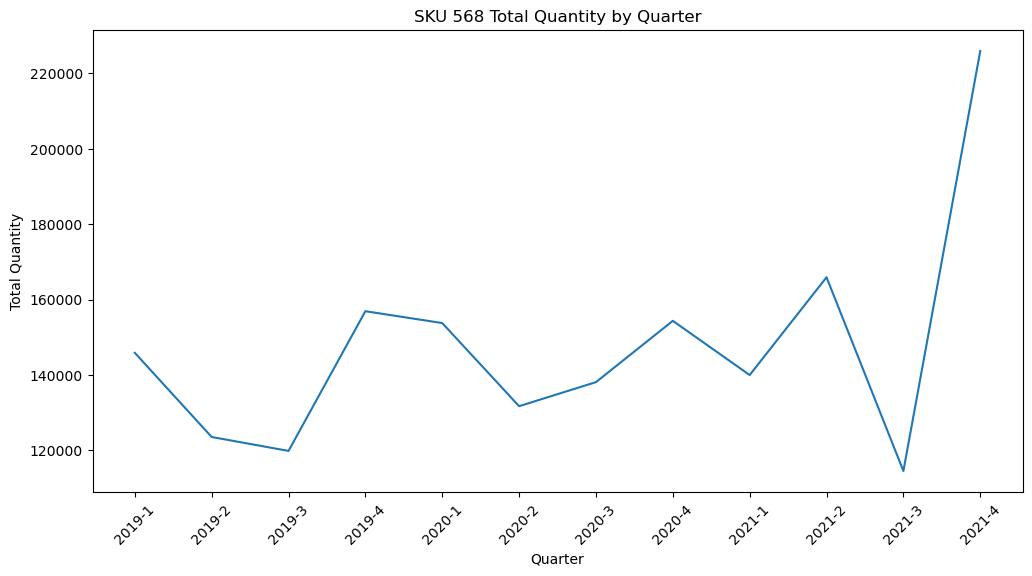

SKU 578
Year  Quarter
2019  1          102933
      2           89753
      3           76777
      4           97961
2020  1           98585
      2           87533
      3           79894
      4           78047
2021  1           91852
      2           81332
      3           60905
      4          109939
Name: TotalQuantity, dtype: int64


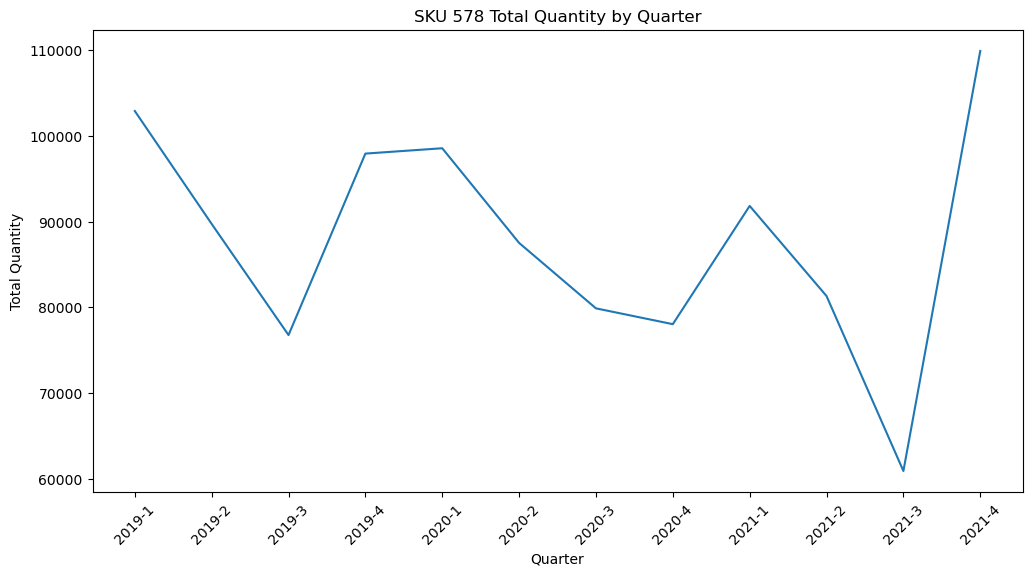

SKU 1050
Year  Quarter
2019  1          52981
      2          46656
      3          60115
      4          75765
2020  1          98657
      2          87386
      3          58010
      4          82377
2021  1          78269
      2          69268
      3          79958
      4          90674
Name: TotalQuantity, dtype: int64


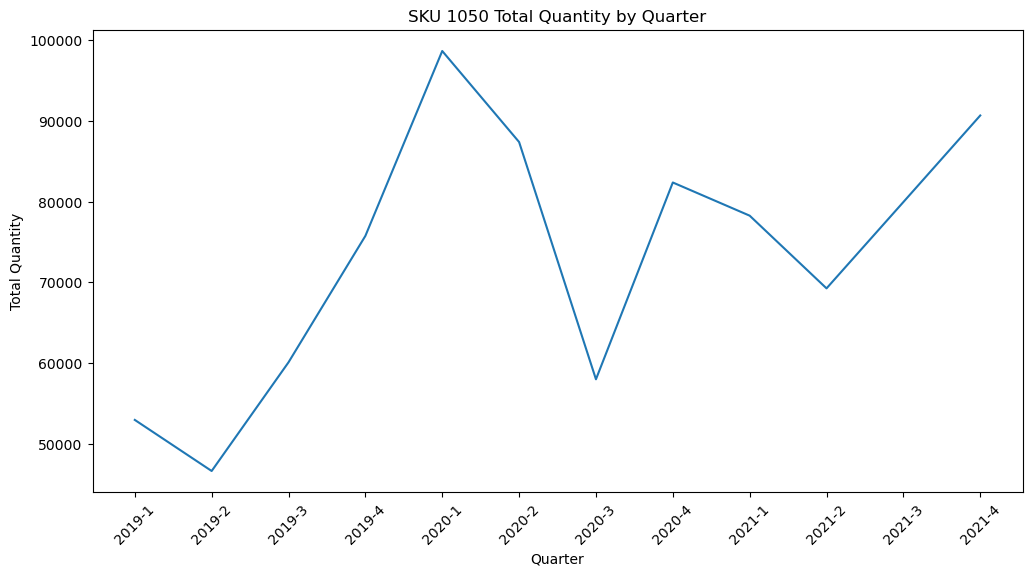

SKU 319
Year  Quarter
2019  1          46823
      2          42588
      3          42818
      4          49943
2020  1          56466
      2          49173
      3          50841
      4          59334
2021  1          62174
      2          53335
      3          52102
      4          76375
Name: TotalQuantity, dtype: int64


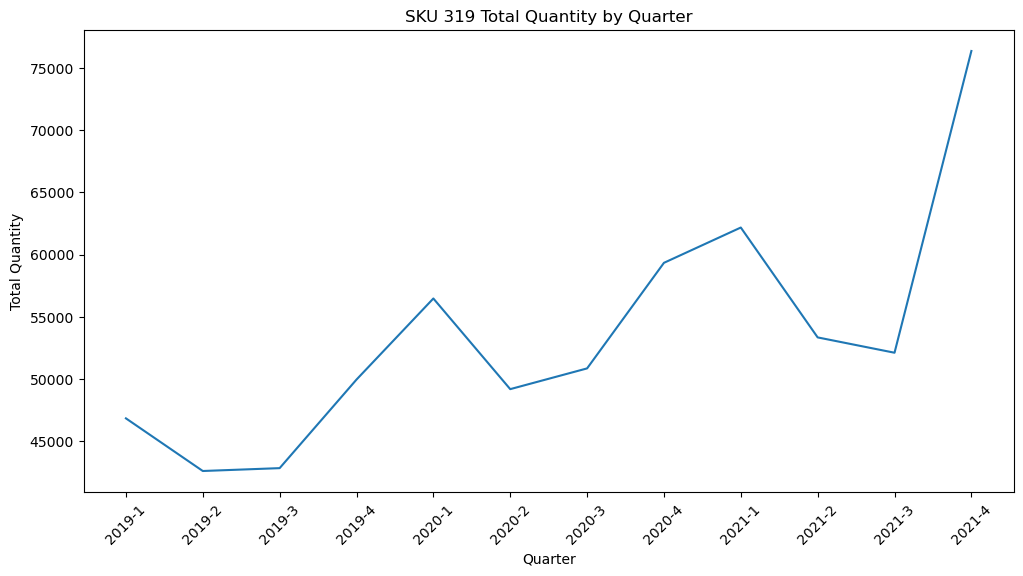

SKU 509
Year  Quarter
2019  1          43084
      2          35255
      3          30328
      4          35910
2020  1          39070
      2          40373
      3          32375
      4          34871
2021  1          38401
      2          32529
      3          30596
      4          36852
Name: TotalQuantity, dtype: int64


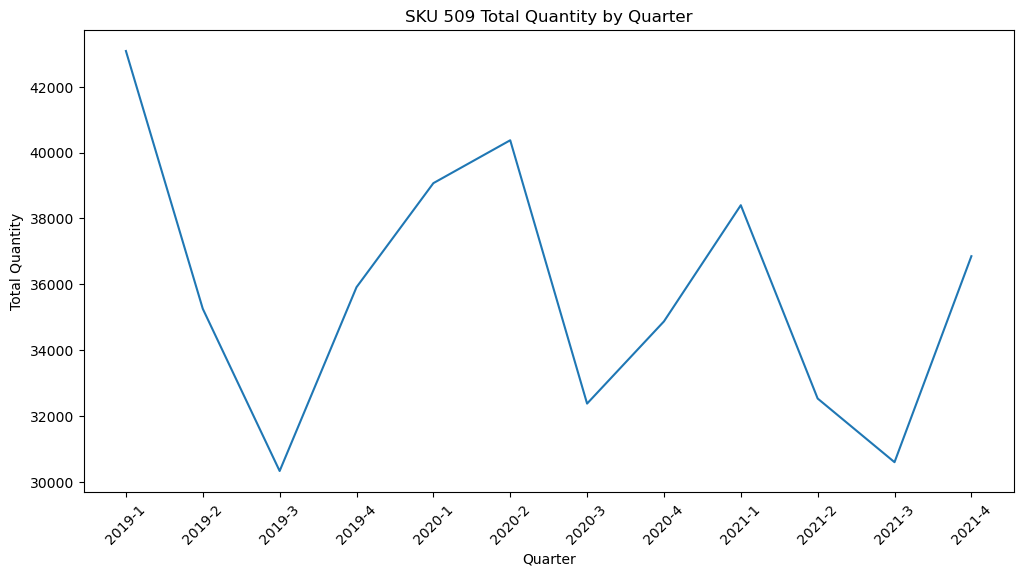

SKU 615
Year  Quarter
2019  1          37197
      2          32159
      3          26647
      4          31652
2020  1          36366
      2          39597
      3          35966
      4          35007
2021  1          39269
      2          32296
      3          27608
      4          36842
Name: TotalQuantity, dtype: int64


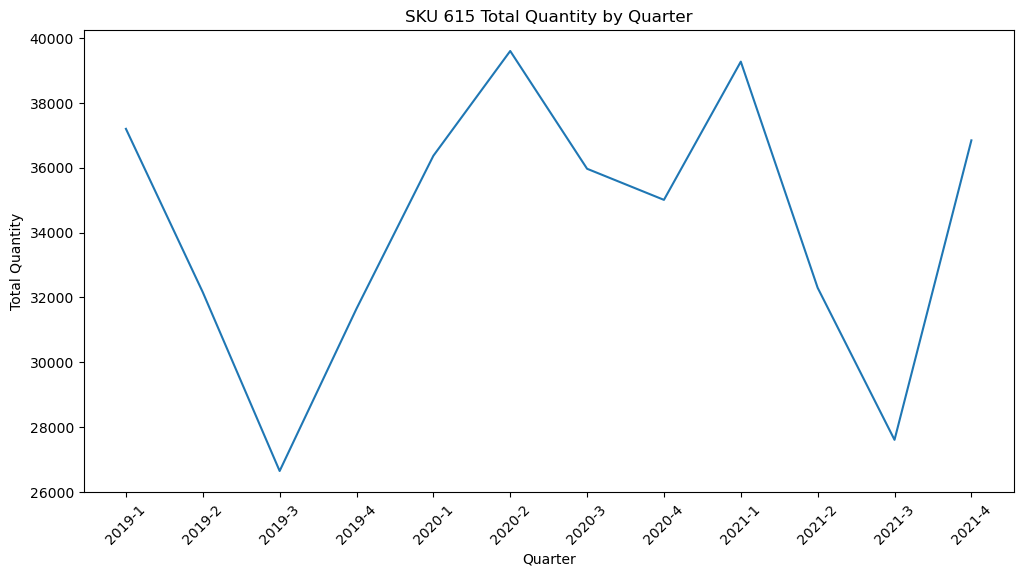

SKU 1018
Year  Quarter
2019  1          13937
      2          12767
      3          11758
      4          14721
2020  1          16743
      2          16719
      3          14319
      4          16976
2021  1          19435
      2          15390
      3          14559
      4          19213
Name: TotalQuantity, dtype: int64


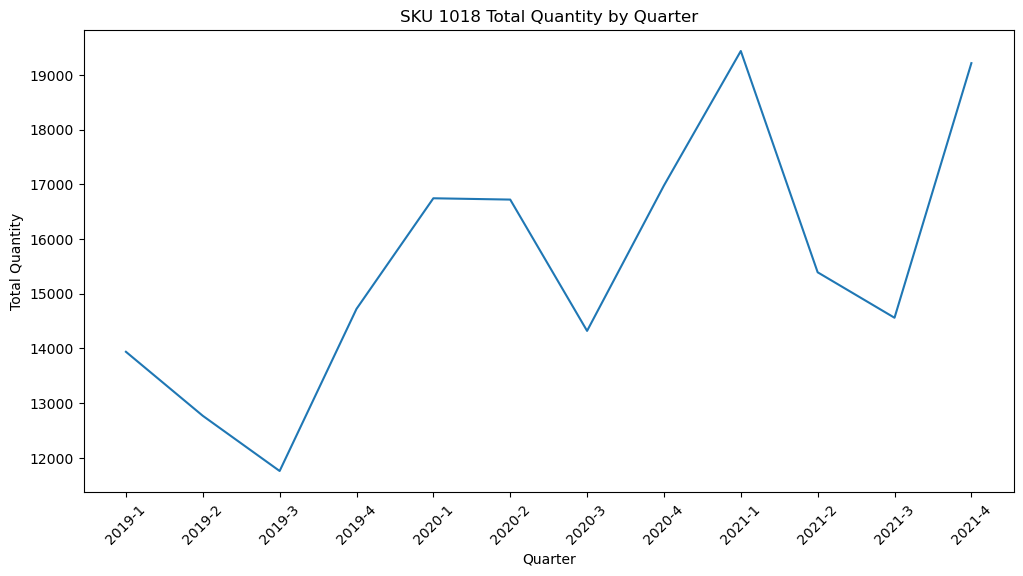

In [11]:
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Quarter'], inplace=True)
    print(sku_data['TotalQuantity'])
    plot_sku(sku_id)

Control these:
- Trend 
- Seasonality
- Cyclical
- Random

In [12]:
quarterly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           84 non-null     int64 
 1   Quarter        84 non-null     int64 
 2   SkuID          84 non-null     object
 3   TotalQuantity  84 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.8+ KB


SKU 568


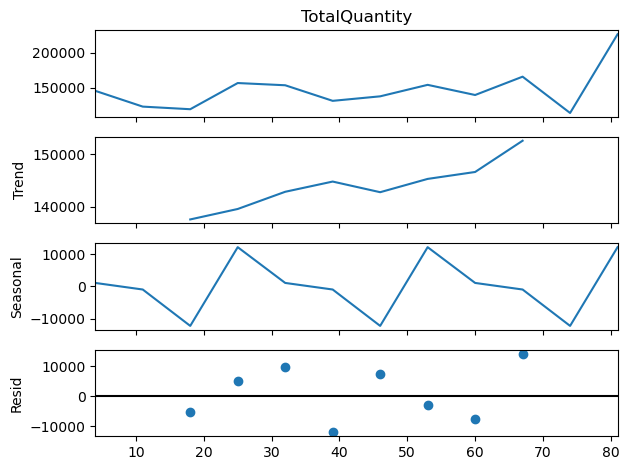

SKU 578


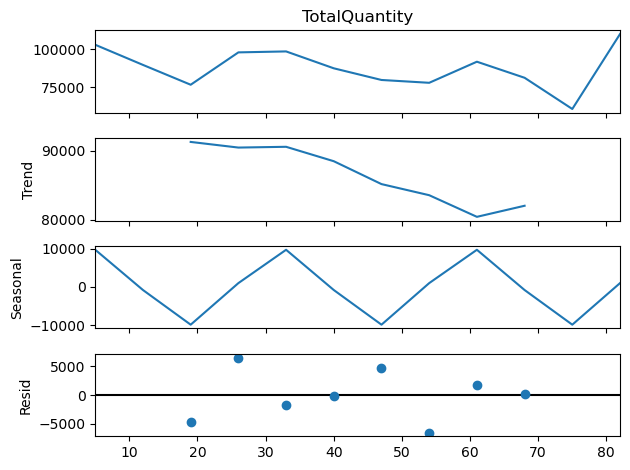

SKU 1050


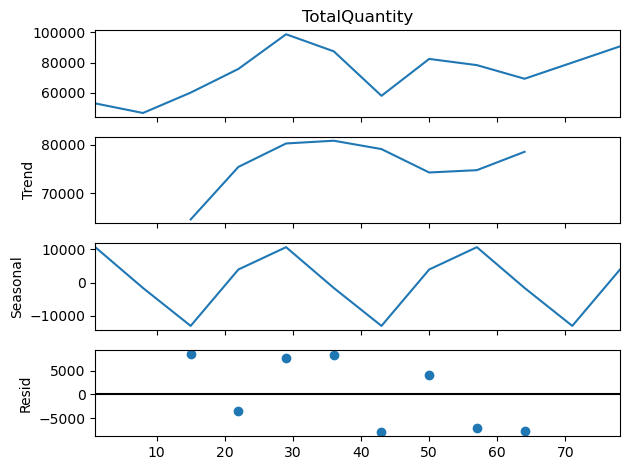

SKU 319


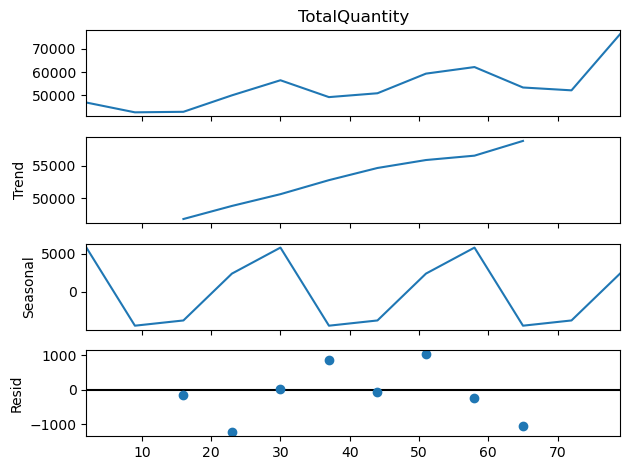

SKU 509


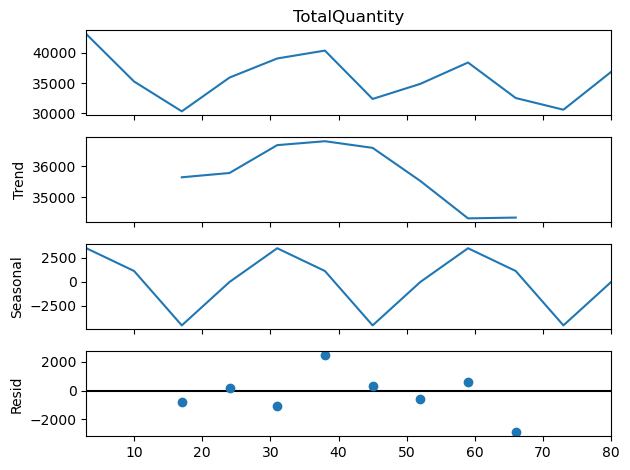

SKU 615


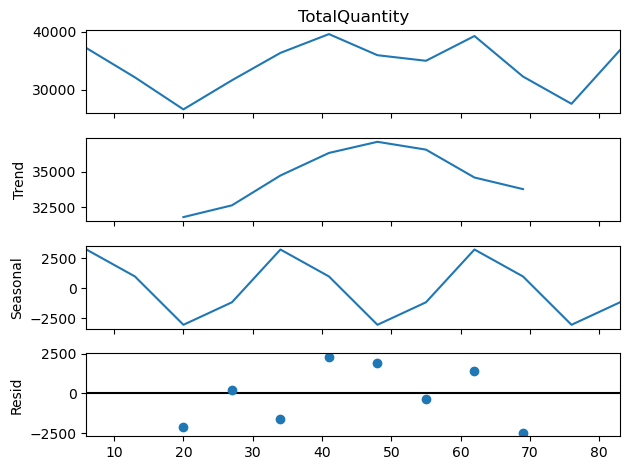

SKU 1018


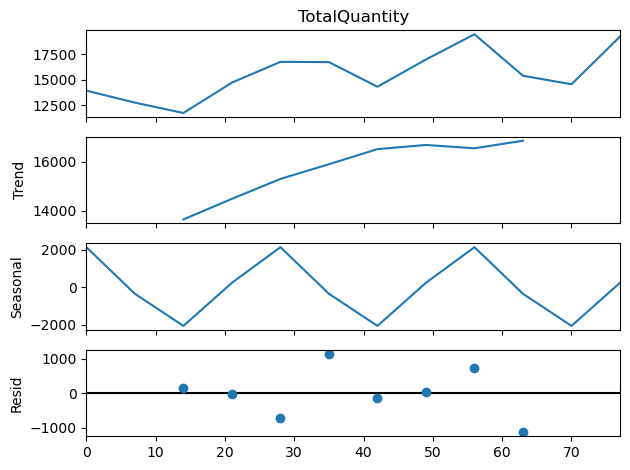

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=4)
    result.plot()
    plt.show()

## Forecasting

### Exponential Smoothing

In [14]:
def calculate_metrics(actual, forecast):
    mape = (abs(forecast - actual) / actual).mean()
    mse = ((forecast - actual) ** 2).mean()
    rmse = mse ** 0.5
    bias = (forecast - actual).mean()
    mad = (abs(forecast - actual)).mean()
    return mape, mse, rmse, bias, mad

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

exponential_smoothing_forecast = []

def forecast_sku_ExponentialSmoothing(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=4).fit()
    forecast = model.forecast(4)
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})
    
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    exponential_smoothing_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})

    
    print(f'SKU {sku_id} Exponential Smoothing Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAD: {mad}')
    print('===============\n')

In [16]:
for sku_id in all_sku_ids:
    forecast_sku_ExponentialSmoothing(sku_id)

SKU 568 Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            152094  139976 -12118
     2            129495  165927  36432
     3            128604  114512 -14092
     4            159160  225966  66806

MAPE: 0.1812115014565409
MSE: 1533940662.0
RMSE: 39165.55453456519
MAD: 32362.0

SKU 578 Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             98056   91852  -6204
     2             85657   81332  -4325
     3             74441   60905 -13536
     4             88908  109939  21031

MAPE: 0.13356632389693576
MSE: 170680374.5
RMSE: 13064.469928014683
MAD: 11274.0

SKU 1050 Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             64242   78269  14027
     2             57915   69268  11353
     3             71369   79958   8589
     4             87021   90674  

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to c

In [17]:
exponential_smoothing_forecast = pd.DataFrame(exponential_smoothing_forecast)
exponential_smoothing_forecast.set_index('sku_id', inplace=True)
exponential_smoothing_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.181  1.533941e+09  39165.555 -19257.00  32362.00
578     0.134  1.706804e+08  13064.470    758.50  11274.00
1050    0.123  1.031907e+08  10158.281  -9405.50   9405.50
319     0.079  8.609675e+07   9278.834  -5668.25   5668.25
509     0.060  7.612652e+06   2759.103   1560.00   2155.00
615     0.124  2.088601e+07   4570.121   2976.75   3861.75
1018    0.076  2.577900e+06   1605.584   -659.00   1373.50

### Moving Average

Moving average is a simple forecasting method that calculates the average of the previous n observations. It is used to smooth out short-term fluctuations and highlight longer-term trends or cycles.

#### How to determine the period of the moving average?

First, we need to determine the period of the moving average. We can use the Mean Absolute Percentage Error (MAPE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and bias to evaluate the performance of the moving average method. 

The period with the lowest MAPE, MSE, RMSE, and bias values will be the best period for the moving average method.

<hr />

#### RMSE (Root Mean Squared Error)
RMSE gives you the average error of the model in predicting the outcome for each observation. Lower RMSE values indicate better fit between predicted and actual values. It's particularly useful because it provides a measure of how much the model's predictions deviate from the actual values on average.





In [18]:
import numpy as np

def moving_average_forecast_list(data, window_size):
    forecast = []
    for i in range(len(data) - window_size + 1):
        forecast.append(np.mean(data[i:i+window_size]))
    return forecast

def find_best_window_size(data, min_window=2, max_window=None):
    if max_window is None:
        max_window = len(data) // 2

    best_score = float('inf')
    best_window = None
    
    results = []

    for window_size in range(min_window, max_window + 1):
        forecast = moving_average_forecast_list(data, window_size)
        # Align forecast with actual data
        forecast = [None] * (window_size - 1) + forecast
        mape, mse, rmse, bias, mad = calculate_metrics(data[window_size - 1:], forecast[window_size - 1:])
        results.append({'window': window_size, 'mape': mape, 'mse': mse, 'rmse': rmse, 'bias': bias, 'mad': mad})
        score = mape
        if score < best_score:
            best_score = score
            best_window = window_size
            
    results = pd.DataFrame(results)
    results.set_index('window', inplace=True)
    print(results)

    return best_window

In [19]:
sku_data = quarterly_data[quarterly_data['SkuID'] == '568']

best_window = find_best_window_size(sku_data['TotalQuantity'], min_window=2, max_window=6)
best_window

            mape           mse          rmse         bias           mad
window                                                                 
2       0.090404  4.235229e+08  20579.671058 -3640.318182  14280.500000
3       0.110709  5.279329e+08  22976.791205 -5783.033333  17494.500000
4       0.117427  6.817981e+08  26111.264539 -8899.166667  19147.833333
5       0.109405  7.258868e+08  26942.285756 -8477.375000  18248.775000
6       0.117981  8.698996e+08  29494.060682 -8833.023810  19969.690476


2

In [20]:
moving_average_forecast = []

def forecast_sku_MovingAverage(sku_id):
    # make 2 period moving average forecast
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    forecast = train.rolling(window=best_window).mean().values[-1]
    forecast = forecast.astype(int)
    
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual':
                                test.values, 'Error': test.values - forecast})
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    
    moving_average_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    print(f'SKU {sku_id} Moving Average Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')

In [21]:
for sku_id in all_sku_ids:
    forecast_sku_MovingAverage(sku_id)

SKU 568 Moving Average Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            146227  139976  -6251
     2            146227  165927  19700
     3            146227  114512 -31715
     4            146227  225966  79739

MAPE: 0.19830574022096692
MSE: 1947828586.75
RMSE: 44134.211069758574

SKU 578 Moving Average Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             78970   91852  12882
     2             78970   81332   2362
     3             78970   60905 -18065
     4             78970  109939  30969

MAPE: 0.18689771571995806
MSE: 364237038.5
RMSE: 19084.99511396322

SKU 1050 Moving Average Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             70193   78269   8076
     2             70193   69268   -925
     3             70193   79958   9765
     4             70193   90674  20481

MAPE: 0.11613456824667501
MSE: 1452259

In [22]:
moving_average_forecast = pd.DataFrame(moving_average_forecast)
moving_average_forecast.set_index('sku_id', inplace=True)
moving_average_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.198  1.947829e+09  44134.211 -15368.25  34351.25
578     0.187  3.642370e+08  19084.995  -7037.00  16069.50
1050    0.116  1.452260e+08  12050.975  -9349.25   9811.75
319     0.121  1.288461e+08  11351.038  -5909.50   8278.00
509     0.086  1.090382e+07   3302.094   -971.50   3032.00
615     0.129  2.209720e+07   4700.766   1482.25   4051.75
1018    0.118  7.078773e+06   2660.596  -1502.25   2174.75

### Naive Forecast

In [23]:
naive_forecast = []

def forecast_sku_Naive(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    forecast = train.iloc[-1]
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})
    
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    naive_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    
    print(f'SKU {sku_id} Naive Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')
    

In [24]:
for sku_id in all_sku_ids:
    forecast_sku_Naive(sku_id)

SKU 568 Naive Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            154361  139976 -14385
     2            154361  165927  11566
     3            154361  114512 -39849
     4            154361  225966  71605

MAPE: 0.20933666399672202
MSE: 1763979851.75
RMSE: 41999.760139196034

SKU 578 Naive Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             78047   91852  13805
     2             78047   81332   3285
     3             78047   60905 -17142
     4             78047  109939  31892

MAPE: 0.19055724982646027
MSE: 378079269.5
RMSE: 19444.26057992435

SKU 1050 Naive Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             82377   78269  -4108
     2             82377   69268 -13109
     3             82377   79958  -2419
     4             82377   90674   8297

MAPE: 0.09087327934514079
MSE: 65853328.75
RMSE: 8115.00639248053

In [25]:
naive_forecast = pd.DataFrame(naive_forecast)
naive_forecast.set_index('sku_id', inplace=True)
naive_forecast

mape           mse       rmse     bias       mad
sku_id                                                   
568     0.209  1.763980e+09  41999.760 -7234.25  34351.25
578     0.191  3.780793e+08  19444.261 -7960.00  16531.00
1050    0.091  6.585333e+07   8115.006  2834.75   6983.25
319     0.130  9.668778e+07   9832.994 -1662.50   8278.00
509     0.089  1.003646e+07   3168.038   276.50   3032.00
615     0.128  2.090665e+07   4572.379  1003.25   4051.75
1018    0.128  4.852034e+06   2202.733  -173.25   2174.75

## Seasonal Forecasting Methods

There are seasonal patterns in the quarterly_data. So, we can use forecasting methods that can capture the seasonality.
- Triple Exponential Smoothing
- ARIMA
- SARIMA

### Triple Exponential Smoothing

In [26]:
triple_exponential_smoothing_forecast = []

def forecast_sku_TripleExponentialSmoothing(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=4, trend='add').fit()
    forecast = model.forecast(4)
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})

    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    # calculate parameters for the forecast exponential smoothing model, alpha, beta, gamma
    
    
    
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    triple_exponential_smoothing_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    print(f'SKU {sku_id} Triple Exponential Smoothing Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')

    

In [27]:
for sku_id in all_sku_ids:
    forecast_sku_TripleExponentialSmoothing(sku_id)

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to c

SKU 568 Triple Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            161709  139976 -21733
     2            139646  165927  26281
     3            145978  114512 -31466
     4            172791  225966  53175

MAPE: 0.20593942569113707
MSE: 1245176007.75
RMSE: 35287.05155931847

SKU 578 Triple Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             94644   91852  -2792
     2             81172   81332    160
     3             68392   60905  -7487
     4             87178  109939  22761

MAPE: 0.09058152837787799
MSE: 145484788.5
RMSE: 12061.70752837259

SKU 1050 Triple Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            121266   78269 -42997
     2            109904   69268 -40636
     3             80652   79958   -694
     4            121213   90674 -3053

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A

SKU 1018 Triple Exponential Smoothing Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             18817   19435    618
     2             18107   15390  -2717
     3             16322   14559  -1763
     4             19018   19213    195

MAPE: 0.08489609290735642
MSE: 2727551.75
RMSE: 1651.5301238548452



/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [28]:
triple_exponential_smoothing_forecast = pd.DataFrame(triple_exponential_smoothing_forecast)
triple_exponential_smoothing_forecast.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.206  1.245176e+09  35287.052  -6564.25  33163.75
578     0.091  1.454848e+08  12061.708  -3160.50   8300.00
1050    0.370  1.108285e+09  33290.910  28716.50  28716.50
319     0.079  4.621449e+07   6798.124  -2875.50   5248.00
509     0.075  1.094344e+07   3308.086   2549.00   2592.50
615     0.164  3.077551e+07   5547.568   5286.00   5286.00
1018    0.085  2.727552e+06   1651.530    916.75   1323.25

### ARIMA

In [29]:
from statsmodels.tsa.arima.model import ARIMA

arima_forecast = []

def forecast_sku_ARIMA(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    model = ARIMA(train, order=(1, 1, 1)).fit()
    forecast = model.forecast(steps=4)
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    arima_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    print(f'SKU {sku_id} ARIMA Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')
    

In [30]:
for sku_id in all_sku_ids:
    forecast_sku_ARIMA(sku_id)

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An

SKU 568 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            151601  139976 -11625
     2            151457  165927  14470
     3            151450  114512 -36938
     4            151449  225966  74517

MAPE: 0.20564916010672687
MSE: 1815430164.5
RMSE: 42607.86505447087

SKU 578 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             79021   91852  12831
     2             79245   81332   2087
     3             79296   60905 -18391
     4             79308  109939  30631

MAPE: 0.18648314624826967
MSE: 361369293.0
RMSE: 19009.715752740754

SKU 1050 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             80114   78269  -1845
     2             80143   69268 -10875
     3             80142   79958   -184
     4             80142   90674  10532

MAPE: 0.07475625801232283
MSE: 58156632.5
RMSE: 7626.049599891152


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No

In [31]:
arima_forecast = pd.DataFrame(arima_forecast)
arima_forecast.set_index('sku_id', inplace=True)
arima_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.206  1.815430e+09  42607.865 -10106.00  34387.50
578     0.186  3.613693e+08  19009.716  -6789.50  15985.00
1050    0.075  5.815663e+07   7626.050    593.00   5859.00
319     0.128  1.000076e+08  10000.378  -2469.75   8269.75
509     0.088  1.961854e+07   4429.282  -3246.00   3281.50
615     0.121  1.885622e+07   4342.375   -714.75   4034.75
1018    0.125  5.015902e+06   2239.621   -480.75   2166.75

### SARIMA

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_forecast = []

def forecast_sku_SARIMA(sku_id):
    sku_data = quarterly_data[quarterly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-4]
    test = sku_data['TotalQuantity'][-4:]
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)).fit()
    forecast = model.forecast(steps=4)
    forecast = forecast.astype(int)
    forecast_table = pd.DataFrame({'Year': [2020, 2020, 2020, 2020], 'Quarter': [1, 2, 3, 4], 'Forecasted': forecast, 'Actual': 
                                test.values, 'Error': test.values - forecast})
    forecast_table.set_index(['Year', 'Quarter'], inplace=True)
    
    mape, mse, rmse, bias, mad = calculate_metrics(test.values, forecast)
    
    # store the SARIMA forecast values in the sarima_forecast table to compare with other forecasting methods
    sarima_forecast.append({'sku_id': sku_id, 'mape': round(mape, 3), 'mse': round(mse, 3), 'rmse': round(rmse, 3), 'bias': round(bias, 3), 'mad': round(mad, 3)})
    
    print('===============\n')
    print(f'SKU {sku_id} ARIMA Forecast'f'\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print('===============\n')


In [33]:
for sku_id in all_sku_ids:
    forecast_sku_SARIMA(sku_id)
    

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10786D+00    |proj g|=  8.11347D-01

At iterate    5    f=  3.88460D+00    |proj g|=  6.49146D-02


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   10    f=  3.84702D+00    |proj g|=  7.28310D-02

At iterate   15    f=  3.84303D+00    |proj g|=  1.20687D-02

At iterate   20    f=  3.84285D+00    |proj g|=  1.89468D-03

At iterate   25    f=  3.84283D+00    |proj g|=  3.31901D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   3.319D-05   3.843D+00
  F =   3.8428335294608198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

SKU 568 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            225583  139976 -85607
     2            201570  1659

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



At iterate   35    f=  4.19674D+00    |proj g|=  1.18567D-04

At iterate   40    f=  4.19673D+00    |proj g|=  4.04385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     60      1     0     0   2.169D-05   4.197D+00
  F =   4.1967338110488166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

SKU 1050 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1            138132   78269 -59863
     2            128629   69268 -59361
     3            134543   79958 -54585
     4            156816   90674 -66142

MAPE: 0.7584829282174564
MSE: 36

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   35    f=  3.56060D+00    |proj g|=  2.66863D-02

At iterate   40    f=  3.54618D+00    |proj g|=  5.82102D-02

At iterate   45    f=  3.35549D+00    |proj g|=  1.73097D-01

At iterate   50    f=  3.13345D+00    |proj g|=  1.82780D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     79      1     0     0   1.828D+00   3.133D+00
  F =   3.1334473556709836     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

SKU 509 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             47640   38401  -9239
     2             44535   325

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/sta


At iterate   50    f=  2.96271D+00    |proj g|=  1.40652D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   1.407D-01   2.963D+00
  F =   2.9627149244760700     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

SKU 615 ARIMA Forecast

              Forecasted  Actual  Error
Year Quarter                           
2020 1             53288   39269 -14019
     2             50934   32296 -18638
     3             45311   27608 -17703
     4             50365   36842 -13523

MAPE: 0.48559489430616914
MSE: 260043785.75
RMSE: 16125.873177908848

RUNNING THE L-BFGS-B CODE

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [34]:
sarima_forecast = pd.DataFrame(sarima_forecast)
sarima_forecast.set_index('sku_id', inplace=True)
sarima_forecast

mape           mse       rmse      bias       mad
sku_id                                                    
568     0.407  4.154596e+09  64456.156  53753.50  53753.50
578     0.699  3.414105e+09  58430.342  55476.25  55476.25
1050    0.758  3.615398e+09  60128.183  59987.75  59987.75
319     0.126  1.075144e+08  10368.917  -8360.50   8360.50
509     0.244  7.613258e+07   8725.398   8373.25   8373.25
615     0.486  2.600438e+08  16125.873  15970.75  15970.75
1018    0.161  8.812714e+06   2968.622   2536.25   2536.25

# Quarterly: Comparison of Forecasting Methods

## Bias = (Actual - Forecasted) / n 
 Bias is the average of the differences between the forecasted values and the actual values. It is a measure of the accuracy of the forecasting method. The closer the bias value is to zero, the more accurate the forecasting method is.


In [35]:
all_forecasts_bias = pd.concat([exponential_smoothing_forecast['bias'], moving_average_forecast['bias'], naive_forecast['bias'], triple_exponential_smoothing_forecast['bias'], arima_forecast['bias'], sarima_forecast['bias']], axis=1)
all_forecasts_bias.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']
all_forecasts_bias

Exponential Smoothing  Moving Average    Naive  \
sku_id                                                   
568                 -19257.00       -15368.25 -7234.25   
578                    758.50        -7037.00 -7960.00   
1050                 -9405.50        -9349.25  2834.75   
319                  -5668.25        -5909.50 -1662.50   
509                   1560.00         -971.50   276.50   
615                   2976.75         1482.25  1003.25   
1018                  -659.00        -1502.25  -173.25   

        Triple Exponential Smoothing     ARIMA    SARIMA  
sku_id                                                    
568                         -6564.25 -10106.00  53753.50  
578                         -3160.50  -6789.50  55476.25  
1050                        28716.50    593.00  59987.75  
319                         -2875.50  -2469.75  -8360.50  
509                          2549.00  -3246.00   8373.25  
615                          5286.00   -714.75  15970.75  
1018                          916.75   -480.75   2536.25

<Figure size 1200x600 with 0 Axes>

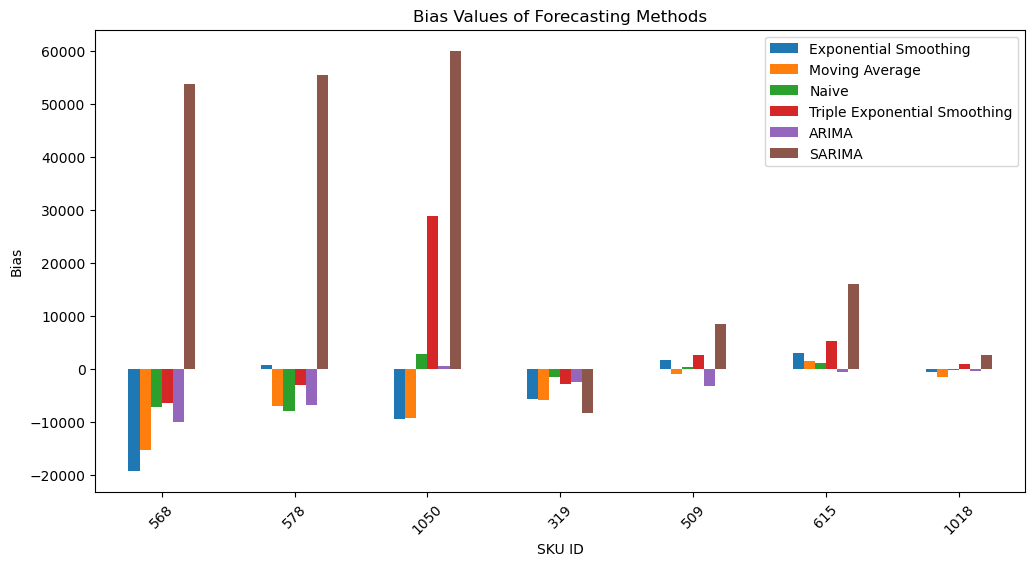

In [36]:
# Plot bias values of the forecasting methods
plt.figure(figsize=(12, 6))
all_forecasts_bias.plot(kind='bar', figsize=(12, 6))
plt.title('Bias Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.show()


## MAPE = (|Actual - Forecasted| / Actual) / n

MAPE is the average of the absolute percentage differences between the forecasted values and the actual values. It is a measure of the prediction accuracy of a forecasting method. The lower the MAPE value, the more accurate the forecasting method is.

In [37]:
all_forecasts_mape = pd.concat([exponential_smoothing_forecast['mape'], moving_average_forecast['mape'], naive_forecast['mape'], triple_exponential_smoothing_forecast['mape'], arima_forecast['mape'], sarima_forecast['mape']], axis=1)
all_forecasts_mape.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']
all_forecasts_mape

Exponential Smoothing  Moving Average  Naive  \
sku_id                                                 
568                     0.181           0.198  0.209   
578                     0.134           0.187  0.191   
1050                    0.123           0.116  0.091   
319                     0.079           0.121  0.130   
509                     0.060           0.086  0.089   
615                     0.124           0.129  0.128   
1018                    0.076           0.118  0.128   

        Triple Exponential Smoothing  ARIMA  SARIMA  
sku_id                                               
568                            0.206  0.206   0.407  
578                            0.091  0.186   0.699  
1050                           0.370  0.075   0.758  
319                            0.079  0.128   0.126  
509                            0.075  0.088   0.244  
615                            0.164  0.121   0.486  
1018                           0.085  0.125   0.161

<Figure size 1200x600 with 0 Axes>

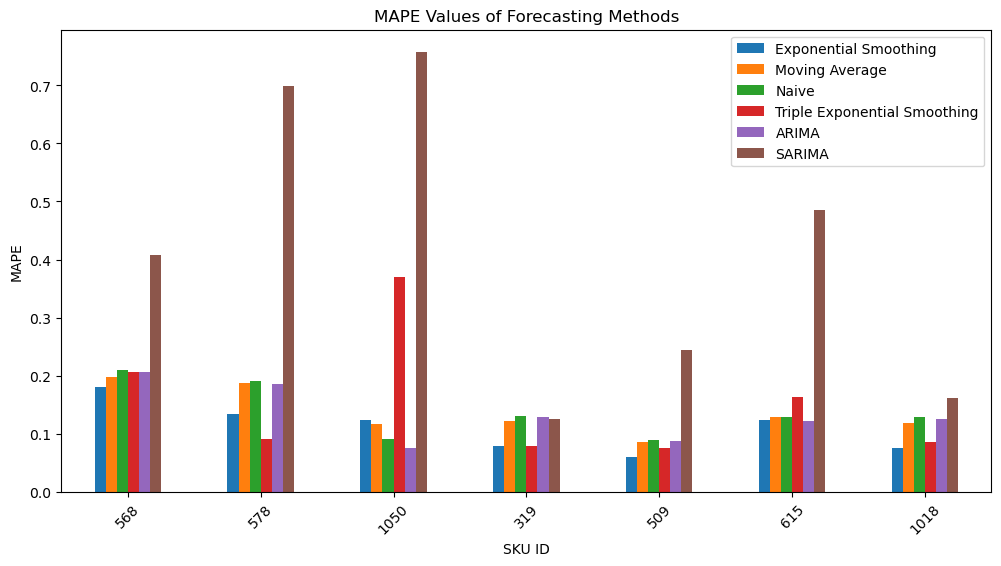

In [38]:
# Plot MAPE values of the forecasting methods
plt.figure(figsize=(12, 6))
all_forecasts_mape.plot(kind='bar', figsize=(12, 6))
plt.title('MAPE Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.show()

## MAD = |Actual - Forecasted| / n

MAD is the average of the absolute differences between the forecasted values and the actual values. It is a measure of the accuracy of the forecasting method. The lower the MAD value, the more accurate the forecasting method is.

In [39]:
all_forecasts_mad = pd.concat([exponential_smoothing_forecast['mad'], moving_average_forecast['mad'], naive_forecast['mad'], triple_exponential_smoothing_forecast['mad'], arima_forecast['mad'], sarima_forecast['mad']], axis=1)

all_forecasts_mad.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']
all_forecasts_mad

Exponential Smoothing  Moving Average     Naive  \
sku_id                                                    
568                  32362.00        34351.25  34351.25   
578                  11274.00        16069.50  16531.00   
1050                  9405.50         9811.75   6983.25   
319                   5668.25         8278.00   8278.00   
509                   2155.00         3032.00   3032.00   
615                   3861.75         4051.75   4051.75   
1018                  1373.50         2174.75   2174.75   

        Triple Exponential Smoothing     ARIMA    SARIMA  
sku_id                                                    
568                         33163.75  34387.50  53753.50  
578                          8300.00  15985.00  55476.25  
1050                        28716.50   5859.00  59987.75  
319                          5248.00   8269.75   8360.50  
509                          2592.50   3281.50   8373.25  
615                          5286.00   4034.75  15970.75  
1018                         1323.25   2166.75   2536.25

<Figure size 1200x600 with 0 Axes>

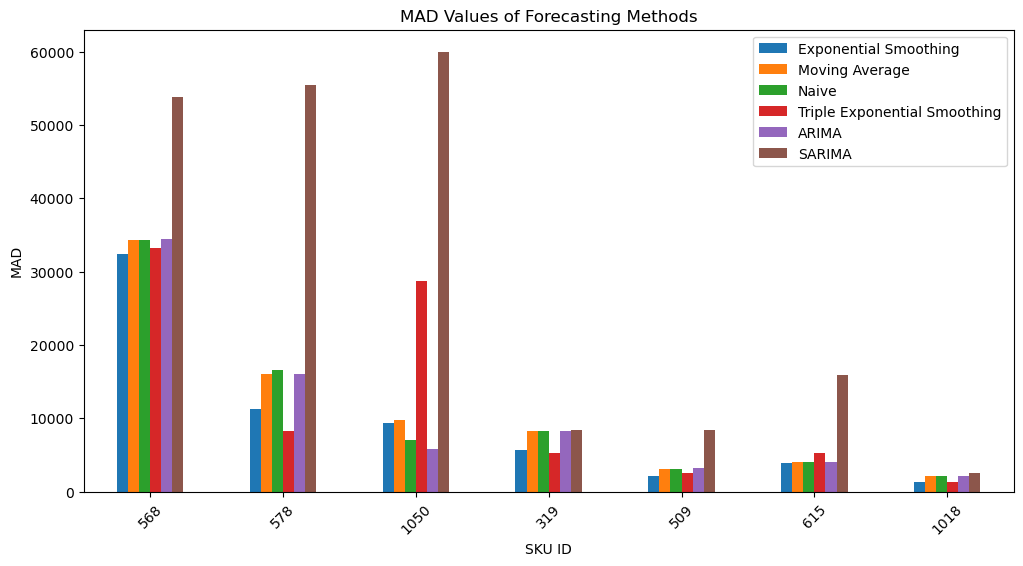

In [40]:
# Plot MAD values of the forecasting methods
plt.figure(figsize=(12, 6))
all_forecasts_mad.plot(kind='bar', figsize=(12, 6))
plt.title('MAD Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAD')
plt.xticks(rotation=45)
plt.show()

## All Metrics Comparison

In [41]:
all_forecasts = pd.concat([exponential_smoothing_forecast, moving_average_forecast, naive_forecast, triple_exponential_smoothing_forecast, arima_forecast, sarima_forecast], axis=1)

# Define the forecasting methods
methods = [
    "exponential_smoothing",
    "moving_average",
    "naive",
    "triple_exponential_smoothing",
    "arima",
    "sarima"
]

# Define the metrics
metrics = ["mape", "mse", "rmse", "bias", "mad"]

# Create new column names
new_column_names = [f"{method}_{metric}" for method in methods for metric in metrics]

# Update the column names
all_forecasts.columns = new_column_names

all_forecasts

exponential_smoothing_mape  exponential_smoothing_mse  \
sku_id                                                          
568                          0.181               1.533941e+09   
578                          0.134               1.706804e+08   
1050                         0.123               1.031907e+08   
319                          0.079               8.609675e+07   
509                          0.060               7.612652e+06   
615                          0.124               2.088601e+07   
1018                         0.076               2.577900e+06   

        exponential_smoothing_rmse  exponential_smoothing_bias  \
sku_id                                                           
568                      39165.555                   -19257.00   
578                      13064.470                      758.50   
1050                     10158.281                    -9405.50   
319                       9278.834                    -5668.25   
509                       2759.103                     1560.00   
615                       4570.121                     2976.75   
1018                      1605.584                     -659.00   

        exponential_smoothing_mad  moving_average_mape  moving_average_mse  \
sku_id                                                                       
568                      32362.00                0.198        1.947829e+09   
578                      11274.00                0.187        3.642370e+08   
1050                      9405.50                0.116        1.452260e+08   
319                       5668.25                0.121        1.288461e+08   
509                       2155.00                0.086        1.090382e+07   
615                       3861.75                0.129        2.209720e+07   
1018                      1373.50                0.118        7.078773e+06   

        moving_average_rmse  moving_average_bias  moving_average_mad  ...  \
sku_id                                                                ...   
568               44134.211            -15368.25            34351.25  ...   
578               19084.995             -7037.00            16069.50  ...   
1050              12050.975             -9349.25             9811.75  ...   
319               11351.038             -5909.50             8278.00  ...   
509                3302.094              -971.50             3032.00  ...   
615                4700.766              1482.25             4051.75  ...   
1018               2660.596             -1502.25             2174.75  ...   

        arima_mape     arima_mse  arima_rmse  arima_bias  arima_mad  \
sku_id                                                                
568          0.206  1.815430e+09   42607.865   -10106.00   34387.50   
578          0.186  3.613693e+08   19009.716    -6789.50   15985.00   
1050         0.075  5.815663e+07    7626.050      593.00    5859.00   
319          0.128  1.000076e+08   10000.378    -2469.75    8269.75   
509          0.088  1.961854e+07    4429.282    -3246.00    3281.50   
615          0.121  1.885622e+07    4342.375     -714.75    4034.75   
1018         0.125  5.015902e+06    2239.621     -480.75    2166.75   

        sarima_mape    sarima_mse  sarima_rmse  sarima_bias  sarima_mad  
sku_id                                                                   
568           0.407  4.154596e+09    64456.156     53753.50    53753.50  
578           0.699  3.414105e+09    58430.342     55476.25    55476.25  
1050          0.758  3.615398e+09    60128.183     59987.75    59987.75  
319           0.126  1.075144e+08    10368.917     -8360.50     8360.50  
509           0.244  7.613258e+07     8725.398      8373.25     8373.25  
615           0.486  2.600438e+08    16125.873     15970.75    15970.75  
1018          0.161  8.812714e+06     2968.622      2536.25     2536.25  

[7 rows x 30 columns]

# Monthly Sales Analysis

Calculate the total sales of the choosen SKU's for monthly. It should be 36 rows in total for every SKU.

In [42]:
monthly_data = data.copy()

monthly_data['Year'] = monthly_data['Date'].dt.year
monthly_data['Month'] = monthly_data['Date'].dt.month

monthly_data = monthly_data.groupby(['Year', 'Month', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
monthly_data

Year  Month SkuID  TotalQuantity
0    2019      1  1018           4559
1    2019      1  1050          19893
2    2019      1   319          16316
3    2019      1   509          13993
4    2019      1   568          54068
..    ...    ...   ...            ...
247  2021     12   319          28037
248  2021     12   509          13327
249  2021     12   568          54617
250  2021     12   578          27257
251  2021     12   615          12425

[252 rows x 4 columns]

In [43]:
# Plot SKU sales for each month

def plot_sku_monthly(sku_id):
    sku = monthly_data[monthly_data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    plt.plot(sku.index, sku['TotalQuantity'])
    plt.title(f'SKU {sku_id} Total Quantity by Month')
    plt.xlabel('Month')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.show()

SKU 568
Year  Month
2019  1         54068
      2         56115
      3         35696
      4         40855
      5         51793
      6         30889
      7         40455
      8         35839
      9         43548
      10        46278
      11        59636
      12        51000
2020  1         71126
      2         45135
      3         37509
      4         36699
      5         44420
      6         50590
      7         42860
      8         44094
      9         51139
      10        70269
      11        42701
      12        41391
2021  1         58456
      2         42867
      3         38653
      4         43395
      5         40054
      6         82478
      7         32898
      8         30591
      9         51023
      10        48319
      11       123030
      12        54617
Name: TotalQuantity, dtype: int64


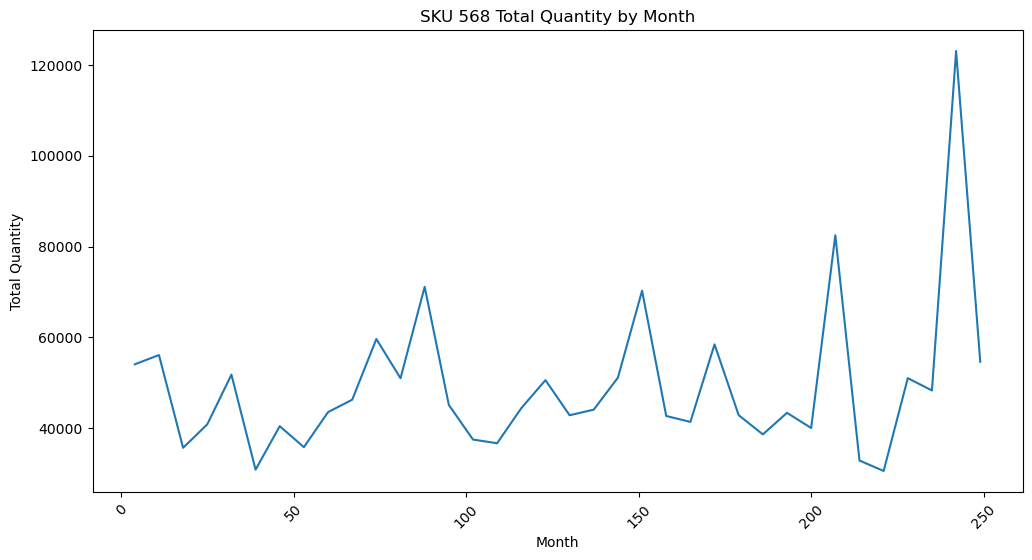

SKU 578
Year  Month
2019  1        35666
      2        39802
      3        27465
      4        33553
      5        30016
      6        26184
      7        26848
      8        22876
      9        27053
      10       33694
      11       30773
      12       33494
2020  1        38044
      2        34863
      3        25678
      4        25633
      5        28195
      6        33705
      7        27462
      8        19633
      9        32799
      10       19690
      11       29633
      12       28724
2021  1        33641
      2        23927
      3        34284
      4        30377
      5        21488
      6        29467
      7        15476
      8        21002
      9        24427
      10       23160
      11       59522
      12       27257
Name: TotalQuantity, dtype: int64


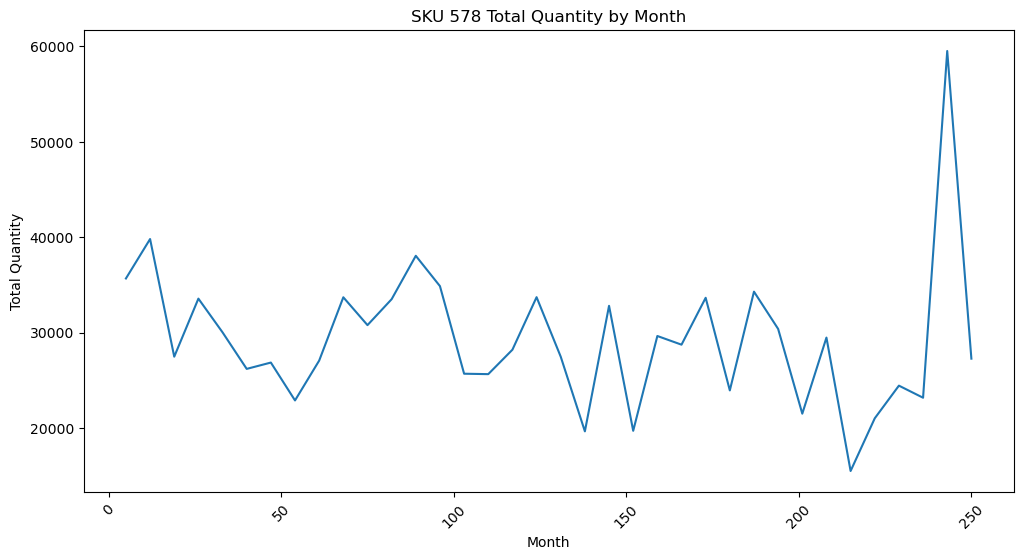

SKU 1050
Year  Month
2019  1        19893
      2        15298
      3        17790
      4        16777
      5        18261
      6        11618
      7        16940
      8        17132
      9        26043
      10       18288
      11       31647
      12       25830
2020  1        54784
      2        14459
      3        29414
      4        27154
      5        31898
      6        28334
      7        15182
      8        19447
      9        23381
      10       32982
      11       20448
      12       28947
2021  1        27512
      2        27942
      3        22815
      4        22999
      5        19766
      6        26503
      7        21951
      8        20913
      9        37094
      10       34359
      11       26593
      12       29722
Name: TotalQuantity, dtype: int64


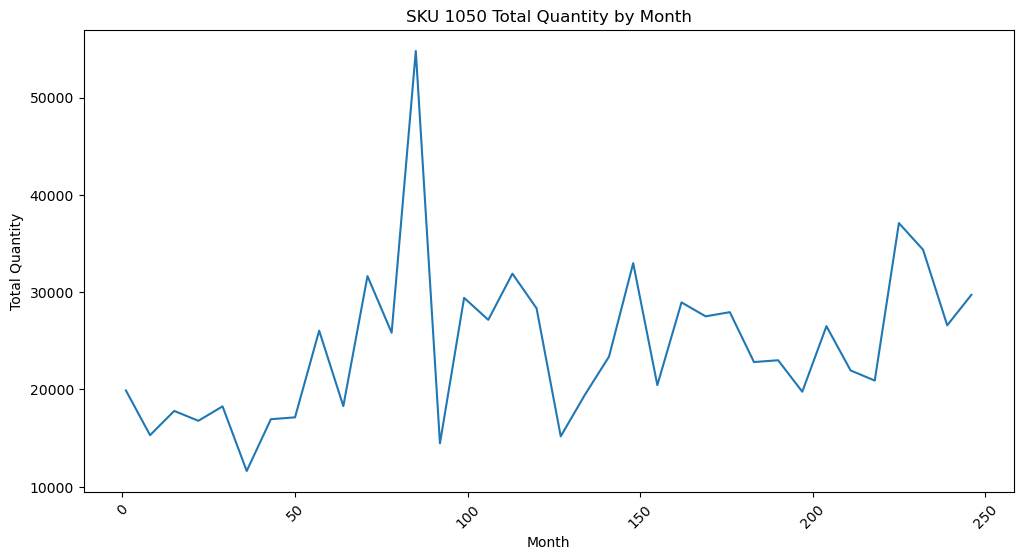

SKU 319
Year  Month
2019  1        16316
      2        16813
      3        13694
      4        14012
      5        16314
      6        12262
      7        14854
      8        13200
      9        14764
      10       15665
      11       16645
      12       17633
2020  1        21996
      2        17211
      3        17259
      4        17299
      5        16052
      6        15822
      7        15129
      8        15004
      9        20708
      10       18154
      11       18771
      12       22409
2021  1        22590
      2        20806
      3        18778
      4        17973
      5        15924
      6        19438
      7        15205
      8        16109
      9        20788
      10       21989
      11       26349
      12       28037
Name: TotalQuantity, dtype: int64


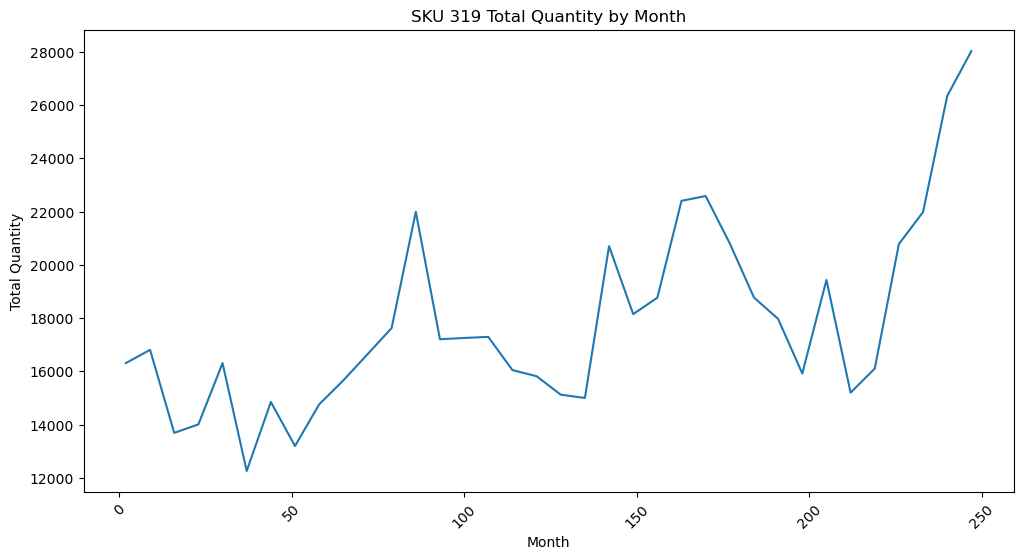

SKU 509
Year  Month
2019  1        13993
      2        13408
      3        15683
      4        10701
      5        12828
      6        11726
      7        10693
      8         8585
      9        11050
      10       11072
      11       11545
      12       13293
2020  1        13762
      2        12131
      3        13177
      4        16035
      5        13774
      6        10564
      7         8945
      8        10448
      9        12982
      10       10441
      11       11564
      12       12866
2021  1        12902
      2        12554
      3        12945
      4        10813
      5         9727
      6        11989
      7         9087
      8         8778
      9        12731
      10       12324
      11       11201
      12       13327
Name: TotalQuantity, dtype: int64


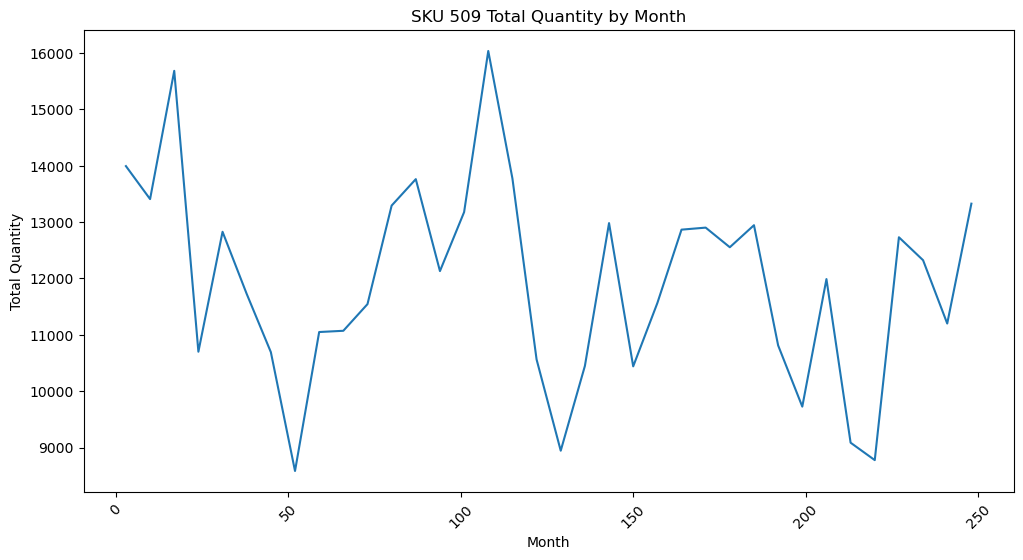

SKU 615
Year  Month
2019  1        11929
      2        13901
      3        11367
      4         9783
      5        12145
      6        10231
      7         9506
      8         7686
      9         9455
      10       11744
      11       10248
      12        9660
2020  1        14921
      2        11332
      3        10113
      4        17199
      5        13219
      6         9179
      7        12133
      8        10295
      9        13538
      10       12495
      11        9427
      12       13085
2021  1        16095
      2        12122
      3        11052
      4        11426
      5         9674
      6        11196
      7         7060
      8         7554
      9        12994
      10       12023
      11       12394
      12       12425
Name: TotalQuantity, dtype: int64


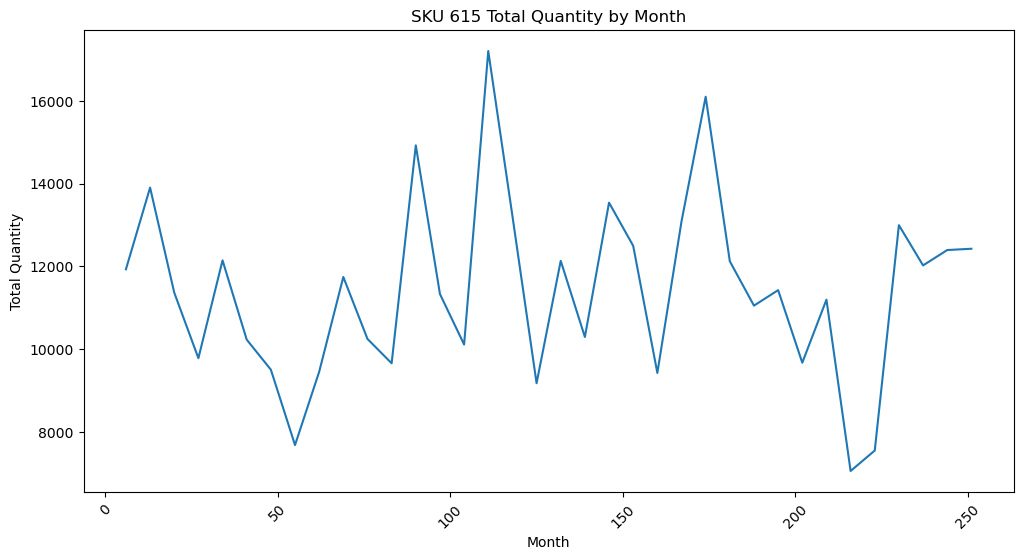

SKU 1018
Year  Month
2019  1        4559
      2        4822
      3        4556
      4        4251
      5        4887
      6        3629
      7        4235
      8        3460
      9        4063
      10       4643
      11       4884
      12       5194
2020  1        6598
      2        5234
      3        4911
      4        6835
      5        5468
      6        4416
      7        3683
      8        4169
      9        6467
      10       4805
      11       5570
      12       6601
2021  1        7145
      2        6714
      3        5576
      4        5188
      5        5011
      6        5191
      7        3765
      8        4199
      9        6595
      10       6168
      11       5995
      12       7050
Name: TotalQuantity, dtype: int64


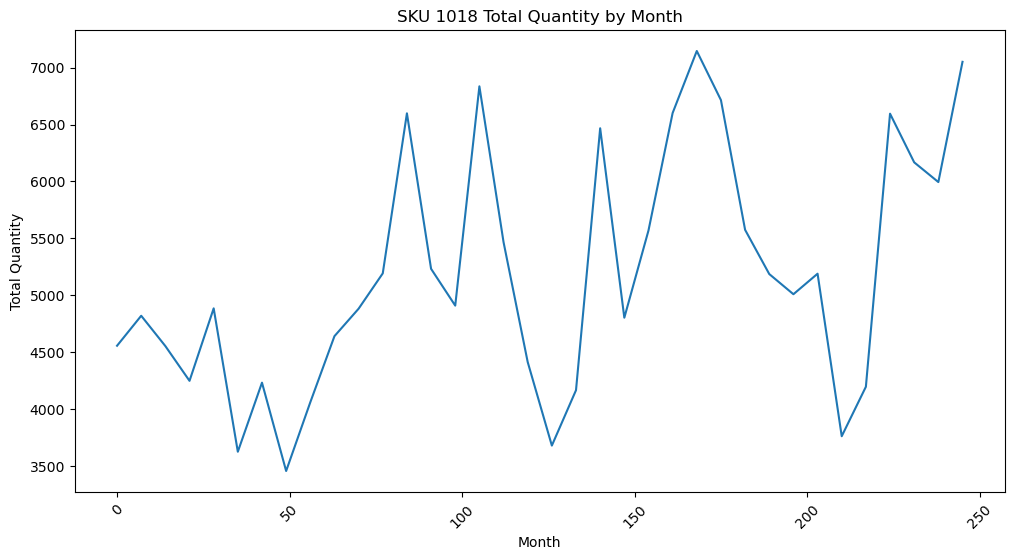

In [44]:
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Month'], inplace=True)
    print(sku_data['TotalQuantity'])
    plot_sku_monthly(sku_id)

SKU 568


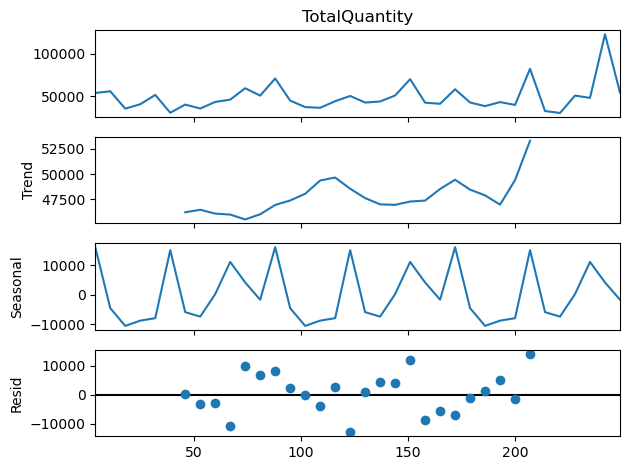

SKU 578


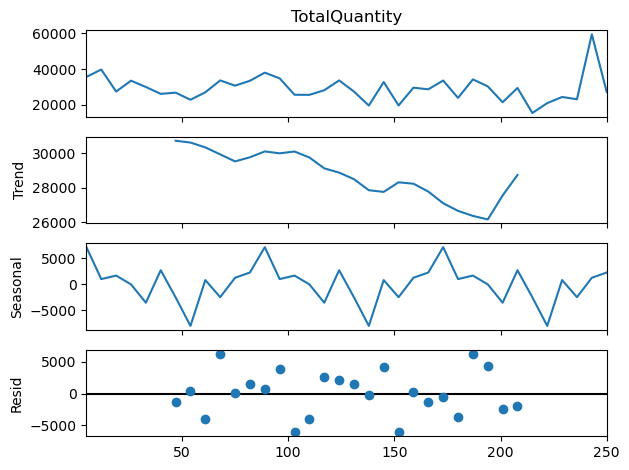

SKU 1050


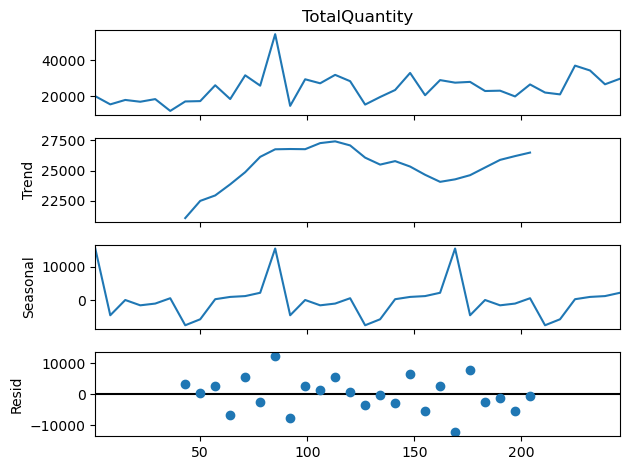

SKU 319


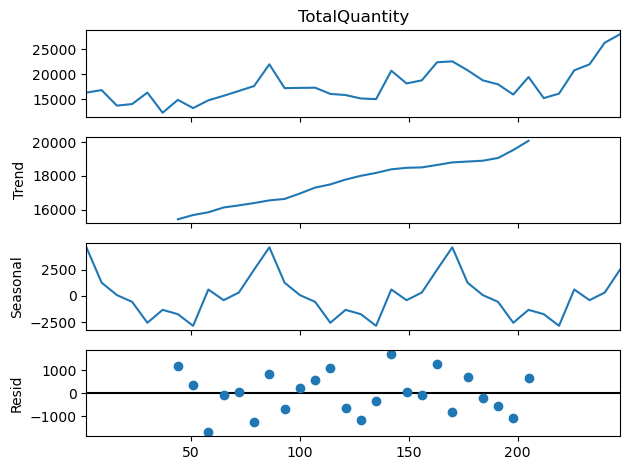

SKU 509


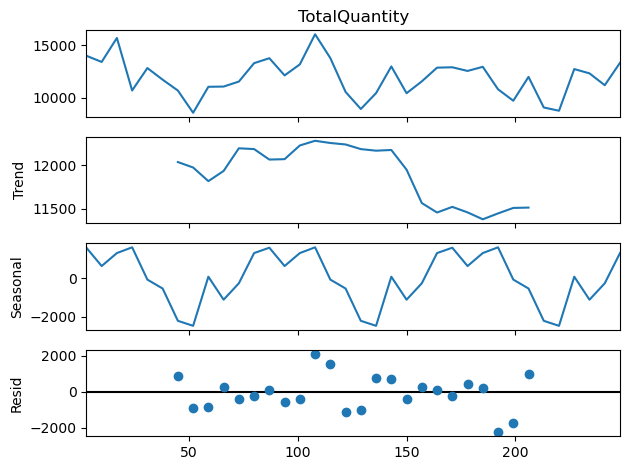

SKU 615


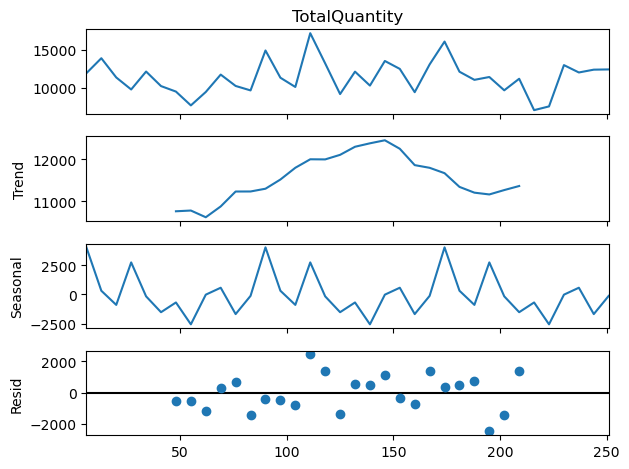

SKU 1018


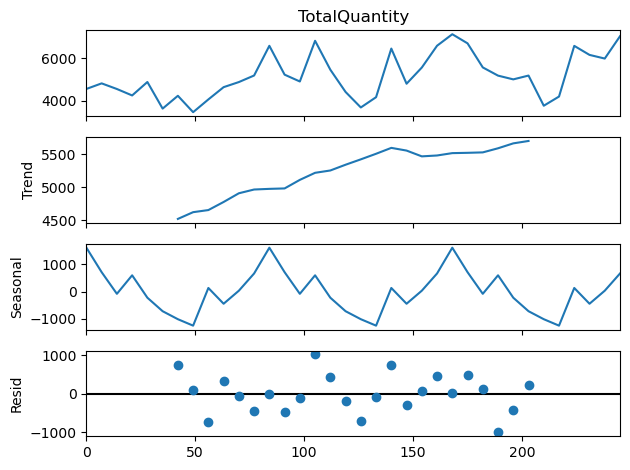

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=12)
    result.plot()
    plt.show()

In [46]:
monthly_data.set_index(['Year', 'Month'], inplace=True)
monthly_data

SkuID  TotalQuantity
Year Month                     
2019 1      1018           4559
     1      1050          19893
     1       319          16316
     1       509          13993
     1       568          54068
...          ...            ...
2021 12      319          28037
     12      509          13327
     12      568          54617
     12      578          27257
     12      615          12425

[252 rows x 2 columns]

In [104]:
sku_data_monthly_data = monthly_data[monthly_data['SkuID'] == '578']

best_window = find_best_window_size(sku_data_monthly_data['TotalQuantity'], min_window=2, max_window=12)
best_window

            mape           mse         rmse        bias          mad
window                                                              
2       0.134770  2.865089e+07  5352.652594  120.128571  3797.957143
3       0.141157  3.397204e+07  5828.553640   12.098039  3998.549020
4       0.148919  4.033459e+07  6350.951891 -199.318182  4244.196970
5       0.167093  5.008524e+07  7077.092522 -165.400000  4733.012500
6       0.175280  5.307811e+07  7285.472205 -170.709677  4973.827957
7       0.181382  5.778958e+07  7601.945504 -216.628571  5140.371429
8       0.185619  5.928301e+07  7699.546078 -249.426724  5231.849138
9       0.186344  5.866837e+07  7659.528077 -383.563492  5247.507937
10      0.186264  6.061320e+07  7785.447887 -390.211111  5249.929630
11      0.187056  6.177219e+07  7859.528535 -191.877622  5214.192308
12      0.190058  6.327055e+07  7954.278869  -89.203333  5291.850000


2

## Forecasting

### Exponential Smoothing

In [48]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

exponential_smoothing_forecast_monthly = []

def forecast_sku_ExponentialSmoothing_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(12)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 12 months
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=12, trend='add').fit()
    future_forecast = full_model.forecast(12)
    future_forecast = future_forecast.astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    exponential_smoothing_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} Exponential Smoothing Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')


In [49]:
for sku_id in all_sku_ids:
    forecast_sku_ExponentialSmoothing_monthly(sku_id)

SKU 568 Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           71987
     2           51764
     3           46095
     4           48162
     5           49288
     6           72483
     7           51916
     8           50708
     9           58599
     10          69711
     11          63105
     12          57594

MAPE: 0.19136650060570337
MSE: 439732463.3476496
RMSE: 20969.798838988645
Bias: -4519.619936586668

SKU 578 Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           34735
     2           28484
     3           29081
     4           27299
     5           23676
     6           29869
     7           24554
     8           18947
     9           27726
     10          24335
     11          28013
     12          28944

MAPE: 0.2450073123329066
MSE: 114281945.43236214
RMSE: 10690.273403068892
Bias: -570.5297447417042

SKU 1050 Exponential Smoothing Forec

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to c

SKU 319 Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           28521
     2           25876
     3           24712
     4           24446
     5           23261
     6           24156
     7           23827
     8           23199
     9           26980
     10          26400
     11          27710
     12          29989

MAPE: 0.11185401172628379
MSE: 8316848.6669606045
RMSE: 2883.8947045550403
Bias: -455.3599939748219

SKU 509 Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           13305
     2           12335
     3           13008
     4           13290
     5           11595
     6           11116
     7            9412
     8            9140
     9           11706
     10          10493
     11          11339
     12          12914

MAPE: 0.13362317268146842
MSE: 4489777.088925015
RMSE: 2118.9094102686445
Bias: 874.5026831619931

SKU 615 Exponential Smoothing Foreca

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A

In [50]:
exponential_smoothing_forecast_monthly = pd.DataFrame(exponential_smoothing_forecast_monthly)
exponential_smoothing_forecast_monthly.set_index('sku_id', inplace=True)
exponential_smoothing_forecast_monthly

mape           mse       rmse      bias        mad
sku_id                                                     
568     0.191  4.397325e+08  20969.799 -4519.620  12588.156
578     0.245  1.142819e+08  10690.273  -570.530   7419.692
1050    0.381  1.418400e+08  11909.658  6285.284   9580.773
319     0.112  8.316849e+06   2883.895  -455.360   2309.239
509     0.134  4.489777e+06   2118.909   874.503   1429.651
615     0.229  9.846970e+06   3137.988  1987.876   2172.593
1018    0.142  8.997108e+05    948.531   573.284    680.218

### Moving Average

In [51]:
moving_average_forecast_monthly = []

def moving_average_forecast(series, window):
    return series.rolling(window=window).mean().iloc[-1]

def forecast_sku_MovingAverage_monthly(sku_id, window=12):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Calculate moving average forecast for the validation period
    validation_forecast = np.full(12, moving_average_forecast(train, window))
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Calculate moving average forecast for the next 12 months
    future_forecast = np.full(12, moving_average_forecast(sku_data['TotalQuantity'], window)).astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    moving_average_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} Moving Average Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')


In [52]:
for sku_id in all_sku_ids:
    forecast_sku_MovingAverage_monthly(sku_id)

SKU 568 Moving Average Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           53865
     2           53865
     3           53865
     4           53865
     5           53865
     6           53865
     7           53865
     8           53865
     9           53865
     10          53865
     11          53865
     12          53865

MAPE: 0.25819317803897024
MSE: 640618832.0763888
RMSE: 25310.44906903844
Bias: -5703.999999999997

SKU 578 Moving Average Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           28669
     2           28669
     3           28669
     4           28669
     5           28669
     6           28669
     7           28669
     8           28669
     9           28669
     10          28669
     11          28669
     12          28669

MAPE: 0.2605779811799476
MSE: 114078301.50694443
RMSE: 10680.744426627969
Bias: 2.5833333333321207

SKU 1050 Moving Average Forecast for Next 12 Months

In [53]:
moving_average_forecast_monthly = pd.DataFrame(moving_average_forecast_monthly)
moving_average_forecast_monthly.set_index('sku_id', inplace=True)
moving_average_forecast_monthly

mape           mse       rmse      bias        mad
sku_id                                                     
568     0.258  6.406188e+08  25310.449 -5704.000  15788.750
578     0.261  1.140783e+08  10680.744     2.583   7324.764
1050    0.162  2.635548e+07   5133.759   688.417   4124.500
319     0.157  2.019300e+07   4493.662 -2347.667   3468.833
509     0.125  2.801403e+06   1673.739   692.583   1265.667
615     0.187  6.182449e+06   2486.453   910.083   1731.639
1018    0.166  1.189992e+06   1090.868  -320.000    924.681

### Naive

In [54]:
naive_forecast_monthly = []

def forecast_sku_Naive_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Use the last observed value in the training set to forecast the validation period
    last_observed_value = train.iloc[-1]
    validation_forecast = np.full(12, last_observed_value)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Use the last observed value in the entire dataset to forecast the next 12 months
    last_observed_value_full = sku_data['TotalQuantity'].iloc[-1]
    future_forecast = np.full(12, last_observed_value_full).astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    naive_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} Naive Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')


In [55]:
for sku_id in all_sku_ids:
    forecast_sku_Naive_monthly(sku_id)

SKU 568 Naive Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           54617
     2           54617
     3           54617
     4           54617
     5           54617
     6           54617
     7           54617
     8           54617
     9           54617
     10          54617
     11          54617
     12          54617

MAPE: 0.2353339542872306
MSE: 763685971.0833334
RMSE: 27634.86875458853
Bias: -12474.083333333334

SKU 578 Naive Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           27257
     2           27257
     3           27257
     4           27257
     5           27257
     6           27257
     7           27257
     8           27257
     9           27257
     10          27257
     11          27257
     12          27257

MAPE: 0.2613590590866308
MSE: 114081319.83333333
RMSE: 10680.88572325972
Bias: 55.0

SKU 1050 Naive Forecast for Next 12 Months

            Forecasted
Year Month       

In [56]:
naive_forecast_monthly = pd.DataFrame(naive_forecast_monthly)
naive_forecast_monthly.set_index('sku_id', inplace=True)
naive_forecast_monthly

mape           mse       rmse       bias        mad
sku_id                                                      
568     0.235  7.636860e+08  27634.869 -12474.083  16368.750
578     0.261  1.140813e+08  10680.886     55.000   7333.500
1050    0.197  3.180065e+07   5639.206   2432.917   4821.917
319     0.200  1.899469e+07   4358.290   2076.833   3701.667
509     0.145  4.102622e+06   2025.493   1334.500   1430.500
615     0.242  8.418156e+06   2901.406   1750.417   2252.083
1018    0.225  1.870080e+06   1367.509    884.583   1068.917

## Seasonal Forecasting Methods

There are seasonal patterns in the monthly data. So, we can use forecasting methods that can capture the seasonality.
- Triple Exponential Smoothing
- ARIMA
- SARIMA

### Triple Exponential Smoothing

In [57]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple_exponential_smoothing_forecast_monthly = []

def forecast_sku_TripleExponentialSmoothing_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(12)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 12 months
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=12, trend='add').fit()
    future_forecast = full_model.forecast(12)
    future_forecast = future_forecast.astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    triple_exponential_smoothing_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} Triple Exponential Smoothing Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')


In [58]:
for sku_id in all_sku_ids:
    forecast_sku_TripleExponentialSmoothing_monthly(sku_id)

SKU 568 Triple Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           71987
     2           51764
     3           46095
     4           48162
     5           49288
     6           72483
     7           51916
     8           50708
     9           58599
     10          69711
     11          63105
     12          57594

MAPE: 0.19136650060570337
MSE: 439732463.3476496
RMSE: 20969.798838988645
Bias: -4519.619936586668

SKU 578 Triple Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           34735
     2           28484
     3           29081
     4           27299
     5           23676
     6           29869
     7           24554
     8           18947
     9           27726
     10          24335
     11          28013
     12          28944

MAPE: 0.2450073123329066
MSE: 114281945.43236214
RMSE: 10690.273403068892
Bias: -570.5297447417042

SKU 1050 Triple Expone

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to c

SKU 319 Triple Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           28521
     2           25876
     3           24712
     4           24446
     5           23261
     6           24156
     7           23827
     8           23199
     9           26980
     10          26400
     11          27710
     12          29989

MAPE: 0.11185401172628379
MSE: 8316848.6669606045
RMSE: 2883.8947045550403
Bias: -455.3599939748219

SKU 509 Triple Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           13305
     2           12335
     3           13008
     4           13290
     5           11595
     6           11116
     7            9412
     8            9140
     9           11706
     10          10493
     11          11339
     12          12914

MAPE: 0.13362317268146842
MSE: 4489777.088925015
RMSE: 2118.9094102686445
Bias: 874.5026831619931



/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A

SKU 615 Triple Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           16018
     2           12317
     3           11127
     4           14803
     5           11913
     6           10578
     7           11439
     8            9587
     9           12163
     10          12784
     11          10546
     12          12138

MAPE: 0.22853131914896382
MSE: 9846970.197036048
RMSE: 3137.98824042348
Bias: 1987.8757165500047

SKU 1018 Triple Exponential Smoothing Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1            7352
     2            6772
     3            6154
     4            6602
     5            6213
     6            5534
     7            5046
     8            5051
     9            6759
     10           6239
     11           6544
     12           7306

MAPE: 0.1416533974592207
MSE: 899710.7859151709
RMSE: 948.5308565962264
Bias: 573.2842329490574



/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [59]:
triple_exponential_smoothing_forecast_monthly = pd.DataFrame(triple_exponential_smoothing_forecast_monthly)
triple_exponential_smoothing_forecast_monthly.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast_monthly

mape           mse       rmse      bias        mad
sku_id                                                     
568     0.191  4.397325e+08  20969.799 -4519.620  12588.156
578     0.245  1.142819e+08  10690.273  -570.530   7419.692
1050    0.381  1.418400e+08  11909.658  6285.284   9580.773
319     0.112  8.316849e+06   2883.895  -455.360   2309.239
509     0.134  4.489777e+06   2118.909   874.503   1429.651
615     0.229  9.846970e+06   3137.988  1987.876   2172.593
1018    0.142  8.997108e+05    948.531   573.284    680.218

### ARIMA

In [60]:
from statsmodels.tsa.arima.model import ARIMA

def forecast_sku_ARIMA_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Train the model
    model = ARIMA(train, order=(5,1,0)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(steps=12)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 12 months
    full_model = ARIMA(sku_data['TotalQuantity'], order=(5,1,0)).fit()
    future_forecast = full_model.forecast(steps=12)
    future_forecast = future_forecast.astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    arima_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} ARIMA Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')

In [61]:
arima_forecast_monthly = []

for sku_id in all_sku_ids:
    forecast_sku_ARIMA_monthly(sku_id)

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An

SKU 568 ARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           43530
     2           60101
     3           55553
     4           89488
     5           63001
     6           52533
     7           62646
     8           59897
     9           74672
     10          65001
     11          57928
     12          63315

MAPE: 0.26298060380010807
MSE: 646797138.1892462
RMSE: 25432.206710964863
Bias: -5855.771106079611

SKU 578 ARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           30516
     2           33194
     3           24381
     4           36065
     5           34406
     6           31220
     7           34083
     8           30610
     9           31618
     10          33183
     11          31912
     12          32784

MAPE: 0.24486973692142103
MSE: 123163235.8511196
RMSE: 11097.893306890259
Bias: -2352.5342462308586

SKU 1050 ARIMA Forecast for Next 12 Months

            Forecasted


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


SKU 1018 ARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1            6900
     2            6635
     3            6738
     4            6806
     5            6758
     6            6746
     7            6764
     8            6764
     9            6758
     10           6760
     11           6761
     12           6761

MAPE: 0.18066297108841148
MSE: 1187968.1085281507
RMSE: 1089.9394976456954
Bias: 263.08474903598625



/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [62]:
arima_forecast_monthly = pd.DataFrame(arima_forecast_monthly)
arima_forecast_monthly.set_index('sku_id', inplace=True)
arima_forecast_monthly

mape           mse       rmse      bias        mad
sku_id                                                     
568     0.263  6.467971e+08  25432.207 -5855.771  16091.740
578     0.245  1.231632e+08  11097.893 -2352.534   7451.863
1050    0.162  2.614518e+07   5113.236    45.087   4272.796
319     0.157  1.463098e+07   3825.046   307.086   3095.600
509     0.133  3.350475e+06   1830.430  1017.596   1325.111
615     0.181  5.362815e+06   2315.775   789.261   1676.620
1018    0.181  1.187968e+06   1089.939   263.085    911.927

### SARIMA

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def forecast_sku_SARIMA_monthly(sku_id):
    sku_data = monthly_data[monthly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-12]
    validation = sku_data['TotalQuantity'][-12:]
    
    # Train the model
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.get_forecast(steps=12).predicted_mean
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 12 months
    full_model = SARIMAX(sku_data['TotalQuantity'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
    future_forecast = full_model.get_forecast(steps=12).predicted_mean
    future_forecast = future_forecast.astype(int)
    
    forecast_months = [(2021, i) for i in range(1, 13)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, month in forecast_months], 
        'Month': [month for year, month in forecast_months], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Month'], inplace=True)
    
    # Append results including validation metrics
    sarima_forecast_monthly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    print(f'SKU {sku_id} SARIMA Forecast for Next 12 Months\n\n{forecast_table}\n')
    print(f'MAPE: {mape}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'Bias: {bias}')
    print('===============\n')

In [64]:
sarima_forecast_monthly = []

for sku_id in all_sku_ids:
    forecast_sku_SARIMA_monthly(sku_id)

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28968D+00    |proj g|=  4.71928D-01

At iterate    5    f=  5.01887D+00    |proj g|=  4.41329D-02

At iterate   10    f=  4.98286D+00    |proj g|=  2.68556D-03

At iterate   15    f=  4.98101D+00    |proj g|=  2.73021D-03

At iterate   20    f=  4.97898D+00    |proj g|=  2.06738D-03

At iterate   25    f=  4.97854D+00    |proj g|=  4.61963D-04

At iterate   30    f=  4.97848D+00    |proj g|=  1.78522D-04

At iterate   35    f=  4.97806D+00    |proj g|=  7.66258D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40641D+00    |proj g|=  2.23665D-01

At iterate    5    f=  7.33497D+00    |proj g|=  1.09663D-02

At iterate   10    f=  7.33412D+00    |proj g|=  3.36066D-04

At iterate   15    f=  7.33412D+00    |proj g|=  3.92085D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   8.961D-06   7.334D+00
  F =   7.3341157303395939     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SKU 568 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.70032D+00    |proj g|=  2.24577D-02

At iterate   10    f=  4.68461D+00    |proj g|=  2.42371D-02

At iterate   15    f=  4.67689D+00    |proj g|=  7.02989D-03

At iterate   20    f=  4.67505D+00    |proj g|=  1.08153D-03

At iterate   25    f=  4.67471D+00    |proj g|=  1.99830D-04

At iterate   30    f=  4.67464D+00    |proj g|=  4.47305D-04

At iterate   35    f=  4.67418D+00    |proj g|=  2.65108D-03

At iterate   40    f=  4.67050D+00    |proj g|=  3.11852D-02

At iterate   45    f=  4.66629D+00    |proj g|=  5.89023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     70   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-


At iterate   15    f=  4.84541D+00    |proj g|=  1.01016D-03

At iterate   20    f=  4.84510D+00    |proj g|=  1.60356D-03

At iterate   25    f=  4.84502D+00    |proj g|=  9.40925D-05

At iterate   30    f=  4.84501D+00    |proj g|=  2.45689D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     40      1     0     0   1.002D-03   4.845D+00
  F =   4.8450011785600768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  6.73920D+00    |proj g|=  2.73424D-03

At iterate   15    f=  6.73908D+00    |proj g|=  2.09806D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   2.098D-05   6.739D+00
  F =   6.7390835193817864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SKU 1050 SARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           50052
     2           28204
     3           35892
     4           34486
     5           36895
     6           34182
     7           28309
     8           30408
     9           36581
 

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.23673D+00    |proj g|=  2.80560D-02

At iterate   10    f=  4.21377D+00    |proj g|=  3.85987D-03

At iterate   15    f=  4.21047D+00    |proj g|=  2.21268D-03

At iterate   20    f=  4.20988D+00    |proj g|=  1.40504D-03

At iterate   25    f=  4.20972D+00    |proj g|=  3.41528D-04

At iterate   30    f=  4.20882D+00    |proj g|=  1.30780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     44      1     0     0   1.304D-04   4.209D+00
  F =   4.2088228470378057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.00431D+00    |proj g|=  8.77267D-02

At iterate   10    f=  5.97090D+00    |proj g|=  7.02649D-03

At iterate   15    f=  5.96684D+00    |proj g|=  3.44221D-03

At iterate   20    f=  5.96610D+00    |proj g|=  8.10993D-04

At iterate   25    f=  5.96598D+00    |proj g|=  1.03779D-04

At iterate   30    f=  5.96596D+00    |proj g|=  1.04532D-04

At iterate   35    f=  5.96595D+00    |proj g|=  2.86105D-04

At iterate   40    f=  5.96577D+00    |proj g|=  5.54577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     50      1     0     0   2.918D-06   5.966D+00
  F =   5.96577081007

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  4.13575D+00    |proj g|=  1.65468D-03

At iterate   20    f=  4.13368D+00    |proj g|=  1.18719D-03

At iterate   25    f=  4.12445D+00    |proj g|=  2.54102D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     29      1     0     0   5.402D-06   4.124D+00
  F =   4.1244392358119297     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01342D+00    |proj g|=  4.24547D-01


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.83314D+00    |proj g|=  1.80157D-02

At iterate   10    f=  5.81588D+00    |proj g|=  4.16507D-02

At iterate   15    f=  5.81320D+00    |proj g|=  2.54396D-03

At iterate   20    f=  5.81135D+00    |proj g|=  1.86728D-03

At iterate   25    f=  5.81134D+00    |proj g|=  2.38881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     38      1     0     0   2.389D-05   5.811D+00
  F =   5.8113417042075373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SKU 509 SARIMA Forecast for Next 12 Months

            Forecasted
Year Month            
2021 1           15858


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  4.26762D+00    |proj g|=  1.32868D-04

At iterate   20    f=  4.26762D+00    |proj g|=  1.87392D-04

At iterate   25    f=  4.26759D+00    |proj g|=  3.37387D-03

At iterate   30    f=  4.26451D+00    |proj g|=  3.63654D-02

At iterate   35    f=  4.24953D+00    |proj g|=  2.83205D-03

At iterate   40    f=  4.24808D+00    |proj g|=  2.97511D-03
  ys=-1.276E-03  -gs= 6.306E-04 BFGS update SKIPPED

At iterate   45    f=  4.24556D+00    |proj g|=  1.38986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     65      1     1     0   7.991D-06   4.245D+00
  F =   4.2452816043266184     

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16773D+00    |proj g|=  4.12277D-01

At iterate    5    f=  6.01820D+00    |proj g|=  1.26471D-02

At iterate   10    f=  6.01717D+00    |proj g|=  1.61983D-04

At iterate   15    f=  6.01717D+00    |proj g|=  4.12465D-04

At iterate   20    f=  6.01707D+00    |proj g|=  5.57997D-03

At iterate   25    f=  6.00952D+00    |proj g|=  8.63420D-02

At iterate   30    f=  5.99957D+00    |proj g|=  1.70105D-02

At iterate   35    f=  5.99837D+00    |proj g|=  8.34991D-04

At iterate   40    f=  5.99821D+00    |proj g|=  5.02453D-04

At iterate   45    f=  5.99818D+00    |proj g|=  2.57014D-05

At iterate   50    f=  5.99818D+00    |proj g|=  7.75868D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  3.91104D+00    |proj g|=  4.64551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   7.858D-06   3.911D+00
  F =   3.9110392655267767     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36668D+00    |proj g|=  1.59824D-01


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.33405D+00    |proj g|=  1.65902D-02

At iterate   10    f=  5.33203D+00    |proj g|=  2.88310D-03

At iterate   15    f=  5.33200D+00    |proj g|=  8.94547D-05

At iterate   20    f=  5.33199D+00    |proj g|=  1.69556D-03

At iterate   25    f=  5.33015D+00    |proj g|=  1.84515D-02

At iterate   30    f=  5.32587D+00    |proj g|=  2.09616D-03

At iterate   35    f=  5.32521D+00    |proj g|=  4.03710D-03

At iterate   40    f=  5.32507D+00    |proj g|=  8.64949D-04

At iterate   45    f=  5.32504D+00    |proj g|=  3.08484D-04

At iterate   50    f=  5.32503D+00    |proj g|=  2.30524D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [65]:
sarima_forecast_monthly = pd.DataFrame(sarima_forecast_monthly)
sarima_forecast_monthly.set_index('sku_id', inplace=True)
sarima_forecast_monthly

mape           mse       rmse       bias        mad
sku_id                                                      
568     0.994  2.062465e+09  45414.367  39194.434  42454.628
578     1.235  9.858916e+08  31398.910  29386.886  29602.778
1050    0.760  3.927605e+08  19818.185  18904.444  18904.444
319     0.835  2.621707e+08  16191.685  15824.033  15824.033
509     1.145  1.682689e+08  12971.852  12879.224  12879.224
615     0.980  1.106749e+08  10520.216  10181.283  10181.283
1018    0.238  1.935525e+06   1391.231   1198.150   1198.150

# Monthly: Comparison of Forecasting Methods
## Bias Values of Forecasting Methods

Bias = (Actual - Forecasted) / n 

In [66]:
all_forecasts_bias_monthly = pd.concat([exponential_smoothing_forecast_monthly['bias'], moving_average_forecast_monthly['bias'], naive_forecast_monthly['bias'], triple_exponential_smoothing_forecast_monthly['bias'], arima_forecast_monthly['bias'], sarima_forecast_monthly['bias']], axis=1)
all_forecasts_bias_monthly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_bias_monthly

Exponential Smoothing  Moving Average      Naive  \
sku_id                                                     
568                 -4519.620       -5704.000 -12474.083   
578                  -570.530           2.583     55.000   
1050                 6285.284         688.417   2432.917   
319                  -455.360       -2347.667   2076.833   
509                   874.503         692.583   1334.500   
615                  1987.876         910.083   1750.417   
1018                  573.284        -320.000    884.583   

        Triple Exponential Smoothing     ARIMA     SARIMA  
sku_id                                                     
568                        -4519.620 -5855.771  39194.434  
578                         -570.530 -2352.534  29386.886  
1050                        6285.284    45.087  18904.444  
319                         -455.360   307.086  15824.033  
509                          874.503  1017.596  12879.224  
615                         1987.876   789.261  10181.283  
1018                         573.284   263.085   1198.150

<Figure size 1200x600 with 0 Axes>

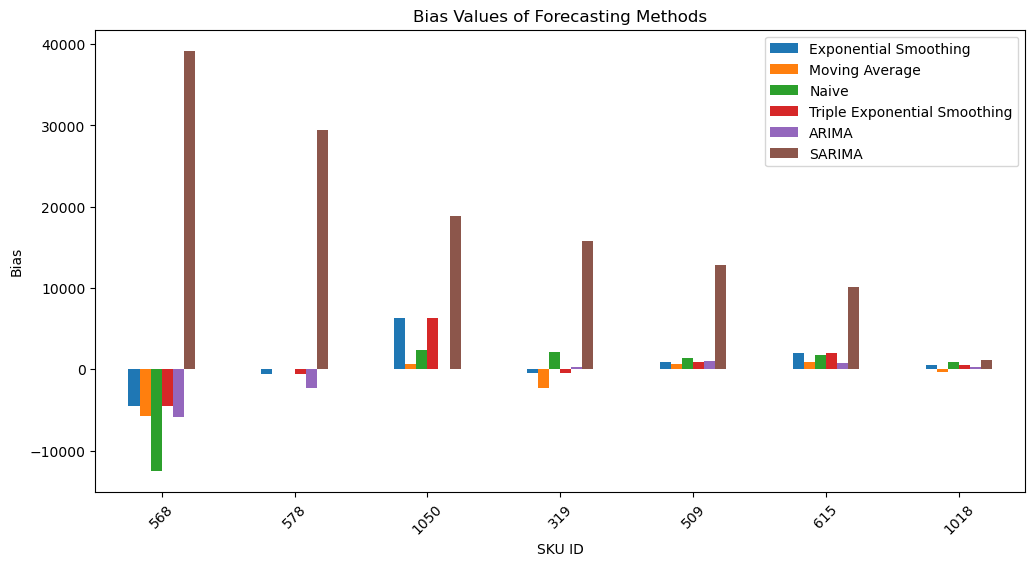

In [67]:
plt.figure(figsize=(12, 6))
all_forecasts_bias_monthly.plot(kind='bar', figsize=(12, 6))
plt.title('Bias Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.show()

In [68]:
all_forecasts_mape_monthly = pd.concat([exponential_smoothing_forecast_monthly['mape'], moving_average_forecast_monthly['mape'], naive_forecast_monthly['mape'], triple_exponential_smoothing_forecast_monthly['mape'], arima_forecast_monthly['mape'], sarima_forecast_monthly['mape']], axis=1)
all_forecasts_mape_monthly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_mape_monthly

Exponential Smoothing  Moving Average  Naive  \
sku_id                                                 
568                     0.191           0.258  0.235   
578                     0.245           0.261  0.261   
1050                    0.381           0.162  0.197   
319                     0.112           0.157  0.200   
509                     0.134           0.125  0.145   
615                     0.229           0.187  0.242   
1018                    0.142           0.166  0.225   

        Triple Exponential Smoothing  ARIMA  SARIMA  
sku_id                                               
568                            0.191  0.263   0.994  
578                            0.245  0.245   1.235  
1050                           0.381  0.162   0.760  
319                            0.112  0.157   0.835  
509                            0.134  0.133   1.145  
615                            0.229  0.181   0.980  
1018                           0.142  0.181   0.238

## MAPE Values of Forecasting Methods

MAPE = (|Actual - Forecasted| / Actual) / n

<Figure size 1200x600 with 0 Axes>

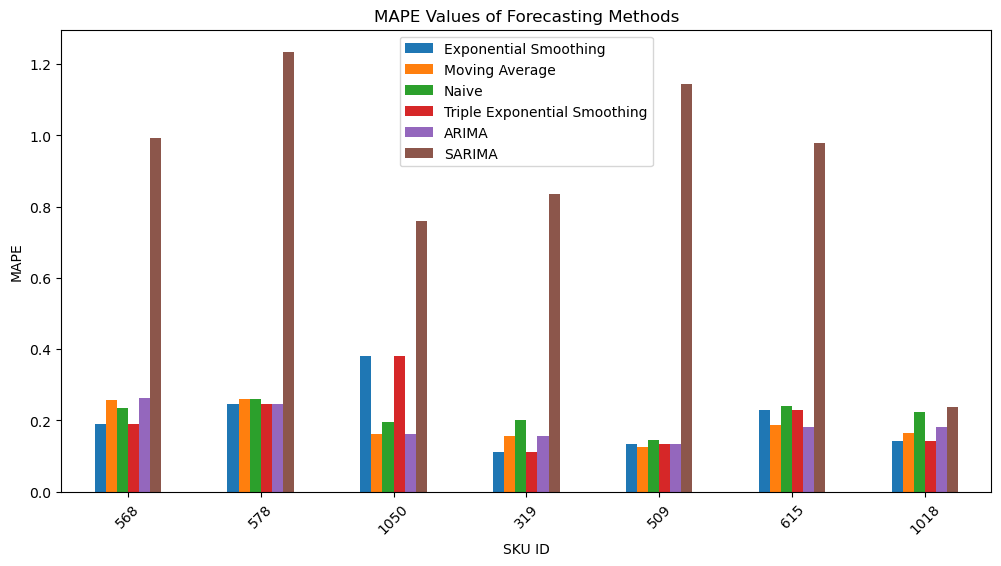

In [69]:
plt.figure(figsize=(12, 6))
all_forecasts_mape_monthly.plot(kind='bar', figsize=(12, 6))
plt.title('MAPE Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.show()

# Weekly Sales Analysis and Forecasting

In [70]:
weekly_data = data.copy()

weekly_data['Year'] = weekly_data['Date'].dt.year
weekly_data['Week'] = weekly_data['Date'].dt.isocalendar().week

weekly_data = weekly_data.groupby(['Year', 'Week', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
weekly_data

Year  Week SkuID  TotalQuantity
0     2019     1  1018           1064
1     2019     1  1050           3291
2     2019     1   319           3764
3     2019     1   509           2981
4     2019     1   568          13012
...    ...   ...   ...            ...
1101  2021    53   319            229
1102  2021    53   509             91
1103  2021    53   568             88
1104  2021    53   578             90
1105  2021    53   615             44

[1106 rows x 4 columns]

In [71]:
sku_data_week_data = weekly_data[weekly_data['SkuID'] == '568']

best_window = find_best_window_size(sku_data_week_data['TotalQuantity'], min_window=2, max_window=12)
best_window

            mape           mse         rmse        bias          mad
window                                                              
2       0.449171  1.487770e+07  3857.161991   41.159236  2278.063694
3       0.696418  2.369885e+07  4868.146134   61.931624  2711.017094
4       0.988498  2.942758e+07  5424.719343   85.517742  3100.820968
5       1.074479  3.130880e+07  5595.426903   80.040260  3261.375325
6       1.182833  3.283424e+07  5730.116676  100.994553  3414.323529
7       1.243328  3.507934e+07  5922.781714  113.947368  3597.936090
8       1.325757  3.652695e+07  6043.753135  172.509106  3647.449503
9       1.536690  3.890528e+07  6237.409973  140.007407  3734.297778
10      1.814904  3.907418e+07  6250.934537   85.772483  3679.100000
11      1.780807  3.989107e+07  6315.937921   21.041769  3701.689189
12      1.768139  4.024379e+07  6343.799498  -44.445578  3735.412698


2

In [72]:
def plot_sku_weekly(sku_id):
    sku = weekly_data[weekly_data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    plt.plot(sku.index, sku['TotalQuantity'])
    plt.title(f'SKU {sku_id} Total Quantity by Week')
    plt.xlabel('Week')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.show()
    

SKU 568
Year  Week
2019  1       13012
      2       11898
      3       13531
      4        9830
      5       14812
              ...  
2021  49      12268
      50      14154
      51       8820
      52       7648
      53         88
Name: TotalQuantity, Length: 158, dtype: int64


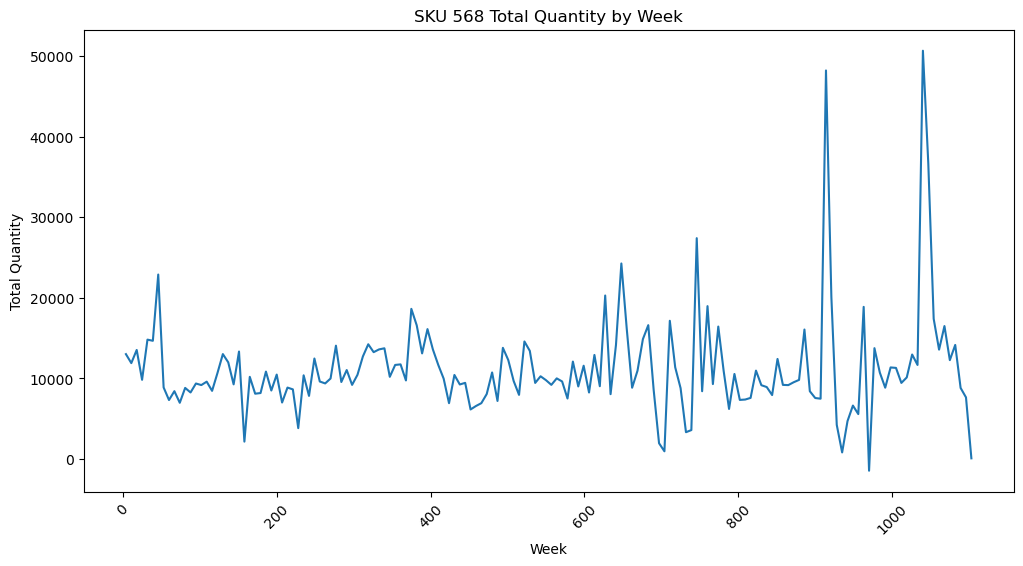

SKU 578
Year  Week
2019  1        7736
      2        8198
      3       10025
      4        7387
      5        6107
              ...  
2021  49       6429
      50       7791
      51       6307
      52       3027
      53         90
Name: TotalQuantity, Length: 158, dtype: int64


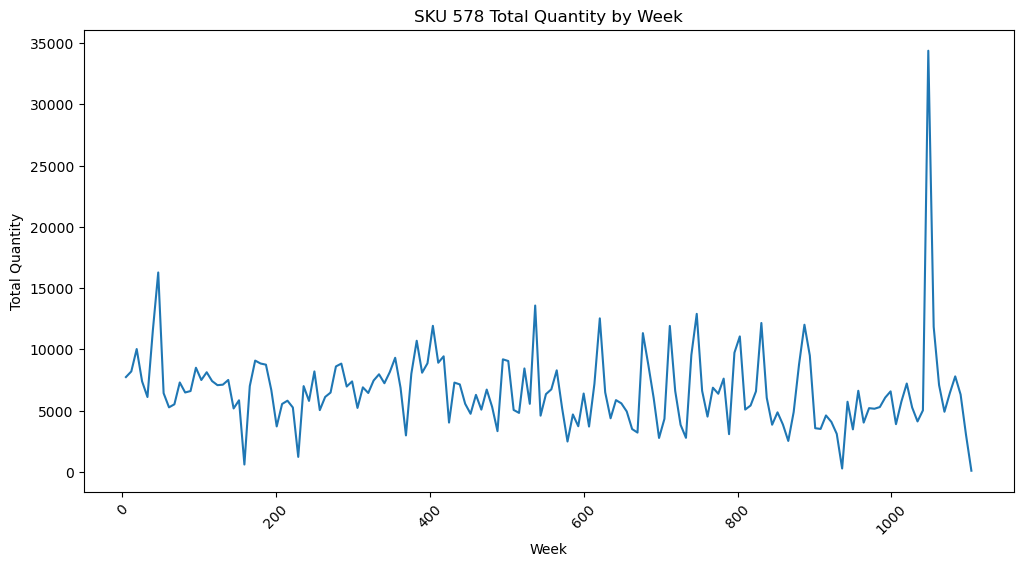

SKU 1050
Year  Week
2019  1        3291
      2        4870
      3        4834
      4        4296
      5        3518
              ...  
2021  49        717
      50       9860
      51      12875
      52       2049
      53        208
Name: TotalQuantity, Length: 158, dtype: int64


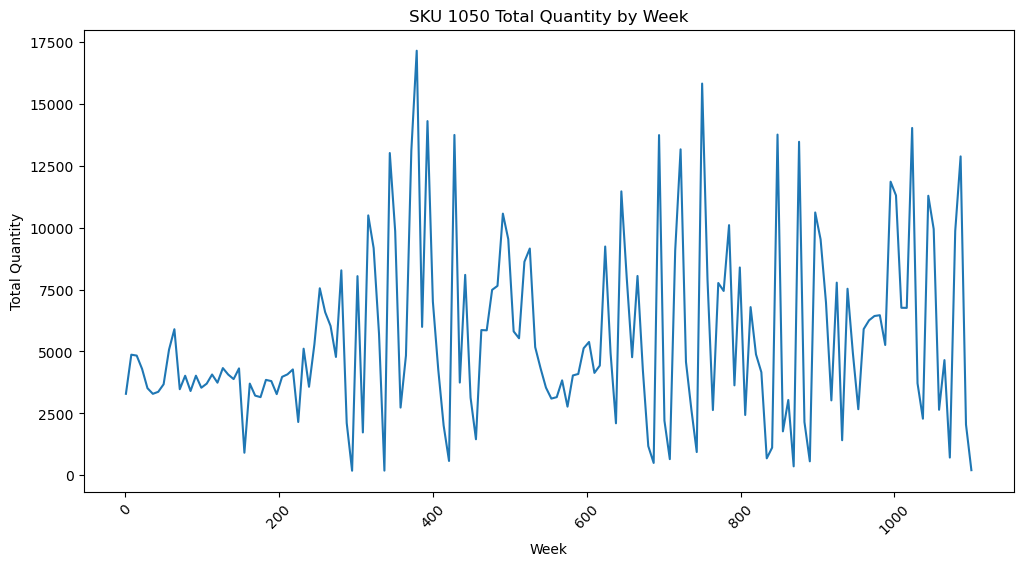

SKU 319
Year  Week
2019  1       3764
      2       3829
      3       3702
      4       3815
      5       3684
              ... 
2021  49      5788
      50      8419
      51      5845
      52      3890
      53       229
Name: TotalQuantity, Length: 158, dtype: int64


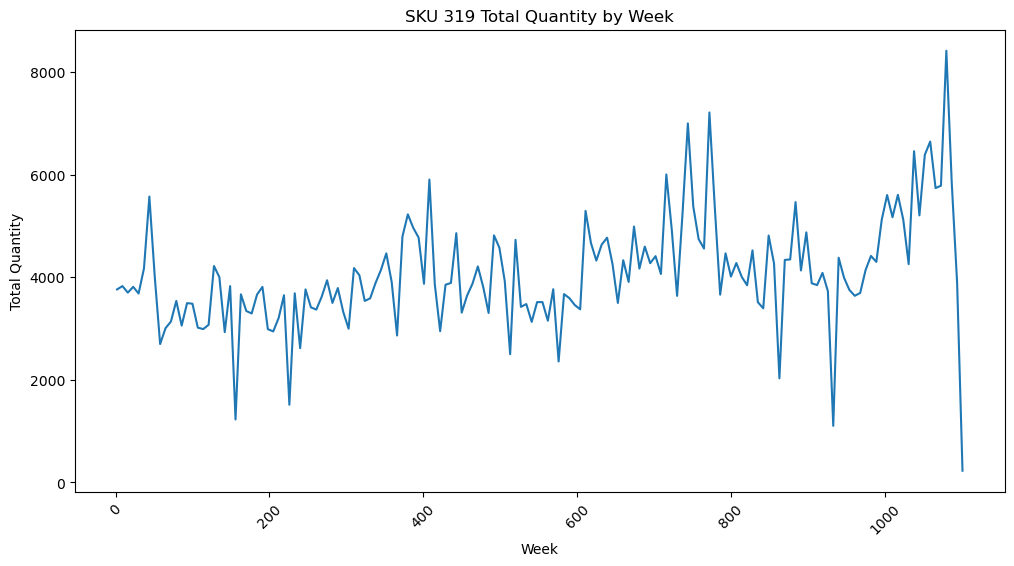

SKU 509
Year  Week
2019  1       2981
      2       3434
      3       3297
      4       2920
      5       3316
              ... 
2021  49      2494
      50      3160
      51      3468
      52      2737
      53        91
Name: TotalQuantity, Length: 158, dtype: int64


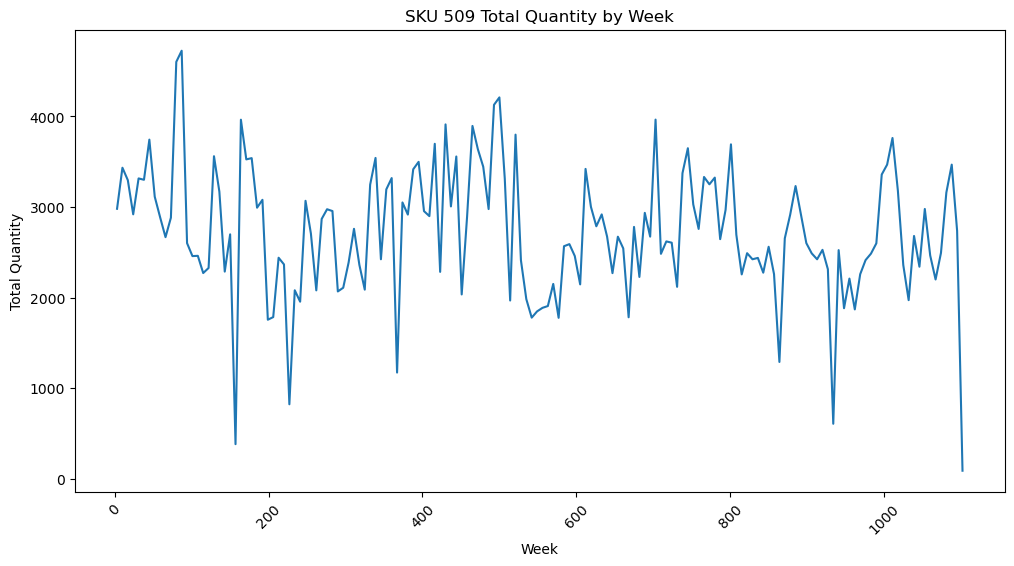

SKU 615
Year  Week
2019  1       2319
      2       2746
      3       2685
      4       3108
      5       2553
              ... 
2021  49      2885
      50      3182
      51      2877
      52      2200
      53        44
Name: TotalQuantity, Length: 158, dtype: int64


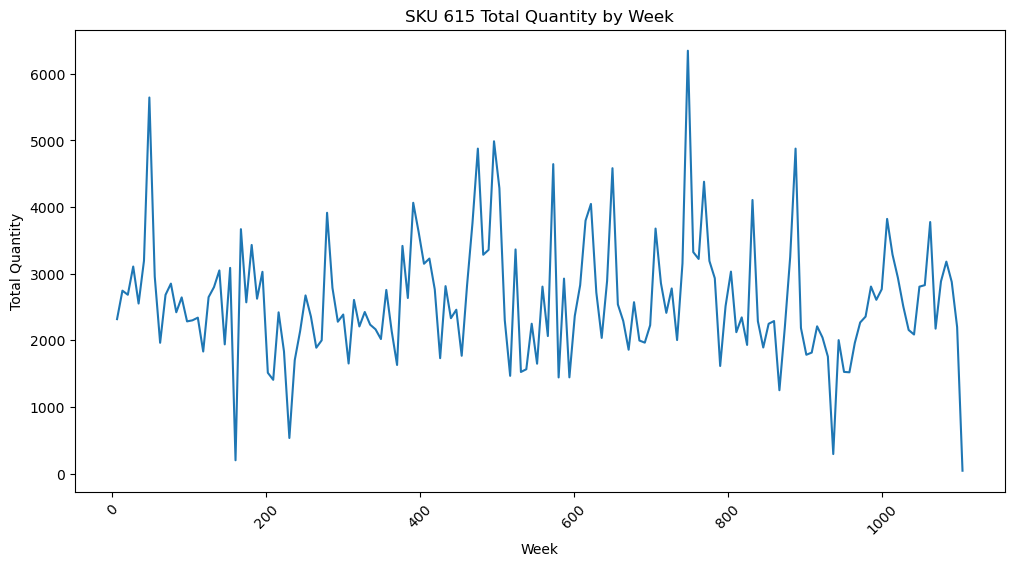

SKU 1018
Year  Week
2019  1       1064
      2       1128
      3       1166
      4        905
      5       1137
              ... 
2021  49      2015
      50      1835
      51      1259
      52      1140
      53        74
Name: TotalQuantity, Length: 158, dtype: int64


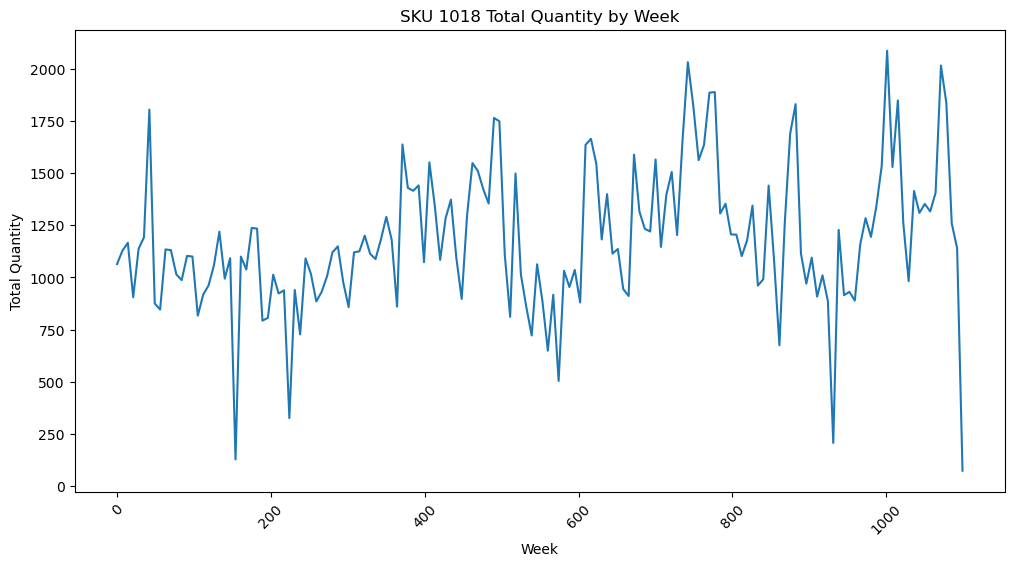

In [73]:
for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Week'], inplace=True)
    print(sku_data['TotalQuantity'])
    plot_sku_weekly(sku_id)

SKU 568


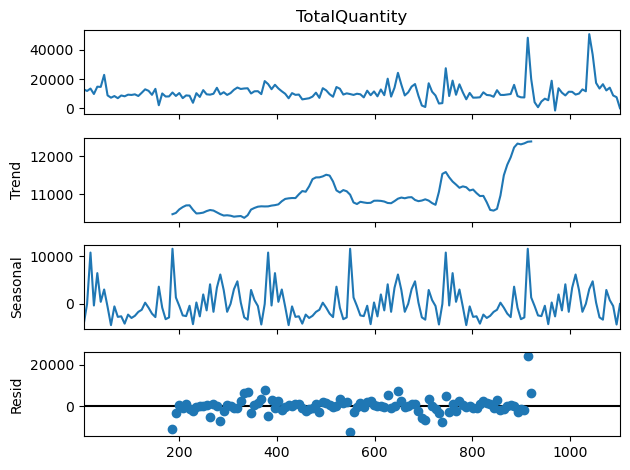

SKU 578


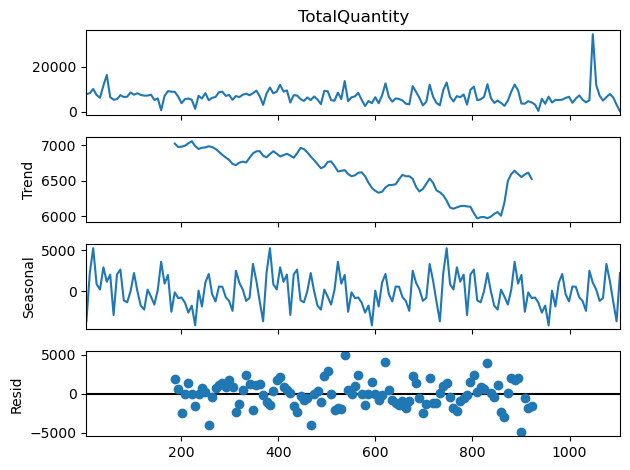

SKU 1050


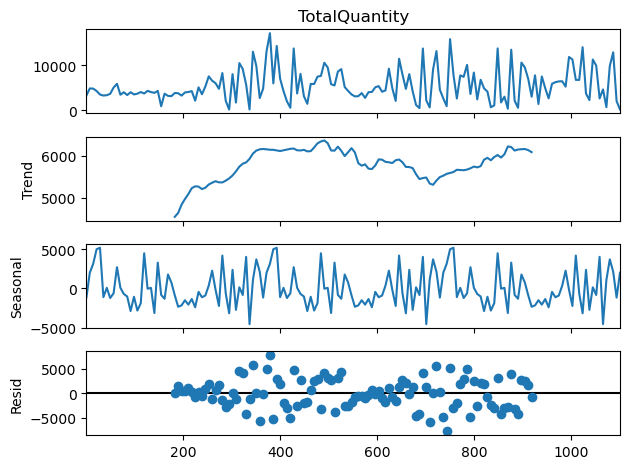

SKU 319


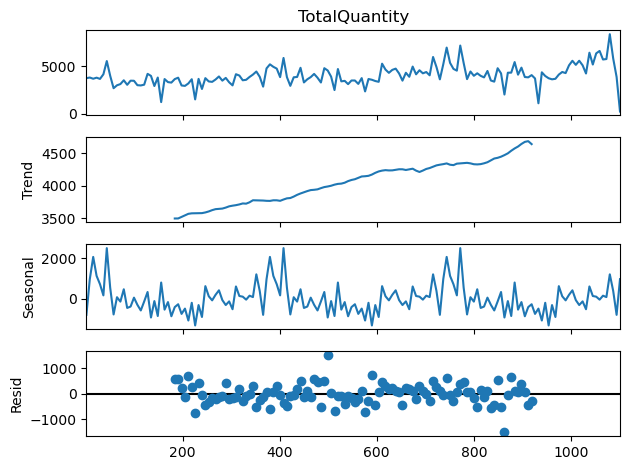

SKU 509


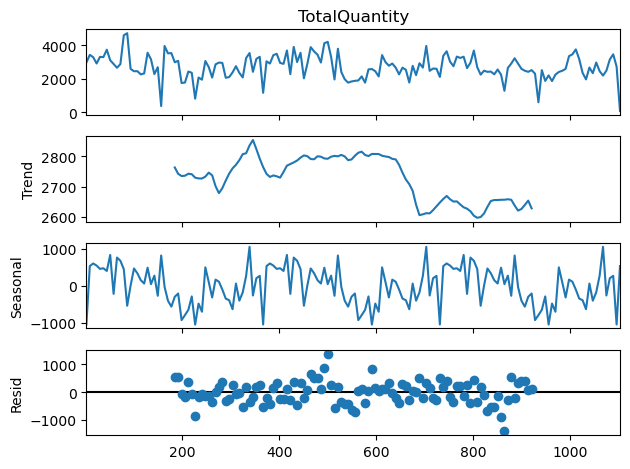

SKU 615


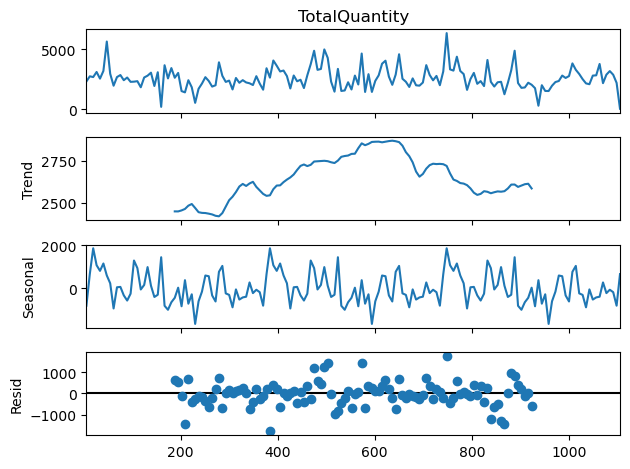

SKU 1018


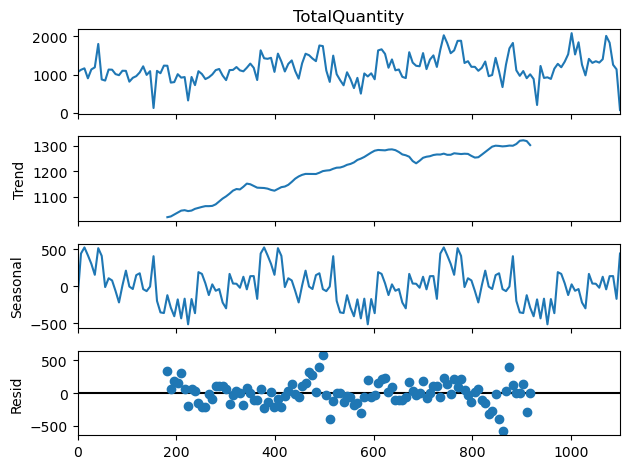

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=52)
    result.plot()
    plt.show()

In [75]:
weekly_data.set_index(['Year', 'Week'], inplace=True)
weekly_data

SkuID  TotalQuantity
Year Week                     
2019 1     1018           1064
     1     1050           3291
     1      319           3764
     1      509           2981
     1      568          13012
...         ...            ...
2021 53     319            229
     53     509             91
     53     568             88
     53     578             90
     53     615             44

[1106 rows x 2 columns]

## Forecasting

### Exponential Smoothing

In [76]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

exponential_smoothing_forecast_weekly = []

def forecast_sku_ExponentialSmoothing_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(52)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 52 weeks
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=52, trend='add').fit()
    future_forecast = full_model.forecast(52)
    future_forecast = future_forecast.astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    exponential_smoothing_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3),
    })

In [77]:
for sku_id in all_sku_ids:
    forecast_sku_ExponentialSmoothing_weekly(sku_id)

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to c

In [78]:
exponential_smoothing_forecast_weekly = pd.DataFrame(exponential_smoothing_forecast_weekly)
exponential_smoothing_forecast_weekly.set_index('sku_id', inplace=True)
exponential_smoothing_forecast_weekly

mape           mse      rmse      bias       mad
sku_id                                                   
568     4.115  8.551615e+07  9247.494 -2011.990  5178.954
578     2.334  2.614115e+07  5112.842    19.738  2934.134
1050    3.113  3.747607e+07  6121.770  -393.668  4993.284
319     0.708  1.656245e+06  1286.952   291.649   829.607
509     0.953  8.716853e+05   933.641   251.287   698.604
615     2.217  1.620565e+06  1273.014   497.775   872.649
1018    0.793  2.058967e+05   453.758   134.343   327.921

### Moving Average

In [79]:
moving_average_forecast_weekly = []

def forecast_sku_MovingAverage_weekly(sku_id, window=52):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Calculate moving average forecast for the validation period
    validation_forecast = np.full(52, moving_average_forecast(train, window))
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Calculate moving average forecast for the next 52 weeks
    future_forecast = np.full(52, moving_average_forecast(sku_data['TotalQuantity'], window)).astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    moving_average_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [80]:
for sku_id in all_sku_ids:
    forecast_sku_MovingAverage_weekly(sku_id)

In [81]:
moving_average_forecast_weekly = pd.DataFrame(moving_average_forecast_weekly)
moving_average_forecast_weekly.set_index('sku_id', inplace=True)
moving_average_forecast_weekly

mape           mse      rmse      bias       mad
sku_id                                                   
568     2.704  9.560878e+07  9777.974 -1723.865  5531.513
578     2.231  2.278172e+07  4773.020   156.231  2721.438
1050    2.052  1.701753e+07  4125.231   -83.769  3457.673
319     0.547  2.101013e+06  1449.487  -487.942  1008.481
509     0.816  4.966522e+05   704.736   208.346   516.354
615     1.644  1.088138e+06  1043.138   234.346   776.533
1018    0.587  1.689774e+05   411.069   -58.250   304.203

### Naive

In [82]:
naive_forecast_weekly = []

def forecast_sku_Naive_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Use the last observed value in the training set to forecast the validation period
    last_observed_value = train.iloc[-1]
    validation_forecast = np.full(52, last_observed_value)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Use the last observed value in the entire dataset to forecast the next 52 weeks
    last_observed_value_full = sku_data['TotalQuantity'].iloc[-1]
    future_forecast = np.full(52, last_observed_value_full).astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    naive_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    


In [83]:
for sku_id in all_sku_ids:
    forecast_sku_Naive_weekly(sku_id)
    

In [84]:
naive_forecast_weekly = pd.DataFrame(naive_forecast_weekly)
naive_forecast_weekly.set_index('sku_id', inplace=True)
naive_forecast_weekly

mape           mse       rmse      bias       mad
sku_id                                                    
568     1.370  1.695203e+08  13019.996 -8768.308  9203.731
578     3.497  3.238246e+07   5690.559  3102.442  4537.519
1050    1.049  2.860755e+07   5348.603 -3405.442  4095.404
319     0.729  2.271959e+06   1507.302   639.558  1166.596
509     1.088  1.058169e+06   1028.673   777.769   822.731
615     1.920  1.395670e+06   1181.385   602.038   943.923
1018    0.904  3.000052e+05    547.727   366.635   458.596

## Seasonal Forecasting Methods

There are seasonal patterns in the weekly data. So, we can use forecasting methods that can capture the seasonality.

- Triple Exponential Smoothing
- ARIMA
- SARIMA

### Triple Exponential Smoothing

In [85]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple_exponential_smoothing_forecast_weekly = []

def forecast_sku_TripleExponentialSmoothing_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=52, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(52)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 52 weeks
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=52, trend='add').fit()
    future_forecast = full_model.forecast(52)
    future_forecast = future_forecast.astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    triple_exponential_smoothing_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3),
    })

In [86]:
for sku_id in all_sku_ids:
    forecast_sku_TripleExponentialSmoothing_weekly(sku_id)
    

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to c

In [87]:
triple_exponential_smoothing_forecast_weekly = pd.DataFrame(triple_exponential_smoothing_forecast_weekly)
triple_exponential_smoothing_forecast_weekly.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast_weekly

mape           mse      rmse      bias       mad
sku_id                                                   
568     4.115  8.551615e+07  9247.494 -2011.990  5178.954
578     2.334  2.614115e+07  5112.842    19.738  2934.134
1050    3.113  3.747607e+07  6121.770  -393.668  4993.284
319     0.708  1.656245e+06  1286.952   291.649   829.607
509     0.953  8.716853e+05   933.641   251.287   698.604
615     2.217  1.620565e+06  1273.014   497.775   872.649
1018    0.793  2.058967e+05   453.758   134.343   327.921

### ARIMA

In [88]:
from statsmodels.tsa.arima.model import ARIMA

arima_forecast_weekly = []

def forecast_sku_ARIMA_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Train the model
    model = ARIMA(train, order=(5,1,0)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(steps=52)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 52 weeks
    full_model = ARIMA(sku_data['TotalQuantity'], order=(5,1,0)).fit()
    future_forecast = full_model.forecast(steps=52)
    future_forecast = future_forecast.astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    arima_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [89]:
for sku_id in all_sku_ids:
    forecast_sku_ARIMA_weekly(sku_id)
    

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An

In [90]:
arima_forecast_weekly = pd.DataFrame(arima_forecast_weekly)
arima_forecast_weekly.set_index('sku_id', inplace=True)
arima_forecast_weekly


mape           mse       rmse      bias       mad
sku_id                                                    
568     1.826  1.242793e+08  11148.063 -5683.431  6706.491
578     2.224  2.236072e+07   4728.712   159.588  2688.978
1050    2.239  1.687103e+07   4107.436   436.870  3443.016
319     0.642  1.887227e+06   1373.764   217.996  1019.402
509     0.824  5.015608e+05    708.210   229.187   520.594
615     1.583  1.053827e+06   1026.561   141.673   758.520
1018    0.734  1.952780e+05    441.903   169.077   355.112

### SARIMA

In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_forecast_weekly = []

def forecast_sku_SARIMA_weekly(sku_id):
    sku_data = weekly_data[weekly_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-52]
    validation = sku_data['TotalQuantity'][-52:]
    
    # Train the model
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.get_forecast(steps=52).predicted_mean
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 52 weeks
    full_model = SARIMAX(sku_data['TotalQuantity'], order=(1,1,1), seasonal_order=(1,1,1,52)).fit()
    future_forecast = full_model.get_forecast(steps=52).predicted_mean
    future_forecast = future_forecast.astype(int)
    
    forecast_weeks = [(2021, i) for i in range(1, 53)]
    forecast_table = pd.DataFrame({
        'Year': [year for year, week in forecast_weeks], 
        'Week': [week for year, week in forecast_weeks], 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Year', 'Week'], inplace=True)
    
    # Append results including validation metrics
    sarima_forecast_weekly.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [92]:
for sku_id in all_sku_ids:
    forecast_sku_SARIMA_weekly(sku_id)

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01980D+00    |proj g|=  1.33773D-01


 This problem is unconstrained.



At iterate    5    f=  4.97229D+00    |proj g|=  5.58126D-03

At iterate   10    f=  4.97009D+00    |proj g|=  4.29695D-04

At iterate   15    f=  4.97009D+00    |proj g|=  2.99638D-04

At iterate   20    f=  4.96993D+00    |proj g|=  5.29868D-03

At iterate   25    f=  4.95511D+00    |proj g|=  2.04532D-02

At iterate   30    f=  4.95178D+00    |proj g|=  4.63289D-04

At iterate   35    f=  4.95177D+00    |proj g|=  3.00293D-04

At iterate   40    f=  4.95175D+00    |proj g|=  2.38908D-04

At iterate   45    f=  4.95175D+00    |proj g|=  2.92872D-04


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.95175D+00    |proj g|=  7.35141D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   7.351D-05   4.952D+00
  F =   4.9517452027458306     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92708D+00    |proj g|=  1.24934D-01


 This problem is unconstrained.



At iterate    5    f=  6.87968D+00    |proj g|=  3.49178D-02

At iterate   10    f=  6.87493D+00    |proj g|=  3.54916D-03

At iterate   15    f=  6.87462D+00    |proj g|=  6.57764D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   2.122D-05   6.875D+00
  F =   6.8746200021770409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09492D+00    |proj g|=  6.80900D-01


 This problem is unconstrained.



At iterate    5    f=  4.69957D+00    |proj g|=  1.13099D-02

At iterate   10    f=  4.69817D+00    |proj g|=  3.20922D-04

At iterate   15    f=  4.69817D+00    |proj g|=  1.81359D-04

At iterate   20    f=  4.69813D+00    |proj g|=  3.11034D-03

At iterate   25    f=  4.69288D+00    |proj g|=  3.93049D-02

At iterate   30    f=  4.66742D+00    |proj g|=  1.08288D-02

At iterate   35    f=  4.66024D+00    |proj g|=  5.87161D-03

At iterate   40    f=  4.65936D+00    |proj g|=  4.25164D-03

At iterate   45    f=  4.65914D+00    |proj g|=  1.17278D-03


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.65908D+00    |proj g|=  7.56896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     54      1     0     0   7.569D-04   4.659D+00
  F =   4.6590833816623718     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54231D+00    |proj g|=  1.32025D-01


 This problem is unconstrained.



At iterate    5    f=  6.49855D+00    |proj g|=  2.27140D-02

At iterate   10    f=  6.49367D+00    |proj g|=  6.89340D-04

At iterate   15    f=  6.49365D+00    |proj g|=  4.18466D-05

At iterate   20    f=  6.49361D+00    |proj g|=  1.07823D-03

At iterate   25    f=  6.47219D+00    |proj g|=  1.66705D-02

At iterate   30    f=  6.47111D+00    |proj g|=  2.53327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   6.739D-06   6.471D+00
  F =   6.4711136356956072     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97676D+00    |proj g|=  1.22143D-01


 This problem is unconstrained.



At iterate    5    f=  4.91459D+00    |proj g|=  8.40571D-03

At iterate   10    f=  4.91099D+00    |proj g|=  1.24426D-03

At iterate   15    f=  4.91092D+00    |proj g|=  3.76367D-05

At iterate   20    f=  4.91090D+00    |proj g|=  1.69770D-03

At iterate   25    f=  4.90922D+00    |proj g|=  4.71571D-03

At iterate   30    f=  4.87213D+00    |proj g|=  1.92460D-03

At iterate   35    f=  4.87138D+00    |proj g|=  9.69646D-04

At iterate   40    f=  4.87123D+00    |proj g|=  4.90774D-04

At iterate   45    f=  4.87120D+00    |proj g|=  3.61904D-04


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.87119D+00    |proj g|=  1.00026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   1.000D-04   4.871D+00
  F =   4.8711858324016557     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19381D+00    |proj g|=  8.37404D-01


 This problem is unconstrained.



At iterate    5    f=  6.57861D+00    |proj g|=  8.03579D-03

At iterate   10    f=  6.57633D+00    |proj g|=  2.03310D-04

At iterate   15    f=  6.57633D+00    |proj g|=  6.85188D-05

At iterate   20    f=  6.57630D+00    |proj g|=  2.11614D-03

At iterate   25    f=  6.55328D+00    |proj g|=  3.39276D-02

At iterate   30    f=  6.54055D+00    |proj g|=  4.56210D-03

At iterate   35    f=  6.54028D+00    |proj g|=  2.06588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     41      1     0     0   1.066D-05   6.540D+00
  F =   6.5402782374976525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04457D+00    |proj g|=  9.77367D-02


 This problem is unconstrained.



At iterate    5    f=  4.01611D+00    |proj g|=  1.75263D-02

At iterate   10    f=  4.01370D+00    |proj g|=  5.94802D-04

At iterate   15    f=  4.01368D+00    |proj g|=  7.64297D-04

At iterate   20    f=  3.99960D+00    |proj g|=  4.59963D-02

At iterate   25    f=  3.98603D+00    |proj g|=  1.20846D-02

At iterate   30    f=  3.98369D+00    |proj g|=  1.03153D-02

At iterate   35    f=  3.98292D+00    |proj g|=  4.39816D-03

At iterate   40    f=  3.98265D+00    |proj g|=  2.81908D-03

At iterate   45    f=  3.98255D+00    |proj g|=  1.13683D-03


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.98249D+00    |proj g|=  1.95764D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   1.958D-04   3.982D+00
  F =   3.9824877920113568     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.59589D+00    |proj g|=  1.09965D-01


 This problem is unconstrained.



At iterate    5    f=  5.57213D+00    |proj g|=  2.73002D-02

At iterate   10    f=  5.56441D+00    |proj g|=  3.23765D-03

At iterate   15    f=  5.56395D+00    |proj g|=  2.51782D-04

At iterate   20    f=  5.56394D+00    |proj g|=  8.12238D-04

At iterate   25    f=  5.56191D+00    |proj g|=  1.93437D-02

At iterate   30    f=  5.55555D+00    |proj g|=  1.14264D-02

At iterate   35    f=  5.55503D+00    |proj g|=  1.07086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     41      1     0     0   1.487D-06   5.555D+00
  F =   5.5550308890108502     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.20112D+00    |proj g|=  1.79573D-01


 This problem is unconstrained.



At iterate    5    f=  4.13068D+00    |proj g|=  1.65377D-02

At iterate   10    f=  4.12252D+00    |proj g|=  1.02370D-02

At iterate   15    f=  4.12107D+00    |proj g|=  2.32217D-04

At iterate   20    f=  4.12105D+00    |proj g|=  1.00584D-03

At iterate   25    f=  4.11624D+00    |proj g|=  3.97754D-02

At iterate   30    f=  4.00694D+00    |proj g|=  4.04421D-02

At iterate   35    f=  3.99045D+00    |proj g|=  2.81575D-03

At iterate   40    f=  3.98791D+00    |proj g|=  7.62044D-03

At iterate   45    f=  3.98683D+00    |proj g|=  1.48870D-03


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.98647D+00    |proj g|=  7.28468D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   7.285D-04   3.986D+00
  F =   3.9864692794621059     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.55405D+00    |proj g|=  2.66713D-01


 This problem is unconstrained.



At iterate    5    f=  5.46623D+00    |proj g|=  1.56263D-02

At iterate   10    f=  5.45502D+00    |proj g|=  3.59250D-03

At iterate   15    f=  5.45470D+00    |proj g|=  1.19781D-03

At iterate   20    f=  5.42085D+00    |proj g|=  9.96768D-02

At iterate   25    f=  5.39896D+00    |proj g|=  5.60830D-03

At iterate   30    f=  5.39798D+00    |proj g|=  1.36402D-03

At iterate   35    f=  5.39788D+00    |proj g|=  9.35863D-04

At iterate   40    f=  5.39785D+00    |proj g|=  8.99081D-04

At iterate   45    f=  5.39785D+00    |proj g|=  2.69085D-04


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.39784D+00    |proj g|=  7.54562D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   7.546D-05   5.398D+00
  F =   5.3978446641891074     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26786D+00    |proj g|=  1.27858D-01

At iterate    5    f=  4.22040D+00    |proj g|=  9.44223D-03

At iterate   10    f=  4.21168D+00    |proj g|=  4.41290D-03

At iterate   15    f=  4.21009D+00    |proj g|=  9.62675D-04

At iterate   20    f=  4.21006D+00    |proj g|=  6.42414D-04

At iterate   25    f=  4.17893D+00    |proj g|=  1.14739D-01

At iterate   30    f=  4.13969D+00    |proj g|=  3.33465D-03

At iterate   35    f=  4.13670D+00    |proj g|=  6.77261D-03

At iterate   40    f=  4.13549D+00    |proj g|=  4.48349D-03

At iterate   45    f=  4.13504D+00    |proj g|=  3.57225D-03


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.13483D+00    |proj g|=  7.27436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   7.274D-04   4.135D+00
  F =   4.1348333812881357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72613D+00    |proj g|=  2.33218D-01


 This problem is unconstrained.



At iterate    5    f=  5.64547D+00    |proj g|=  1.48487D-02

At iterate   10    f=  5.63426D+00    |proj g|=  4.79536D-04

At iterate   15    f=  5.63419D+00    |proj g|=  8.11723D-04

At iterate   20    f=  5.60806D+00    |proj g|=  3.12273D-02

At iterate   25    f=  5.58765D+00    |proj g|=  1.20087D-02

At iterate   30    f=  5.58561D+00    |proj g|=  2.24994D-03

At iterate   35    f=  5.58538D+00    |proj g|=  4.00434D-04

At iterate   40    f=  5.58534D+00    |proj g|=  7.73399D-04

At iterate   45    f=  5.58533D+00    |proj g|=  1.51255D-04


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.58533D+00    |proj g|=  1.65728D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.657D-04   5.585D+00
  F =   5.5853288738136238     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93306D+00    |proj g|=  5.82108D-01


 This problem is unconstrained.



At iterate    5    f=  3.63256D+00    |proj g|=  1.67109D-02

At iterate   10    f=  3.61759D+00    |proj g|=  1.10373D-02

At iterate   15    f=  3.61704D+00    |proj g|=  1.69528D-03

At iterate   20    f=  3.61678D+00    |proj g|=  2.62684D-03

At iterate   25    f=  3.60825D+00    |proj g|=  3.57874D-02

At iterate   30    f=  3.59213D+00    |proj g|=  1.09187D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     41      1     0     0   8.216D-06   3.592D+00
  F =   3.5917996764426725     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94859D+00    |proj g|=  1.19938D-01


 This problem is unconstrained.



At iterate    5    f=  4.91468D+00    |proj g|=  2.10282D-02

At iterate   10    f=  4.91079D+00    |proj g|=  3.68445D-03

At iterate   15    f=  4.91067D+00    |proj g|=  1.29877D-03

At iterate   20    f=  4.91010D+00    |proj g|=  2.71126D-02

At iterate   25    f=  4.89681D+00    |proj g|=  2.43783D-03

At iterate   30    f=  4.89613D+00    |proj g|=  5.09909D-04

At iterate   35    f=  4.89605D+00    |proj g|=  6.30843D-04

At iterate   40    f=  4.89603D+00    |proj g|=  3.15508D-04

At iterate   45    f=  4.89602D+00    |proj g|=  8.41793D-05


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.89602D+00    |proj g|=  2.82130D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   2.821D-04   4.896D+00
  F =   4.8960225601090110     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/senaoz/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [93]:
sarima_forecast_weekly = pd.DataFrame(sarima_forecast_weekly)
sarima_forecast_weekly.set_index('sku_id', inplace=True)
sarima_forecast_weekly

mape           mse       rmse      bias       mad
sku_id                                                    
568     3.245  1.032325e+08  10160.339 -3967.869  5585.790
578     2.814  2.841218e+07   5330.308   766.207  3533.539
1050    3.664  2.814433e+07   5305.123  2162.792  4133.088
319     0.693  1.710114e+06   1307.713    79.867   836.596
509     0.867  9.663768e+05    983.045  -126.374   731.575
615     2.023  1.579136e+06   1256.637   244.455   848.186
1018    0.808  2.174435e+05    466.308   123.653   331.923

# Weekly: Comparison of Forecasting Methods
## Bias Values of Forecasting Methods


In [94]:
all_forecasts_bias_weekly = pd.concat([exponential_smoothing_forecast_weekly['bias'], moving_average_forecast_weekly['bias'], naive_forecast_weekly['bias'], triple_exponential_smoothing_forecast_weekly['bias'], arima_forecast_weekly['bias'], sarima_forecast_weekly['bias']], axis=1)

all_forecasts_bias_weekly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_bias_weekly


Exponential Smoothing  Moving Average     Naive  \
sku_id                                                    
568                 -2011.990       -1723.865 -8768.308   
578                    19.738         156.231  3102.442   
1050                 -393.668         -83.769 -3405.442   
319                   291.649        -487.942   639.558   
509                   251.287         208.346   777.769   
615                   497.775         234.346   602.038   
1018                  134.343         -58.250   366.635   

        Triple Exponential Smoothing     ARIMA    SARIMA  
sku_id                                                    
568                        -2011.990 -5683.431 -3967.869  
578                           19.738   159.588   766.207  
1050                        -393.668   436.870  2162.792  
319                          291.649   217.996    79.867  
509                          251.287   229.187  -126.374  
615                          497.775   141.673   244.455  
1018                         134.343   169.077   123.653

<Figure size 1200x600 with 0 Axes>

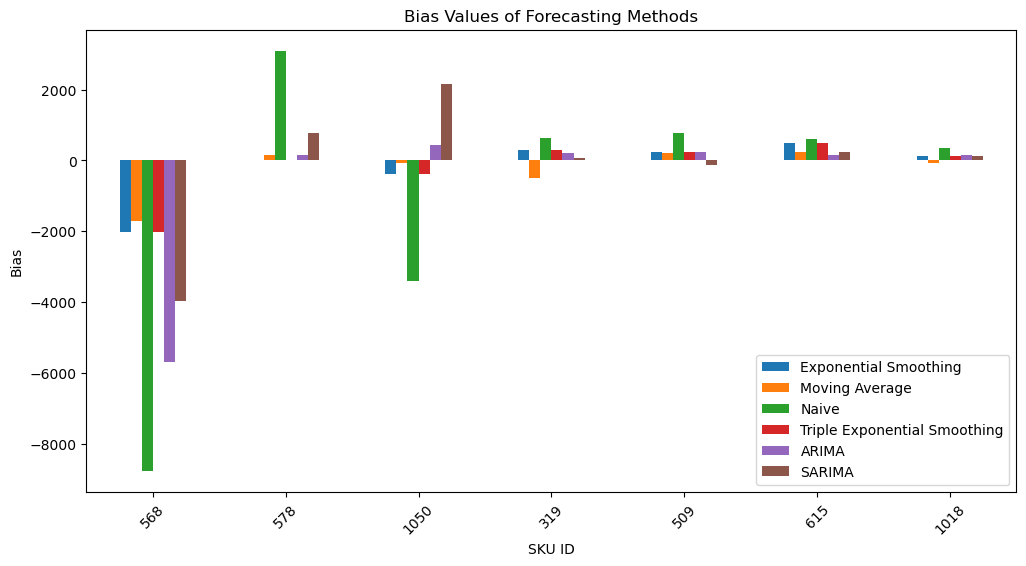

In [95]:
plt.figure(figsize=(12, 6))
all_forecasts_bias_weekly.plot(kind='bar', figsize=(12, 6))
plt.title('Bias Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.show()


## MAPE Values of Forecasting Methods

In [96]:
all_forecasts_mape_weekly = pd.concat([exponential_smoothing_forecast_weekly['mape'], moving_average_forecast_weekly['mape'], naive_forecast_weekly['mape'], triple_exponential_smoothing_forecast_weekly['mape'], arima_forecast_weekly['mape'], sarima_forecast_weekly['mape']], axis=1)

all_forecasts_mape_weekly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_mape_weekly

Exponential Smoothing  Moving Average  Naive  \
sku_id                                                 
568                     4.115           2.704  1.370   
578                     2.334           2.231  3.497   
1050                    3.113           2.052  1.049   
319                     0.708           0.547  0.729   
509                     0.953           0.816  1.088   
615                     2.217           1.644  1.920   
1018                    0.793           0.587  0.904   

        Triple Exponential Smoothing  ARIMA  SARIMA  
sku_id                                               
568                            4.115  1.826   3.245  
578                            2.334  2.224   2.814  
1050                           3.113  2.239   3.664  
319                            0.708  0.642   0.693  
509                            0.953  0.824   0.867  
615                            2.217  1.583   2.023  
1018                           0.793  0.734   0.808

<Figure size 1200x600 with 0 Axes>

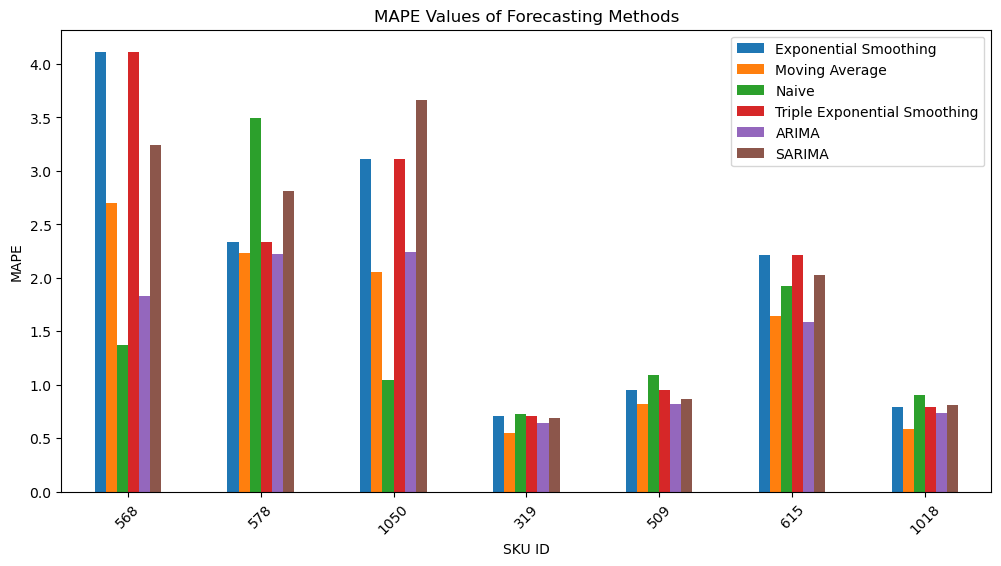

In [97]:
plt.figure(figsize=(12, 6))
all_forecasts_mape_weekly.plot(kind='bar', figsize=(12, 6))
plt.title('MAPE Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.show()

## MAD = |Actual - Forecasted| / n

MAD is the average of the absolute differences between the forecasted values and the actual values. It is a measure of the accuracy of the forecasting method. The lower the MAD value, the more accurate the forecasting method is.

In [98]:
exponential_smoothing_forecast_weekly

mape           mse      rmse      bias       mad
sku_id                                                   
568     4.115  8.551615e+07  9247.494 -2011.990  5178.954
578     2.334  2.614115e+07  5112.842    19.738  2934.134
1050    3.113  3.747607e+07  6121.770  -393.668  4993.284
319     0.708  1.656245e+06  1286.952   291.649   829.607
509     0.953  8.716853e+05   933.641   251.287   698.604
615     2.217  1.620565e+06  1273.014   497.775   872.649
1018    0.793  2.058967e+05   453.758   134.343   327.921

In [99]:
all_forecasts_mad_weekly = pd.concat([exponential_smoothing_forecast_weekly['mad'], moving_average_forecast_weekly['mad'], naive_forecast_weekly['mad'], triple_exponential_smoothing_forecast_weekly['mad'], arima_forecast_weekly['mad'], sarima_forecast_weekly['mad']], axis=1)

all_forecasts_mad_weekly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_mad_weekly

Exponential Smoothing  Moving Average     Naive  \
sku_id                                                    
568                  5178.954        5531.513  9203.731   
578                  2934.134        2721.438  4537.519   
1050                 4993.284        3457.673  4095.404   
319                   829.607        1008.481  1166.596   
509                   698.604         516.354   822.731   
615                   872.649         776.533   943.923   
1018                  327.921         304.203   458.596   

        Triple Exponential Smoothing     ARIMA    SARIMA  
sku_id                                                    
568                         5178.954  6706.491  5585.790  
578                         2934.134  2688.978  3533.539  
1050                        4993.284  3443.016  4133.088  
319                          829.607  1019.402   836.596  
509                          698.604   520.594   731.575  
615                          872.649   758.520   848.186  
1018                         327.921   355.112   331.923

<Figure size 1200x600 with 0 Axes>

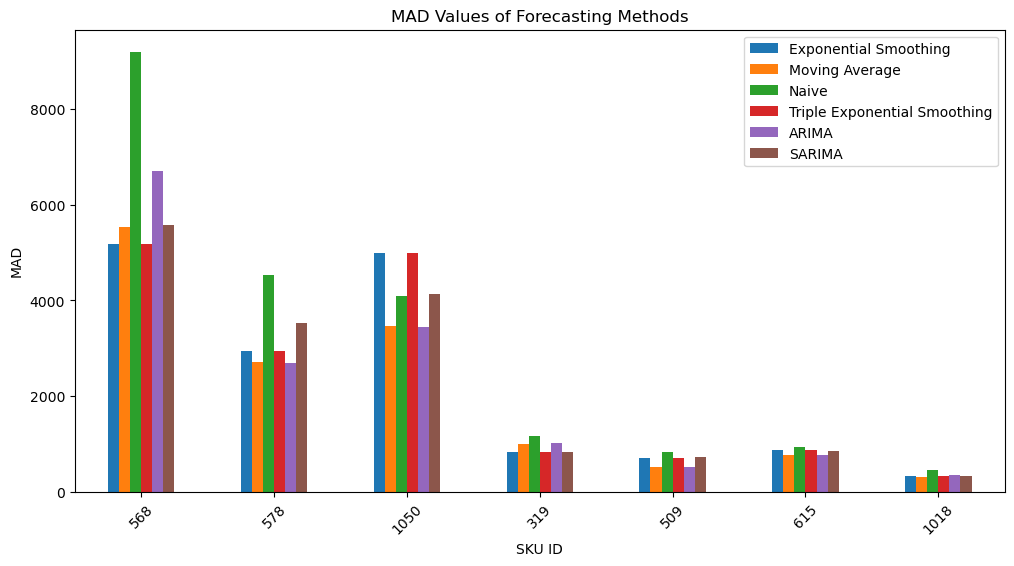

In [100]:
plt.figure(figsize=(12, 6))
all_forecasts_mad_weekly.plot(kind='bar', figsize=(12, 6))
plt.title('MAD Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAD')
plt.xticks(rotation=45)
plt.show()

## All Metrics Comparison

In [101]:
all_forecasts_metrics_weekly = pd.concat([exponential_smoothing_forecast_weekly, moving_average_forecast_weekly, naive_forecast_weekly, triple_exponential_smoothing_forecast_weekly, arima_forecast_weekly, sarima_forecast_weekly], axis=1)
all_forecasts_metrics_weekly.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']
all_forecasts_metrics_weekly

ValueError: Length mismatch: Expected axis has 30 elements, new values have 6 elements

In [ ]:
plt.figure(figsize=(12, 6))
all_forecasts_metrics_weekly.plot(kind='bar', figsize=(12, 6))
plt.title('Weekly Forecasting Methods Comparison')
plt.xlabel('SKU ID')
plt.ylabel('Metrics')
plt.xticks(rotation=45)
plt.show()

# Daily Sales Analysis and Forecasting

In this section, we will analyze the daily sales data and forecast the sales for the next 360 days.

In [ ]:
daily_data = data.copy()
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data = daily_data.groupby(['Date', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()

daily_data

In [ ]:
daily_skus = all_sku_ids
# ['319']

In [ ]:
def plot_sku_daily(sku_id):
    sku = daily_data[daily_data['SkuID'] == sku_id]
    plt.figure(figsize=(12, 6))
    plt.plot(sku['Date'], sku['TotalQuantity'])
    plt.title(f'SKU {sku_id} Total Quantity by Day')
    plt.xlabel('Day')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
for sku_id in daily_skus:
    print(f'SKU {sku_id}')
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    sku_data.set_index(['Date'], inplace=True)
    plot_sku_daily(sku_id)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in daily_skus:
    print(f'SKU {sku_id}')
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=360)
    result.plot()
    plt.show()
    

In [ ]:
daily_data.set_index(['Date'], inplace=True)
daily_data

## Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

exponential_smoothing_forecast_daily = []

def forecast_sku_ExponentialSmoothing_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=90, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(360)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=360, trend='add').fit()
    future_forecast = full_model.forecast(360)
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    exponential_smoothing_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
'mad': round(mad, 3)
    })
    

In [ ]:
for sku_id in daily_skus:
    forecast_sku_ExponentialSmoothing_daily(sku_id)

In [ ]:
exponential_smoothing_forecast_daily = pd.DataFrame(exponential_smoothing_forecast_daily)
exponential_smoothing_forecast_daily.set_index('sku_id', inplace=True)
exponential_smoothing_forecast_daily

## Moving Average

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def moving_average_forecast(series, window):
    return series.rolling(window=window).mean().iloc[-1]

def evaluate_model(series, window):
    forecast = moving_average_forecast(series, window)
    mse = mean_squared_error(series[-360:], np.full(360, forecast))
    return mse

def find_best_window_size(series, window_range):
    best_window = None
    best_mse = float('inf')
    for window in window_range:
        mse = evaluate_model(series, window)
        if mse < best_mse:
            best_mse = mse
            best_window = window
    return best_window

window_range = range(1, 365)  

best_window = find_best_window_size(daily_data['TotalQuantity'], window_range)
print('Best Window Size:', best_window)

In [ ]:
moving_average_forecast_daily = []

def moving_average_forecast(series, window):
    return series.rolling(window=window).mean().iloc[-1]

def forecast_sku_MovingAverage_daily(sku_id, window=360):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Calculate moving average forecast for the validation period
    validation_forecast = np.full(360, moving_average_forecast(train, window))
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Calculate moving average forecast for the next 360 days
    future_forecast = np.full(360, moving_average_forecast(sku_data['TotalQuantity'], window)).astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    moving_average_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_MovingAverage_daily(sku_id)

In [ ]:
moving_average_forecast_daily = pd.DataFrame(moving_average_forecast_daily)
moving_average_forecast_daily.set_index('sku_id', inplace=True)
moving_average_forecast_daily

## Naive

In [ ]:
naive_forecast_daily = []

def forecast_sku_Naive_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Use the last observed value in the training set to forecast the validation period
    last_observed_value = train.iloc[-1]
    validation_forecast = np.full(360, last_observed_value)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast)
    
    # Use the last observed value in the entire dataset to forecast the next 360 days
    last_observed_value_full = sku_data['TotalQuantity'].iloc[-1]
    future_forecast = np.full(360, last_observed_value_full).astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    naive_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_Naive_daily(sku_id)
    

In [ ]:
naive_forecast_daily = pd.DataFrame(naive_forecast_daily)
naive_forecast_daily.set_index('sku_id', inplace=True)
naive_forecast_daily


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple_exponential_smoothing_forecast_daily = []

def forecast_sku_TripleExponentialSmoothing_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=90, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(360)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=90, trend='add').fit()
    future_forecast = full_model.forecast(360)
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    triple_exponential_smoothing_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_TripleExponentialSmoothing_daily(sku_id)
    

In [ ]:
triple_exponential_smoothing_forecast_daily = pd.DataFrame(triple_exponential_smoothing_forecast_daily)
triple_exponential_smoothing_forecast_daily.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast_daily


# Daily: Seasonal Forecasting Methods

There are seasonal patterns in the weekly data. So, we can use forecasting methods that can capture the seasonality.

- Triple Exponential Smoothing
- ARIMA
- SARIMA

## Triple Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

triple_exponential_smoothing_forecast_daily = []

def forecast_sku_TripleExponentialSmoothing_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=90, trend='add').fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(360)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    full_model = ExponentialSmoothing(sku_data['TotalQuantity'], seasonal='add', seasonal_periods=90, trend='add').fit()
    future_forecast = full_model.forecast(360)
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    triple_exponential_smoothing_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_TripleExponentialSmoothing_daily(sku_id)
    

In [ ]:
triple_exponential_smoothing_forecast_daily = pd.DataFrame(triple_exponential_smoothing_forecast_daily)
triple_exponential_smoothing_forecast_daily.set_index('sku_id', inplace=True)
triple_exponential_smoothing_forecast_daily

## ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_forecast_daily = []

def forecast_sku_ARIMA_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = ARIMA(train, order=(5,1,0)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.forecast(steps=360)
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    full_model = ARIMA(sku_data['TotalQuantity'], order=(5,1,0)).fit()
    future_forecast = full_model.forecast(steps=360)
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    arima_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })
    
    

In [ ]:
for sku_id in daily_skus:
    forecast_sku_ARIMA_daily(sku_id)
    

In [ ]:
arima_forecast_daily = pd.DataFrame(arima_forecast_daily)
arima_forecast_daily.set_index('sku_id', inplace=True)
arima_forecast_daily

## SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_forecast_daily = []

def forecast_sku_SARIMA_daily(sku_id):
    sku_data = daily_data[daily_data['SkuID'] == sku_id]
    
    # Split the data into training and validation sets
    train = sku_data['TotalQuantity'][:-360]
    validation = sku_data['TotalQuantity'][-360:]
    
    # Train the model
    model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,90)).fit()
    
    # Forecast for the validation period
    validation_forecast = model.get_forecast(steps=360).predicted_mean
    
    # Calculate metrics for the validation period
    mape, mse, rmse, bias, mad = calculate_metrics(validation.values, validation_forecast.values)
    
    # Forecast for the next 360 days
    full_model = SARIMAX(sku_data['TotalQuantity'], order=(1,1,1), seasonal_order=(1,1,1,90)).fit()
    future_forecast = full_model.get_forecast(steps=360).predicted_mean
    future_forecast = future_forecast.astype(int)
    
    forecast_dates = pd.date_range(start=sku_data.index[-1], periods=360, freq='D')
    forecast_table = pd.DataFrame({
        'Date': forecast_dates, 
        'Forecasted': future_forecast
    })
    forecast_table.set_index(['Date'], inplace=True)
    
    # Append results including validation metrics
    sarima_forecast_daily.append({
        'sku_id': sku_id, 
        'mape': round(mape, 3), 
        'mse': round(mse, 3), 
        'rmse': round(rmse, 3), 
        'bias': round(bias, 3),
        'mad': round(mad, 3)
    })

In [ ]:
for sku_id in daily_skus:
    forecast_sku_SARIMA_daily(sku_id)
    

In [ ]:
sarima_forecast_daily = pd.DataFrame(sarima_forecast_daily)
sarima_forecast_daily.set_index('sku_id', inplace=True)
sarima_forecast_daily

# Daily: Comparison of Forecasting Methods
## Bias Values of Forecasting Methods


In [ ]:
all_forecasts_bias_daily = pd.concat([exponential_smoothing_forecast_daily['bias'], moving_average_forecast_daily['bias'], naive_forecast_daily['bias'], triple_exponential_smoothing_forecast_daily['bias'], arima_forecast_daily['bias'], sarima_forecast_daily['bias']], axis=1)

all_forecasts_bias_daily.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_bias_daily

In [ ]:
plt.figure(figsize=(12, 6))
all_forecasts_bias_daily.plot(kind='bar', figsize=(12, 6))
plt.title('Bias Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.show()

## MAPE Values of Forecasting Methods

In [ ]:
all_forecasts_mape_daily = pd.concat([exponential_smoothing_forecast_daily['mape'], moving_average_forecast_daily['mape'], naive_forecast_daily['mape'], triple_exponential_smoothing_forecast_daily['mape'], arima_forecast_daily['mape'], sarima_forecast_daily['mape']], axis=1)

all_forecasts_mape_daily.columns = ['Exponential Smoothing', 'Moving Average', 'Naive', 'Triple Exponential Smoothing', 'ARIMA', 'SARIMA']

all_forecasts_mape_daily

In [ ]:
plt.figure(figsize=(12, 6))
all_forecasts_mape_daily.plot(kind='bar', figsize=(12, 6))
plt.title('MAPE Values of Forecasting Methods')
plt.xlabel('SKU ID')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.show()


# REGRESSION ANALYSIS

In this section, we will perform regression analysis to predict the total quantity of a product based on the other features in the dataset.

We will use the following regression algorithms:

- Linear Regression
- Decision Tree Regression
- Random Forest Regression
- Gradient Boosting Regression


In [ ]:
from sklearn.model_selection import train_test_split

regression_data = raw_data.copy()
regression_data = regression_data.dropna()

X = regression_data.drop(['TotalQuantity'], axis=1)
y = regression_data['TotalQuantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)

y_pred = linear_regression.predict(X_test)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

In [ ]:
linear_regression.coef_